In [579]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric
!pip install keras-cv
import warnings
warnings.filterwarnings('ignore')


3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [398]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from collections import defaultdict

In [412]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)   

    @staticmethod
    def create_sequences_mimic(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Y_exogs, Y_targets, sample_idxs = list(), list(), list(), list(), list()

        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                #output_series = series[
                #    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                #]
                
                output_series = series[(i + back_horizon) : (i + back_horizon + horizon)]
    
                output_series_exog = np.delete(output_series, [target_col], axis=1)
                output_series_target = output_series[:, [target_col]]

                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Y_exogs.append(output_series_exog)
                    Y_targets.append(output_series_target)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Y_exogs), np.array(Y_targets), np.array(sample_idxs)


    def preprocessing_mimic(
        self,
        lst_train_arrays,
        lst_test_arrays,
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
    
        self.scaler = []

        patient_to_arrays = defaultdict(list)
        
        for item in lst_train_arrays:
            patient_id = item["patient_id"]
            array = item["array"]
            patient_to_arrays[patient_id].append(array)

        patient_ids = list(patient_to_arrays.keys())
        np.random.shuffle(patient_ids)
        
        split_idx = int(len(patient_ids) * train_size)
        
        train_patient_ids = patient_ids[:split_idx]
        val_patient_ids = patient_ids[split_idx:]
        
        # Step 3: Gather arrays again
        train_patients = [arr for pid in train_patient_ids for arr in patient_to_arrays[pid]]
        val_patients = [arr for pid in val_patient_ids for arr in patient_to_arrays[pid]]
        #print("TRAIN, VAL", train_patients, val_patients)
        #train_patients = [entry['array'] for entry in train_patients]
        #val_patients = [entry['array'] for entry in val_patients]
        lst_test_arrays = [entry['array'] for entry in lst_test_arrays]
        if self.normalize:
            self.scaler = []
            num_features = train_patients[0].shape[1]
            # Create one scaler per feature across all train patients
            for col_idx in range(num_features):
                scaler = MinMaxScaler(feature_range=(0,1), clip=False)
                all_train_data_col = np.concatenate([patient[:, col_idx] for patient in train_patients])
                scaler.fit(add_extra_dim(all_train_data_col))
                self.scaler.append(scaler)
        
        # Normalize train patients using the scalers
        train_lst = []
        for bg_sample_train in train_patients:
            if self.normalize:
                for col_idx in range(bg_sample_train.shape[1]):
                    scaler = self.scaler[col_idx]
                    bg_sample_train[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(bg_sample_train[:, col_idx]))
                    )
            train_lst.append(bg_sample_train)
        
        # Normalize val patients with train scalers
        val_lst = []
        for bg_sample_val in val_patients:
            if self.normalize and self.scaler:
                for col_idx in range(bg_sample_val.shape[1]):
                    scaler = self.scaler[col_idx]
                    bg_sample_val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(bg_sample_val[:, col_idx]))
                    )
            val_lst.append(bg_sample_val)
        
        # Normalize test patients with train scalers
        test_lst = []
        for bg_sample_test in lst_test_arrays:
            if self.normalize and self.scaler:
                for col_idx in range(bg_sample_test.shape[1]):
                    scaler = self.scaler[col_idx]
                    bg_sample_test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(bg_sample_test[:, col_idx]))
                    )
            test_lst.append(bg_sample_test)

        self.historical_values = []
        for series in train_lst + val_lst + test_lst:
            lst_hist_values = []
            for col_idx in range(series.shape[1]):
                unique_values = np.unique(np.round(series[:, col_idx], decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)
    
        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train_exog,
            self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences_mimic(
            train_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val_exog,
            self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences_mimic(
            val_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test_exog,
            self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences_mimic(
            test_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            horizon,
            self.back_horizon,
            sequence_stride,
            target_col,
        )


In [198]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [313]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            #print("TETSTSETS", idx, cut, a_train, a_test)
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")

    elif dataset == "mimic":
        #base_cluster_dir = data_path + "data_MIMIC/" + "cluster_csv"
        base_cluster_dir = data_path + "data_MIMIC/" + "gender_csv"
        #output_dir = data_path + "data_MIMIC/" + "combined_cluster_data"
        output_dir = data_path + "data_MIMIC/" + "combined_gender_data"
        os.makedirs(output_dir, exist_ok=True)
        for gender_id in ["0", "1"]:
            gender_folder = f"gender_{gender_id}"
            gender_path = os.path.join(base_cluster_dir, gender_folder)
    
            if not os.path.isdir(gender_path):
                print(f"gender folder {gender_folder} not found.")
                continue
    
            print(f"Processing {gender_folder}...")
    
            all_data = pd.DataFrame()
    
            for file_name in sorted(os.listdir(gender_path)):
                if not file_name.endswith(".csv"):
                    continue
    
                file_path = os.path.join(gender_path, file_name)
                df = pd.read_csv(file_path)
                subject_id = int(file_name.split("_")[1].replace(".csv", ""))
                df['patient_id'] = subject_id
                df['label_30d'] = df['label_30d'].astype(int)
                df['label_1y'] = df['label_1y'].astype(int)
    
                all_data = pd.concat([all_data, df], ignore_index=True)
    
            # Patient-level split for this gender
            patient_ids = all_data['patient_id'].unique()
            train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
    
            train = all_data[all_data['patient_id'].isin(train_ids)]
            test = all_data[all_data['patient_id'].isin(test_ids)]
    
            train.to_csv(os.path.join(output_dir, f"gender_{gender_id}_train.csv"), index=False)
            test.to_csv(os.path.join(output_dir, f"gender_{gender_id}_test.csv"), index=False)
    
            print(f"Gender {gender_id}: {len(train_ids)} train patients, {len(test_ids)} test patients.")
            print(f"Files saved in {output_dir}")

        # for cluster_id in ["0", "1", "2", "3"]:
        #     cluster_folder = f"cluster_{cluster_id}"
        #     cluster_path = os.path.join(base_cluster_dir, cluster_folder)
    
        #     if not os.path.isdir(cluster_path):
        #         print(f"Cluster folder {cluster_folder} not found.")
        #         continue
    
        #     print(f"Processing {cluster_folder}...")
    
        #     all_data = pd.DataFrame()
    
        #     for file_name in sorted(os.listdir(cluster_path)):
        #         if not file_name.endswith(".csv"):
        #             continue
    
        #         file_path = os.path.join(cluster_path, file_name)
        #         df = pd.read_csv(file_path)
        #         subject_id = int(file_name.split("_")[1].replace(".csv", ""))
        #         df['patient_id'] = subject_id
        #         df['label_30d'] = df['label_30d'].astype(int)
        #         df['label_1y'] = df['label_1y'].astype(int)
    
        #         all_data = pd.concat([all_data, df], ignore_index=True)
    
        #     # Patient-level split for this cluster
        #     patient_ids = all_data['patient_id'].unique()
        #     train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
    
        #     train = all_data[all_data['patient_id'].isin(train_ids)]
        #     test = all_data[all_data['patient_id'].isin(test_ids)]
    
        #     train.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_train.csv"), index=False)
        #     test.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_test.csv"), index=False)
    
        #     print(f"Cluster {cluster_id}: {len(train_ids)} train patients, {len(test_ids)} test patients.")
        #     print(f"Files saved in {output_dir}")


In [402]:
def load_data(dataset, data_path, cluster_id):
    cluster_id = cluster_id
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(data_path, cluster_id, "_train.csv" )
        test, orig_test = load_mimic_data(data_path, cluster_id, "_test.csv")
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg

def load_mimic_data(data_path,  cluster_id, file_name = "_train.csv"):
    #data = pd.read_csv(data_path + "data_MIMIC/combined_cluster_data/" + "cluster_" + cluster_id + file_name)
    #full_path = os.path.join(data_path, "data_MIMIC", "combined_cluster_data", f"cluster_{cluster_id}{file_name}")
    full_path = os.path.join(data_path, "data_MIMIC", "combined_gender_data", f"gender_{cluster_id}{file_name}")
    data = pd.read_csv(full_path)
    print("data", data)
    # Select relevant features for lst_arrays
    #feature_columns = [
    #    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    #    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    #    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
    #]
    
    feature_columns = [
        "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
        "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
        "WBC Count", "Sodium", "NT-proBNP", "Troponin T", "label_1y"#"label_30d"
    ]
    lst_arrays = []
    for patient_id, group in data.groupby("patient_id"):
        lst_arrays.append({
            "patient_id": patient_id,
            "array": group[feature_columns].to_numpy()
        })
    return lst_arrays, data



In [247]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [404]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
parser.add_argument( "--cluster", type=str, default=0, help="Choose cluster for MIMIC data, default 0")
# Parse the arguments from a string
#args = parser.parse_args("--dataset ohiot1dm --horizon 3 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 5 --back-horizon 20 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#gender F=0, M=1
args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper --cluster 0".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path, args.cluster) #misschien toch load_data gebruiken?
print(f"lst_arrays length: {len(lst_arrays)}")
for i, arr in enumerate(lst_arrays[:3]):  # Sample check
    print(f"lst_arrays[{i}] shape: {arr['array'].shape}") #add ['array'] for mimic


print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0]['array'].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0]['array'].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")


Processing gender_0...
Gender 0: 888 train patients, 222 test patients.
Files saved in ./data/data_MIMIC/combined_gender_data
Processing gender_1...
Gender 1: 624 train patients, 157 test patients.
Files saved in ./data/data_MIMIC/combined_gender_data
data        Heart Rate  Systolic BP  Diastolic BP   SpO2  Temperature        BMI  \
0            86.4    98.272727     63.318182   96.8    98.156522  96.000000   
1            84.8    98.545455     63.636364   97.6    98.113043  96.000000   
2            83.2    98.818182     63.954545   98.4    98.069565  96.000000   
3            81.6    99.090909     64.272727   99.2    98.026087  96.000000   
4            80.0    99.363636     64.590909  100.0    97.982609  96.000000   
...           ...          ...           ...    ...          ...        ...   
21307        77.0   110.000000     57.000000   98.0    96.500000  69.011628   
21308        78.0   122.000000     39.000000   95.0    96.500000  68.720930   
21309        81.0   124.000000  

In [317]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.math.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * tf.math.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

In [512]:
# parser = ArgumentParser()
# parser.add_argument( "--dataset", type=str, help="Choose dataset.")
# parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
# parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
# parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
# parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
# parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
# # Parse the arguments from a string
# #args = parser.parse_args("--dataset ohiot1dm --horizon 3 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args("--dataset simulated --horizon 5 --back-horizon 20 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper".split())
# #args = parser.parse_args()
# data_path = "./data/"
# lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
# print(lst_arrays, orig_train)
# #print(lst_arrays, orig_train)
# print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
# print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

# print(f"===========Desired trend parameters=============")
# center = "last"
# desired_shift, poly_order = 0, 1
# fraction_std = 1#args.fraction_std
# print(f"center: {center}, desired_shift: {desired_shift};")
# print(f"fraction_std:{fraction_std};")
# print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated":
    CHANGE_COLS = [1, 2]
elif args.dataset == "mimic": #??? more
    CHANGE_COLS = list(range(14))  # 0-13 as exogenous
    TARGET_COL = 14  #or 15, 14:30d, 15:1y
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
if args.dataset == "mimic":
    dataset.preprocessing_mimic(
        lst_train_arrays=lst_arrays,
        lst_test_arrays=lst_arrays_test,
        train_size=TRAIN_SIZE,
        normalize=True,
        sequence_stride=1,
        target_col=TARGET_COL,
        exog_cols=CHANGE_COLS,
        horizon=horizon
    )
else:
    dataset.preprocessing(#???
        lst_train_arrays=lst_arrays,
        lst_test_arrays=lst_arrays_test,
        train_size=TRAIN_SIZE,
        normalize=True,
        sequence_stride= horizon,
        target_col=TARGET_COL,
        exog_cols=CHANGE_COLS,
        horizon = horizon
    )
print("X_train_exog shape:", dataset.X_train_exog.shape)
print("X_train_target shape:", dataset.X_train_target.shape)
print("Y_train_exog shape:", dataset.Y_train_exog.shape)
print("Y_train_target shape:", dataset.Y_train_target.shape)

print("Target col indices in exog columns?", dataset.target_col in dataset.exog_cols)
print("Sample exog features (first 5):", dataset.X_train_exog[0, 0, :5])
print("Sample target values (first 5):", dataset.Y_train_target[0, 0, :5])

print("Unique values in Y_train_target:", np.unique(dataset.Y_train_target))

print("X_train includes target col?", np.any(np.isin(dataset.exog_cols, [dataset.target_col])))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
if args.dataset == "mimic":

    print("X_train_exog shape:", dataset.X_train_exog.shape)
    print("X_train_target shape:", dataset.X_train_target.shape)#, dataset.X_train_target)
    print("Y_train_exog shape:", dataset.Y_train_exog.shape)
    print("Y_train_target shape:", dataset.Y_train_target.shape)#, dataset.Y_train_target)
    print("Y_test_exog shape:", dataset.Y_test_exog.shape)
    print("Y_test_target shape:", dataset.Y_test_target.shape)#, dataset.Y_test_target)
    X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
    y_train = np.concatenate((dataset.Y_train_exog, dataset.Y_train_target), axis=-1)
    X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
    y_test = np.concatenate((dataset.Y_test_exog, dataset.Y_test_target), axis=-1)
    X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
    y_val = np.concatenate((dataset.Y_val_exog, dataset.Y_val_target), axis=-1)
    exog_train = dataset.X_train_exog
    exog_test = dataset.X_test_exog
    exog_val = dataset.X_val_exog
    print(orig_train)
    tf.random.set_seed(args.random_seed)
    
    n_in_features = X_train.shape[2]
    n_exog_features = exog_train.shape[2]
    print(n_in_features, n_exog_features)

    inputs = layers.Input(shape=(args.back_horizon, n_in_features))
    x = layers.GRU(100, activation="tanh", return_sequences=True, dropout=0.3, recurrent_dropout=0.1)(inputs)
    x = layers.GRU(100, activation="tanh", return_sequences=True, dropout=0.3, recurrent_dropout=0.1)(x)
    x = layers.Bidirectional(layers.GRU(100, return_sequences=False))(x)

    # Exogenous continuous output head (linear)
    exog_output = layers.Dense(args.horizon * len(CHANGE_COLS), activation="linear")(x)
    exog_output = layers.Reshape((args.horizon, len(CHANGE_COLS)), name="exog_output")(exog_output)
    
    # Binary target output head (sigmoid)
    binary_output = layers.Dense(args.horizon, activation="sigmoid")(x)
    binary_output = layers.Reshape((args.horizon, 1), name="binary_output")(binary_output)
    
    # Combined model
    forecast_GRU = keras.Model(inputs=inputs, outputs=[exog_output, binary_output])

    # Compile model
    forecast_GRU.compile(
        optimizer="adam",
        loss={
            "exog_output": "mse",
            "binary_output": "binary_crossentropy"
        },
        metrics={
            "binary_output": ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
        }
    )


    # Train the multi-head GRU
    forecast_GRU.fit(
        X_train, {"exog_output": dataset.Y_train_exog, "binary_output": dataset.Y_train_target},
        epochs=200,
        batch_size=64,
        validation_data=(X_val, {"exog_output": dataset.Y_val_exog, "binary_output": dataset.Y_val_target}),
        callbacks=[early_stopping]
    )
    pred_exog_gru, pred_target_gru = forecast_GRU.predict(X_test)# Apply threshold of 0.5 (or use a different threshold depending on your problem)
    binary_preds_gru = (pred_target_gru >= 0.5).astype(int)


    class NBeatsBlock(layers.Layer):
        def __init__(self, units, **kwargs):
            super().__init__(**kwargs)
            self.fc1 = layers.Dense(units, activation="relu")
            self.fc2 = layers.Dense(units, activation="relu")
            self.norm = layers.LayerNormalization()
    
        def call(self, inputs):
            x = self.fc1(inputs)
            x = self.fc2(x)
            x = self.norm(x)
            return x
    
    def build_multihead_nbeats_model(back_horizon, n_in_features, horizon, exog_dim, units=128):
        inputs = keras.Input(shape=(back_horizon, n_in_features))
        x = layers.Flatten()(inputs)
        x = NBeatsBlock(units)(x)
    
        # Exogenous output head
        exog_output = layers.Dense(horizon * exog_dim, activation="linear")(x)
        exog_output = layers.Reshape((horizon, exog_dim), name="exog_output")(exog_output)
    
        # Binary target output head
        binary_output = layers.Dense(horizon, activation="sigmoid")(x)
        binary_output = layers.Reshape((horizon, 1), name="binary_output")(binary_output)
    
        model = keras.Model(inputs, [exog_output, binary_output])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss={
                "exog_output": "mse",
                "binary_output": "binary_crossentropy"
            },
            metrics={
                "binary_output": ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
            }
        )
        return model


    forecast_NBEATS_multi = build_multihead_nbeats_model(back_horizon, n_in_features, horizon, len(CHANGE_COLS))
    
    forecast_NBEATS_multi.fit(
        X_train,
        {"exog_output": dataset.Y_train_exog, "binary_output": dataset.Y_train_target},
        epochs=200,
        batch_size=32,
        validation_data=(X_val, {"exog_output": dataset.Y_val_exog, "binary_output": dataset.Y_val_target}),
        callbacks=[early_stopping]
    )
    pred_exog_nbeats, pred_target_nbeats = forecast_NBEATS_multi.predict(X_test)# Apply threshold of 0.5 (or use a different threshold depending on your problem)
    binary_preds_nbeats = (pred_target_nbeats >= 0.5).astype(int)


    
    # forecast_GRU = keras.Sequential([
    #     layers.Input(shape=(args.back_horizon, n_in_features)),
    #     layers.GRU(100, activation="tanh", return_sequences=True, dropout=0.3, recurrent_dropout=0.1),
    #     layers.GRU(100, activation="tanh", return_sequences=True, dropout=0.3, recurrent_dropout=0.1),
    #     layers.Bidirectional(layers.GRU(100, return_sequences=False)),
    #     layers.Dense(args.horizon * n_in_features, activation="sigmoid"),
    #     layers.Reshape((args.horizon, n_in_features))
    # ])

    # # forecast_GRU = keras.Sequential([
    # #     layers.Input(shape=(args.back_horizon, n_in_features)),
    # #     layers.GRU(100, activation="tanh", return_sequences=True),
    # #     layers.GRU(100, activation="tanh", return_sequences=False),
    # #     layers.Dense(args.horizon, activation="sigmoid"),  # Output horizon binary values
    # #     layers.Reshape((args.horizon, 1))
    # # ])

    # class NBeatsBlock(layers.Layer):
    #     def __init__(self, units, horizon, **kwargs):
    #         super().__init__(**kwargs)
    #         self.fc1 = layers.Dense(units, activation="relu")
    #         self.fc2 = layers.Dense(units, activation="relu")
    #         #self.fc3 = layers.Dense(units, activation="relu")
    #         #self.fc4 = layers.Dense(units, activation="relu")
    #         self.norm = layers.LayerNormalization()
    #         self.backcast = layers.Dense(horizon * n_in_features, activation="sigmoid")  
    #         self.forecast = layers.Dense(horizon * n_in_features, activation="sigmoid") 
            
    #     def call(self, inputs):
    #         x = self.fc1(inputs)
    #         x = self.fc2(x)
    #         #x = self.fc3(x)
    #         #x = self.fc4(x)
    #         x = self.norm(x)
    #         return self.forecast(x)  # No reshape needed if predicting horizon x 1 directly

    # def build_nbeats_model(back_horizon, n_in_features, horizon, units=128):
    #     inputs = keras.Input(shape=(back_horizon, n_in_features))
    #     x = layers.Flatten()(inputs)
    #     x = NBeatsBlock(units, horizon)(x)
    #     x = tf.reshape(x, (-1, horizon, 1))
        
    #     model = keras.Model(inputs, x)
    #     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    #           loss="binary_crossentropy",#focal_loss(alpha=0.25, gamma=2.0),
    #           metrics=[
    #             tf.keras.metrics.Precision(name="precision"),
    #             tf.keras.metrics.Recall(name="recall"),
    #             tf.keras.metrics.Recall(name="accuracy")
    #           ])        
    #           #metrics=["accuracy"])
    
    #     #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    #                   #loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
    #                   #metrics=["accuracy"])
    #                   #loss="binary_crossentropy",
    #                   #metrics=["accuracy"])
    #     return model
    
    # TARGET_INDEX = 0  
    # #y_train_binary = y_train[:, :, TARGET_INDEX].reshape((-1, args.horizon, 1))
    # #y_val_binary = y_val[:, :, TARGET_INDEX].reshape((-1, args.horizon, 1))
    # #y_test_binary = y_test[:, :, TARGET_INDEX].reshape((-1, args.horizon, 1))
    # y_train_binary = y_train  # Shape: (num_samples, args.horizon, n_in_features)
    # y_val_binary = y_val
    # y_test_binary = y_test

    # y_train_labels = y_train_binary.reshape(-1)
    # unique_classes = np.unique(y_train_labels)
    # class_weights = class_weight.compute_class_weight(class_weight='balanced',
    #                                                   classes=unique_classes,
    #                                                   y=y_train_labels)
    # class_weights_dict = {label: weight for label, weight in zip(unique_classes, class_weights)}
    
    # #weights = [class_weights_dict.get(0, 1.0), class_weights_dict.get(1, 1.0)]

    # loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    # forecast_GRU.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    #         # .compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    #         #   loss="binary_crossentropy",#focal_loss(alpha=0.25, gamma=2.0),
    #         #   metrics=[
    #         #     tf.keras.metrics.Precision(name="precision"),
    #         #     tf.keras.metrics.Recall(name="recall"),
    #         #     tf.keras.metrics.Recall(name="accuracy")
    #         #   ])

    # #.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    # #                  loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0))#, loss="mae")
    # forecast_GRU.fit(X_train, y_train_binary, 
    #                  epochs=200, 
    #                  batch_size=64, 
    #                  validation_data=(X_val, y_val_binary), 
    #                  callbacks=[early_stopping],
    #                  class_weight=class_weights_dict)
    # pred_all_GRU = forecast_GRU.predict(X_test)
    
    # forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
    # forecast_NBEATS.fit(X_train, y_train_binary,
    #                     epochs=200, 
    #                     batch_size=32, 
    #                     validation_data=(X_val, y_val_binary), 
    #                     callbacks=[early_stopping],
    #                     class_weight=class_weights_dict)
    # pred_all_NBEATS = forecast_NBEATS.predict(X_test)

        
else:
    
    print("X_train_exog shape:", dataset.X_train_exog.shape)
    print("X_train_target shape:", dataset.X_train_target.shape)
    print("Y_train shape:", dataset.Y_train.shape)
    
    
    print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
    X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
    y_train = dataset.Y_train
    X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
    y_test = dataset.Y_test
    X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
    y_val = dataset.Y_val
    print("Test", X_train, y_train)
    exog_train = dataset.X_train_exog
    exog_test = dataset.X_test_exog
    exog_val = dataset.X_val_exog
    print(orig_train)
    tf.random.set_seed(args.random_seed)
    
    n_in_features = X_train.shape[2]
    n_exog_features = exog_train.shape[2]
    print(n_in_features, n_exog_features)

    forecast_GRU = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=True), #200 testen
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
        tf.keras.layers.Reshape((horizon, n_in_features))
    ])

    # Define N-BEATS Block
    class NBeatsBlock(layers.Layer):
        def __init__(self, units, horizon, n_in_features, **kwargs):
            super(NBeatsBlock, self).__init__(**kwargs)
            self.fc1 = layers.Dense(units, activation="relu")
            self.fc2 = layers.Dense(units, activation="relu")
            self.fc3 = layers.Dense(units, activation="relu")
            self.fc4 = layers.Dense(units, activation="relu")
            self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
            self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  
    
        def call(self, inputs):
            x = self.fc1(inputs)
            x = self.fc2(x)
            x = self.fc3(x)
            x = self.fc4(x)
            backcast = self.backcast(x)
            forecast = self.forecast(x)
            return forecast
    
    def build_nbeats_model(back_horizon, n_in_features, horizon, units=512):
        inputs = keras.Input(shape=(back_horizon, n_in_features))
        x = layers.Flatten()(inputs)  # Flatten time series input
    
        # Stack multiple N-BEATS blocks
        x = NBeatsBlock(units, horizon, n_in_features)(x)
        x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape
    
        model = keras.Model(inputs, x)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
        return model

    forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
    #tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
    forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
    
    
    pred_all_GRU = forecast_GRU.predict(X_test)
    
    #elif args.forecast_model == "nbeatsx":
    forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
    forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
    pred_all_NBEATS = forecast_NBEATS.predict(X_test)




X_train_exog shape: (4260, 12, 14)
X_train_target shape: (4260, 12, 1)
Y_train_exog shape: (4260, 6, 14)
Y_train_target shape: (4260, 6, 1)
Target col indices in exog columns? False
Sample exog features (first 5): [0.62578125 0.26219512 0.38510911 0.09631491 0.93825048]
Sample target values (first 5): [0.]
Unique values in Y_train_target: [0. 1.]
X_train includes target col? False
X_train_exog shape: (4260, 12, 14)
X_train_target shape: (4260, 12, 1)
Y_train_exog shape: (4260, 6, 14)
Y_train_target shape: (4260, 6, 1)
Y_test_exog shape: (1332, 6, 14)
Y_test_target shape: (1332, 6, 1)
       Heart Rate  Systolic BP  Diastolic BP   SpO2  Temperature        BMI  \
0            86.4    98.272727     63.318182   96.8    98.156522  96.000000   
1            84.8    98.545455     63.636364   97.6    98.113043  96.000000   
2            83.2    98.818182     63.954545   98.4    98.069565  96.000000   
3            81.6    99.090909     64.272727   99.2    98.026087  96.000000   
4            8

2025-07-19 10:32:33.899515: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_18}}


67/67 [==============================] - ETA: 0s - loss: 0.1562 - exog_output_loss: 0.0465 - binary_output_loss: 0.1097 - binary_output_accuracy: 0.9696 - binary_output_recall_59: 0.6622 - binary_output_precision_59: 0.8765

2025-07-19 10:32:50.030890: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_18}}


67/67 [==============================] - 18s 68ms/step - loss: 0.1562 - exog_output_loss: 0.0465 - binary_output_loss: 0.1097 - binary_output_accuracy: 0.9696 - binary_output_recall_59: 0.6622 - binary_output_precision_59: 0.8765 - val_loss: 0.2831 - val_exog_output_loss: 0.2585 - val_binary_output_loss: 0.0246 - val_binary_output_accuracy: 0.9944 - val_binary_output_recall_59: 1.0000 - val_binary_output_precision_59: 0.9231
Epoch 2/200
67/67 [==============================] - 3s 43ms/step - loss: 0.0121 - exog_output_loss: 0.0114 - binary_output_loss: 7.1237e-04 - binary_output_accuracy: 1.0000 - binary_output_recall_59: 1.0000 - binary_output_precision_59: 1.0000 - val_loss: 0.2831 - val_exog_output_loss: 0.2548 - val_binary_output_loss: 0.0284 - val_binary_output_accuracy: 0.9944 - val_binary_output_recall_59: 1.0000 - val_binary_output_precision_59: 0.9231
Epoch 3/200
67/67 [==============================] - 3s 39ms/step - loss: 0.0122 - exog_output_loss: 0.0100 - binary_output_los

2025-07-19 10:34:17.624997: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


42/42 [==============================] - 2s 10ms/step
Epoch 1/200
134/134 [==============================] - 3s 6ms/step - loss: 0.6283 - exog_output_loss: 0.3465 - binary_output_loss: 0.2818 - binary_output_accuracy: 0.9032 - binary_output_recall_60: 0.1750 - binary_output_precision_60: 0.2414 - val_loss: 0.4631 - val_exog_output_loss: 0.3248 - val_binary_output_loss: 0.1383 - val_binary_output_accuracy: 0.9469 - val_binary_output_recall_60: 0.2407 - val_binary_output_precision_60: 0.8966
Epoch 2/200
134/134 [==============================] - 0s 3ms/step - loss: 0.1468 - exog_output_loss: 0.0577 - binary_output_loss: 0.0891 - binary_output_accuracy: 0.9786 - binary_output_recall_60: 0.6961 - binary_output_precision_60: 1.0000 - val_loss: 0.3498 - val_exog_output_loss: 0.2990 - val_binary_output_loss: 0.0508 - val_binary_output_accuracy: 0.9991 - val_binary_output_recall_60: 1.0000 - val_binary_output_precision_60: 0.9863
Epoch 3/200
134/134 [==============================] - 0s 3ms/st

2025-07-19 10:35:24.013860: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


In [414]:
from sklearn.metrics import f1_score
import numpy as np

def find_best_threshold(y_true, y_pred_prob, positive_label=1):
    """
    Finds the threshold that maximizes F1-score for the specified positive class.

    Args:
        y_true (array-like): True binary labels (shape: [n_samples]).
        y_pred_prob (array-like): Predicted probabilities (shape: [n_samples]).
        positive_label (int): The label of the positive class (default: 1).

    Returns:
        best_threshold (float): Threshold value maximizing F1-score.
        best_f1 (float): Best F1-score achieved.
    """
    thresholds = np.linspace(0, 1, 101)
    best_threshold = 0.5
    best_f1 = 0.0

    for threshold in thresholds[1:-1]:  # Skip 0.0 and 1.0
        y_pred = (y_pred_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=positive_label)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


Best threshold for GRU: 0.58, Best F1-Score: 0.1687
GRU Model - Balanced Accuracy: 0.5952, PR AUC: 0.0834, Brier Score: 0.3958
GRU Model - Accuracy: 0.4409, F1 Score: 0.1483
GRU Model Classification Report:
              precision    recall  f1-score   support

    Survived       0.96      0.42      0.58      7488
        Died       0.08      0.77      0.15       504

    accuracy                           0.44      7992
   macro avg       0.52      0.60      0.37      7992
weighted avg       0.91      0.44      0.56      7992

Best threshold for NBEATS: 0.01, Best F1-Score: 0.0074
NBEATS Model - Balanced Accuracy: 0.4989, PR AUC: 0.0500, Brier Score: 0.0645
NBEATS Model - Accuracy: 0.9349, F1 Score: 0.0000
NBEATS Model Classification Report:
              precision    recall  f1-score   support

    Survived       0.94      1.00      0.97      7488
        Died       0.00      0.00      0.00       504

    accuracy                           0.93      7992
   macro avg       0.47      

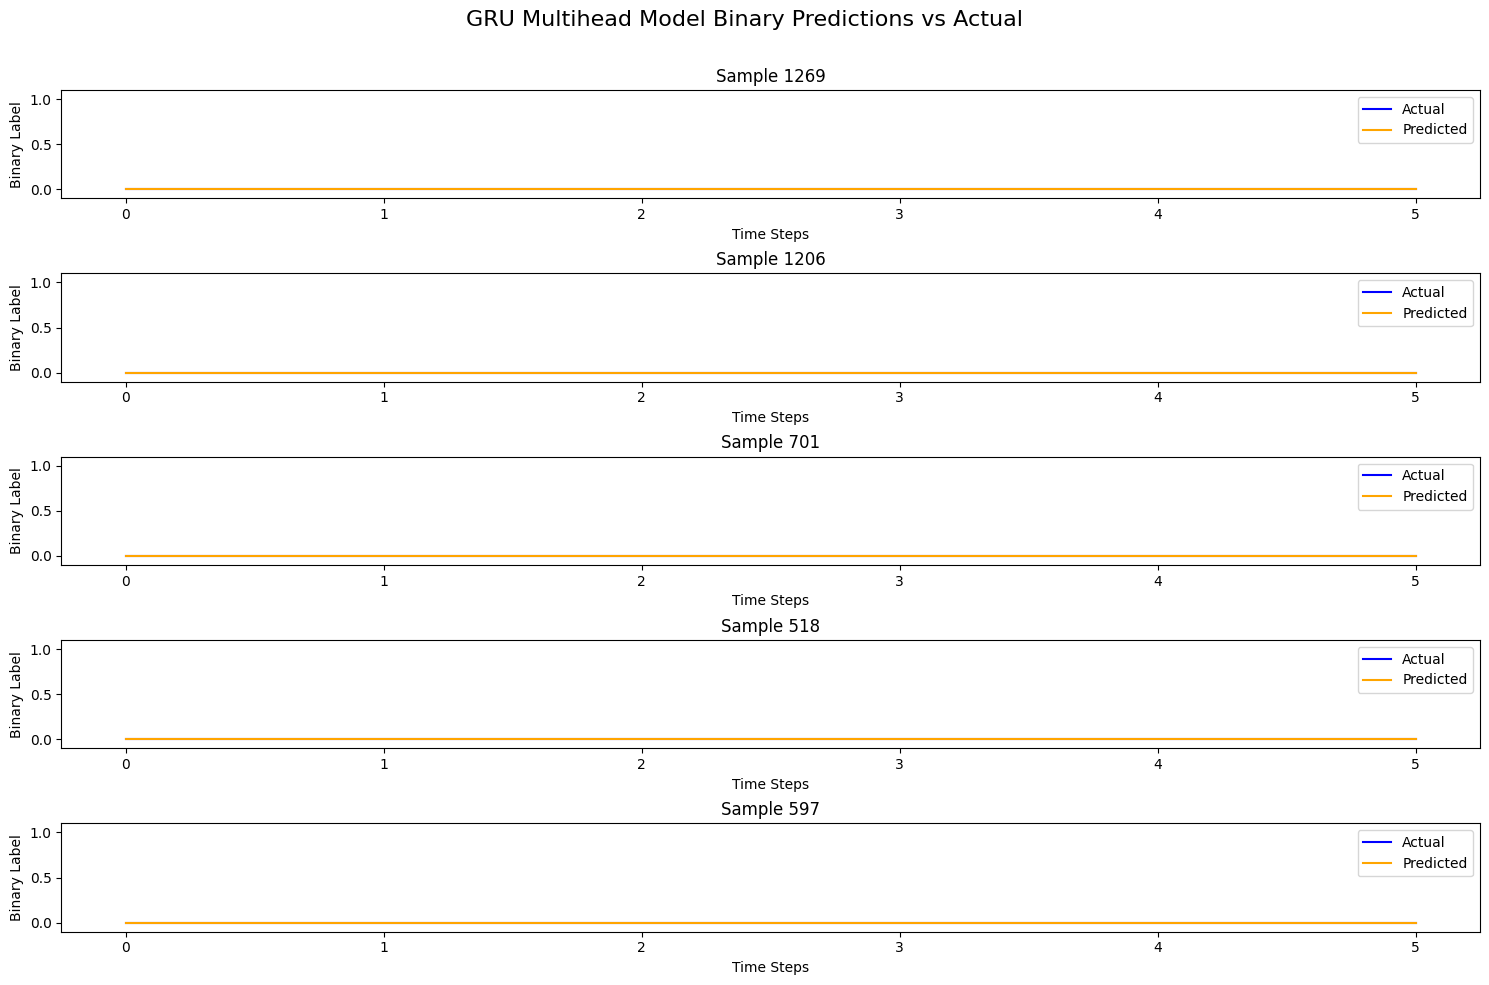

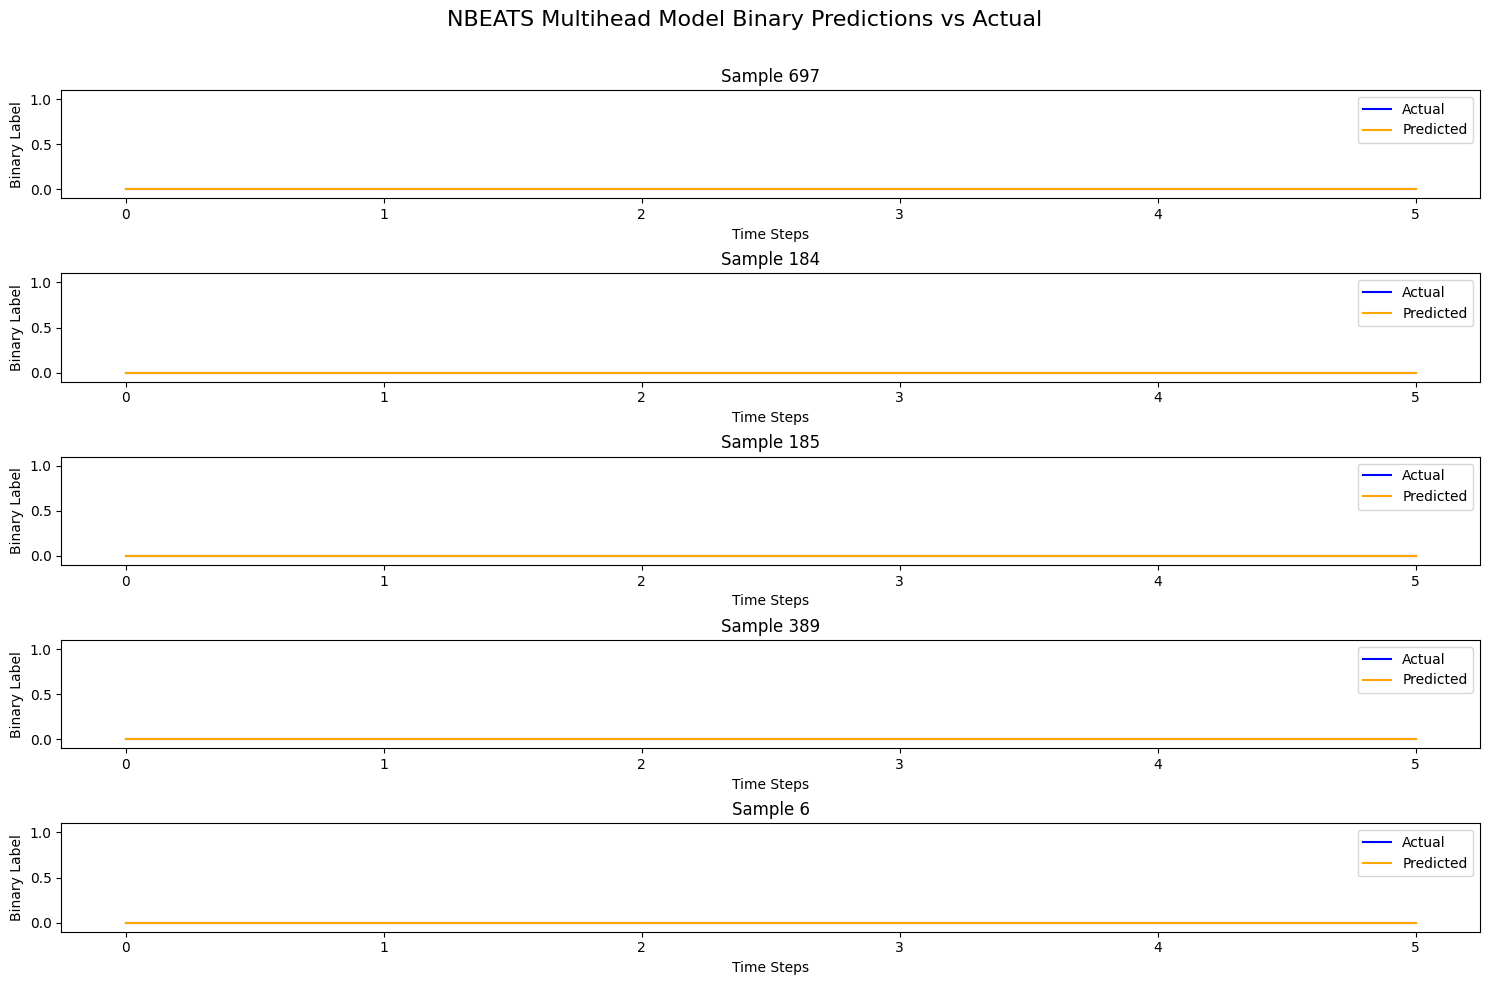

In [513]:
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import balanced_accuracy_score, average_precision_score, brier_score_loss
from scipy.special import expit
from sklearn.metrics import classification_report

# True labels (same shape as binary output)
y_test_binary = dataset.Y_test_target.astype(int)
true_labels = y_test_binary.flatten()

# ==========================
# GRU Multihead Evaluation
# ==========================

# Binary target probabilities and predictions
pred_target_gru_probs = pred_target_gru.squeeze(-1)  # (samples, horizon)
#pred_target_gru_binary = (pred_target_gru_probs >= 0.5).astype(int)
gru_probs = pred_target_gru_probs.flatten()
gru_preds = binary_preds_gru.flatten()
#print(dataset.Y_test_target)
#print(y_test_binary)
#print(np.unique(true_labels))
#print(np.unique(gru_preds))
best_threshold_gru, best_f1_gru = find_best_threshold(true_labels, gru_probs)
print(f"Best threshold for GRU: {best_threshold_gru:.2f}, Best F1-Score: {best_f1_gru:.4f}")

balanced_acc_gru = balanced_accuracy_score(true_labels, gru_preds)
pr_auc_gru = average_precision_score(true_labels, gru_probs)
brier_gru = brier_score_loss(true_labels, gru_probs)
accuracy_gru = metrics.accuracy_score(true_labels, gru_preds)
f1_gru = metrics.f1_score(true_labels, gru_preds, pos_label=1)

print(f"GRU Model - Balanced Accuracy: {balanced_acc_gru:.4f}, PR AUC: {pr_auc_gru:.4f}, Brier Score: {brier_gru:.4f}")
print(f"GRU Model - Accuracy: {accuracy_gru:.4f}, F1 Score: {f1_gru:.4f}")

print("GRU Model Classification Report:")
print(classification_report(true_labels, gru_preds, target_names=["Survived", "Died"]))


# ==========================
# N-BEATS Multihead Evaluation
# ==========================

pred_target_nbeats_probs = pred_target_nbeats.squeeze(-1)  # (samples, horizon)
#pred_target_nbeats_binary = (pred_target_nbeats_probs >= 0.5).astype(int)

nbeats_probs = pred_target_nbeats_probs.flatten()
nbeats_preds = binary_preds_nbeats.flatten()

best_threshold_nbeats, best_f1_nbeats = find_best_threshold(true_labels, nbeats_probs)
print(f"Best threshold for NBEATS: {best_threshold_nbeats:.2f}, Best F1-Score: {best_f1_nbeats:.4f}")

balanced_acc_nbeats = balanced_accuracy_score(true_labels, nbeats_preds)
pr_auc_nbeats = average_precision_score(true_labels, nbeats_probs)
brier_nbeats = brier_score_loss(true_labels, nbeats_probs)
accuracy_nbeats = metrics.accuracy_score(true_labels, nbeats_preds)
f1_nbeats = metrics.f1_score(true_labels, nbeats_preds, pos_label=1)

print(f"NBEATS Model - Balanced Accuracy: {balanced_acc_nbeats:.4f}, PR AUC: {pr_auc_nbeats:.4f}, Brier Score: {brier_nbeats:.4f}")
print(f"NBEATS Model - Accuracy: {accuracy_nbeats:.4f}, F1 Score: {f1_nbeats:.4f}")

print("NBEATS Model Classification Report:")
print(classification_report(true_labels, nbeats_preds, target_names=["Survived", "Died"]))

# ==========================
# Plotting
# ==========================

plot_binary_predictions(y_test_binary, pred_target_gru_binary, "gru_multihead", title='GRU Multihead Model Binary Predictions vs Actual')
plot_binary_predictions(y_test_binary, pred_target_nbeats_binary, "nbeats_multihead", title='NBEATS Multihead Model Binary Predictions vs Actual')


In [631]:
import numpy as np

print(f"=========== CF Generation Setup =============")
print(f"Non-survival probability threshold: {threshold}")
threshold = 0.5
# Convert from shape [N, H, 1] → [N, H]
preds = binary_preds_nbeats.squeeze(-1)
print(preds.shape, "SHAPE")

# Label as non-survival if more than 50% of time steps predict non-survival
threshold = 0.5
event_labels = np.where(preds.sum(axis=1) > (preds.shape[1] // 2), 1, 0)


# Get indices
survival_indices = np.where(event_labels == 0)[0]
non_survival_indices = np.where(event_labels == 1)[0]
# Class counts at each time step
class_counts = preds.sum(axis=0)  # number of non-survival (1s) per timestep
print("Non-survival predictions per timestep:", class_counts)

print("Event label breakdown:")
print(f"Survival samples: {len(survival_indices)}")
print(f"Non-survival samples: {len(non_survival_indices)}")

print(f"Survival indices shape: {survival_indices.shape}")
print(f"Non-survival indices shape: {non_survival_indices.shape}")

# Step 2: Select a subset for CF generation
rand_test_size = 100
test_group = "non-survival"  # or "survival"

if test_group == "survival":
    indices = survival_indices
elif test_group == "non-survival":
    indices = non_survival_indices
else:
    indices = np.arange(binary_preds_gru.shape[0])

np.random.seed(42)
if len(indices) >= rand_test_size:
    rand_test_idx = np.random.choice(indices, rand_test_size, replace=False)
else:
    rand_test_idx = indices

print(f"Generating CFs for {len(rand_test_idx)} samples in total, for {test_group} group...")

# Step 3: Define desired target probabilities
# For counterfactuals: non-survival → shift toward survival (label 0 → probability closer to 0.1)
desired_target_prob = 0.1 if test_group == "non-survival" else 0.9
desired_target_array = np.full((len(rand_test_idx),), desired_target_prob)

print(rand_test_idx)
print(f"Desired target probabilities set to {desired_target_prob} for counterfactual generation.")
# Step 4: Preparing inputs

indices = np.where(dataset.X_reg_target == 1)[0]

#Exog_test = dataset.X_reg_exog[rand_test_idx]
#Target_test = dataset.X_reg_target[rand_test_idx]
#print("Exog_test shape:", Exog_test.shape)
#print("Target_test shape:", Target_test)
#print("Target_test shape:", dataset.X_reg_target.shape)
Exog_test = pred_exog_gru[rand_test_idx]
Target_test = binary_preds_gru[rand_test_idx]
print(f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group...")

hist_inputs = []
assert rand_test_idx.max() < len(dataset.test_idxs), "Indexing mismatch!"

for i in range(len(rand_test_idx)):
    if rand_test_idx[i] >= len(dataset.test_idxs):
        print(f"Skipping index {i}, rand_test_idx out of test_idxs range.")
        continue
    idx = dataset.test_idxs[rand_test_idx[i]]
    if idx >= len(dataset.historical_values):
        print(f"Skipping index {i}, idx {idx} out of historical_values range.")
        continue
    hist_inputs.append(dataset.historical_values[idx])
print(rand_test_idx, indices)

=========== CF Generation Setup =============
Non-survival probability threshold: 0.5
(1332, 6) SHAPE
Non-survival predictions per timestep: [2 3 3 2 3 3]
Event label breakdown:
Survival samples: 1330
Non-survival samples: 2
Survival indices shape: (1330,)
Non-survival indices shape: (2,)
Generating CFs for 2 samples in total, for non-survival group...
[ 82 486]
Desired target probabilities set to 0.1 for counterfactual generation.
Generating CFs for 2 samples in total, for hyper test group...
[ 82 486] [   6    6    6    6    6    6    7    7    7    7    7    7    8    8
    8    8    8    8    9    9    9    9    9    9   10   10   10   10
   10   10   11   11   11   11   11   11   36   36   36   36   36   36
   37   37   37   37   37   37   38   38   38   38   38   38   39   39
   39   39   39   39   40   40   40   40   40   40   41   41   41   41
   41   41  204  204  204  204  204  204  205  205  205  205  205  205
  206  206  206  206  206  206  207  207  207  207  207  207  208

In [681]:
#print(pred_exog, pred_exog.shape)
X_test = np.concatenate((Target_test, Exog_test), axis=-1)
#print(X_test.shape)
pred_exog = pred_exog_gru
#print(pred_exog.shape)
clip_ranges = [[[0.0, 1.0]] * len(CHANGE_COLS)] * len(X_test)
opt = TimeSeriesOptimizer(
    method='sarimax',
    dataset=dataset,
    pred_exog=pred_exog,
    pred_tf=binary_preds_gru,
    rand_test_idx=rand_test_idx,
    back_horizon=back_horizon,
    horizon=horizon,
    target_col=0,
    change_cols=CHANGE_COLS,
    clip_ranges=clip_ranges,  # can be None
    hist_inputs=hist_inputs   # can be None
)

opt.optimize()


mimic_targets_sarimax = opt.targets
mimic_orig_targets_sarimax = opt.orig_targets
mimic_exogs_sarimax = opt.exogs
mimic_orig_exogs_sarimax = opt.orig_exogs
mimic_losses_sarimax = opt.losses
mimic_transformed_targets_sarimax = opt.transformed_targets
mimic_transformed_exogs_sarimax = opt.transformed_exogs
mimic_transformed_orig_targets_sarimax = opt.transformed_orig_targets
mimic_transformed_orig_exogs_sarimax = opt.transformed_orig_exogs


In [690]:
import numpy as np
import tensorflow as tf
import statsmodels.api as sm

class TimeSeriesOptimizer:
    def __init__(self, method, dataset, pred_exog, pred_tf, rand_test_idx, back_horizon, horizon, target_col, change_cols, clip_ranges=None, hist_inputs=None, step_weights='local'):
        self.method = method  # 'sarimax', 'ols', 'gru', or 'nbeats'
        self.dataset = dataset
        self.pred_exog = pred_exog
        self.pred_tf = pred_tf
        self.rand_test_idx = rand_test_idx
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.TARGET_COL = target_col
        self.CHANGE_COLS = change_cols
        self.learning_rate = 0.001
        
        self.pred_margin_weight = 1.0#pred_margin_weight
        self.weighted_steps_weight = 1 - self.pred_margin_weight
        
        self.MISSING_MAX_BOUND = np.inf
        self.MISSING_MIN_BOUND = -np.inf

        self.clip_range_inputs = clip_ranges
        self.hist_value_inputs = hist_inputs
        self.step_weights = step_weights
        
        self.targets = None
        self.orig_targets = None
        self.transformed_targets = None
        self.transformed_orig_targets = None
        self.transformed_exogs = None
        self.transformed_orig_exogs = None
        self.orig_exogs = None
        self.exogs = None
        self.losses = None
        self.model = None
        self.optimizer = None

        self._init_method()

    def _init_method(self):
        if self.method == 'sarimax':
            pass
        elif self.method == 'ols':
            pass
        elif self.method == 'gru':
            self._init_gru_model()
        elif self.method == 'nbeats':
            self._init_nbeats_model()
        else:
            raise ValueError(f"Unknown method: {self.method}")

    def _init_gru_model(self):
        X = self.dataset.X_reg_exog
        y = self.dataset.X_reg_target[:, self.TARGET_COL]
        X_val = self.dataset.X_reg_val_exog
        y_val = self.dataset.X_reg_val_target[:, self.TARGET_COL]

        in_features = X.shape[2]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.horizon, in_features)),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=True),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=False),
            tf.keras.layers.Dense(self.horizon, activation='linear'),
            tf.keras.layers.Reshape((self.horizon, 1))
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, epsilon=1e-07)
        self.model.compile(optimizer=self.optimizer, loss='mae')
        self.model.fit(X, y, epochs=5, batch_size=64,
                       validation_data=(X_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)])

    def _init_nbeats_model(self):
        horizon = self.horizon

        class NBeatsBlock(tf.keras.layers.Layer):
            def __init__(self, units, horizon):
                super().__init__()
                self.fc1 = tf.keras.layers.Dense(units, activation='relu')
                self.fc2 = tf.keras.layers.Dense(units, activation='relu')
                self.fc3 = tf.keras.layers.Dense(units, activation='relu')
                self.fc4 = tf.keras.layers.Dense(units, activation='relu')
                self.forecast = tf.keras.layers.Dense(horizon)

            def call(self, inputs):
                x = self.fc1(inputs)
                x = self.fc2(x)
                x = self.fc3(x)
                x = self.fc4(x)
                return self.forecast(x)

        class DifferentiableNBeats(tf.keras.Model):
            def __init__(self, horizon, units=128):
                super().__init__()
                self.flatten = tf.keras.layers.Flatten()
                self.block = NBeatsBlock(units, horizon)

            def call(self, x):
                x = self.flatten(x)
                return self.block(x)

        self.model = DifferentiableNBeats(horizon=self.horizon, units=128)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mae')

    def margin_mse(self, pred):
        """
        Loss to push predictions toward 0 (survival).
        """
        target = tf.zeros_like(pred)
        mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        return mse(target, pred)

    def weighted_ape(self, original_per_feature, cf_per_feature, step_weights):
        denum = tf.math.maximum(tf.math.abs(original_per_feature), tf.keras.backend.epsilon())
        ape_score = tf.math.abs(original_per_feature - cf_per_feature) / denum
        weighted_ape = tf.math.multiply(ape_score, step_weights)
        return tf.reduce_mean(weighted_ape)
        

    def compute_loss(self, original_sample, exog_search, step_weights):
        """
        Compute total loss: prediction margin + step-weighted APE.
        This version assumes binary targets (i.e., we want pred close to 0).
        """
        if self.method == 'sarimax':
            temp = exog_search.numpy()
            pred = self.model.forecast(self.horizon, start_params=self.model.params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        elif self.method == 'ols':
            temp = exog_search.numpy()
            pred = self.model.predict(temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        else:
            raise ValueError("Method must be 'sarimax' or 'ols' for this loss.")
    
        forecast_margin_loss = self.margin_mse(pred)
    
        loss = tf.cast(self.pred_margin_weight, tf.float32) * forecast_margin_loss
    
        for d_idx, col_idx in enumerate(self.CHANGE_COLS):
            weighted_steps_loss = self.weighted_ape(
                tf.cast(original_sample[:, :, d_idx], tf.float32),
                tf.cast(exog_search[:, :, d_idx], tf.float32),
                tf.cast(step_weights[:, :, d_idx], tf.float32),
            )
            loss += tf.cast(self.weighted_steps_weight, tf.float32) * weighted_steps_loss
    
        return loss, forecast_margin_loss, weighted_steps_loss

    # def compute_loss(self, pred, X_e, X_orig, lambda_reg=1.0):
    #     """
    #     Loss pushing prediction toward 0 (survival),
    #     plus regularization penalizing large changes in X_e.
        
    #     Args:
    #         pred: predicted tensor (shape horizon,)
    #         X_e: current exogenous input tensor being optimized (shape: horizon x features)
    #         X_orig: original exogenous input tensor (same shape as X_e)
    #         lambda_reg: regularization weight (float)
    #     Returns:
    #         scalar loss tensor
    #     """
    #     target = tf.zeros_like(pred)  # want pred close to 0 (survival)
    #     mse = tf.keras.losses.MeanSquaredError()
    #     pred_loss = mse(target, pred)
        
    #     # Regularization: L2 norm squared of difference between current and original exog
    #     reg_loss = lambda_reg * tf.reduce_sum(tf.square(X_e - X_orig))
        
    #     return pred_loss + reg_loss
    


       def compute_gradient_finite_difference(self, model, X_e, max_bound, min_bound, epsilon=1e-4):
        # Used for SARIMAX and OLS only
        original_pred = None
        if self.method == 'sarimax':
            temp = X_e.numpy()
            pred = model.forecast(self.horizon, start_params=model.params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred
        elif self.method == 'ols':
            temp = X_e.numpy()
            pred = model.predict(temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred

        original_loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
            tf.expand_dims(X_e.numpy(), axis=0),     # original_sample
            tf.expand_dims(X_e.numpy(), axis=0),     # z_search (original = current)
            tf.expand_dims(self.step_weights, axis=0),  # step_weights
            max_bound,
            min_bound
        )

        gradients = np.zeros_like(X_e.numpy())
        for i in range(X_e.shape[0]):
            X_e_perturbed = X_e.numpy()
            X_e_perturbed[i] += epsilon

            if self.method == 'sarimax':
                pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
            elif self.method == 'ols':
                pred_perturbed = model.predict(X_e_perturbed)
            pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

            perturbed_loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                tf.expand_dims(X_e_perturbed, axis=0),
                tf.expand_dims(X_e_perturbed, axis=0),
                tf.expand_dims(self.step_weights, axis=0),
                max_bound,
                min_bound
            )
            gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

        return gradients

    # def compute_gradient_finite_difference(self, model, X_e, X_orig, epsilon=1e-4, lambda_reg=1.0):
    #     """
    #     Finite difference gradient of loss wrt X_e,
    #     pushing prediction toward 0 and penalizing large input changes.
        
    #     Args:
    #         model: fitted model (SARIMAX or OLS)
    #         X_e: current tf.Variable exogenous input (shape horizon x features)
    #         X_orig: original exogenous input (numpy or tf.Tensor)
    #         epsilon: small perturbation for finite difference
    #         lambda_reg: regularization weight
    #     Returns:
    #         numpy array gradient (same shape as X_e)
    #     """
    #     X_e_np = X_e.numpy()
    #     if self.method == 'sarimax':
    #         pred = model.forecast(self.horizon, start_params=model.params, exog=X_e_np)
    #     elif self.method == 'ols':
    #         pred = model.predict(X_e_np)
    #     else:
    #         raise ValueError("Finite difference gradient only for sarimax or ols")
    
    #     pred = tf.convert_to_tensor(pred, dtype=tf.float32)
    #     original_loss = self.compute_loss(pred, X_e, X_orig, lambda_reg).numpy()
    
    #     gradients = np.zeros_like(X_e_np)
    
    #     # perturb each element separately to estimate gradient
    #     for i in range(X_e_np.shape[0]):
    #         for j in range(X_e_np.shape[1]):
    #             X_e_perturbed = X_e_np.copy()
    #             X_e_perturbed[i, j] += epsilon
    
    #             if self.method == 'sarimax':
    #                 pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
    #             elif self.method == 'ols':
    #                 pred_perturbed = model.predict(X_e_perturbed)
    
    #             pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)
    #             perturbed_loss = self.compute_loss(pred_perturbed, tf.convert_to_tensor(X_e_perturbed, dtype=tf.float32), X_orig, lambda_reg).numpy()
    
    #             gradients[i, j] = (perturbed_loss - original_loss) / epsilon
    
    #     return gradients

    def optimize(self):
        length = len(self.rand_test_idx)
        self.targets = np.empty((length, self.horizon))
        self.orig_targets = np.empty((length, self.horizon))
        self.transformed_targets = np.empty((length, self.horizon))
        self.transformed_orig_targets = np.empty((length, self.horizon))
        self.transformed_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.transformed_orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.losses = np.empty(length)

        for idx_i, idx in enumerate(self.rand_test_idx):
            clip_ranges = self.clip_range_inputs[idx_i] if self.clip_range_inputs else None
            hist_values = self.hist_value_inputs[idx_i] if self.hist_value_inputs else None
            #if self.step_weights in ["meal", "meal_time"]:
            #    step_weights = get_meal_weights(self.pred_exog[idx_i])
            #else:
            step_weights = np.zeros(self.pred_exog[idx_i].shape)
            self.step_weights = step_weights

            if self.method == 'sarimax':
                self._optimize_sarimax(idx, idx_i, clip_ranges, hist_values)
            elif self.method == 'ols':
                self._optimize_ols(idx, idx_i, clip_ranges, hist_values)
            elif self.method == 'gru':
                self._optimize_gru(idx, idx_i, clip_ranges, hist_values)
            elif self.method == 'nbeats':
                self._optimize_nbeats(idx, idx_i, clip_ranges, hist_values)
            else:
                raise ValueError(f"Unknown method: {self.method}")

    def _optimize_sarimax(self, sample_idx, loop_idx, clip_ranges, hist_values):
        X = self.dataset.X_reg_exog[sample_idx]
        y = self.dataset.X_reg_target[sample_idx][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[sample_idx]

        if clip_ranges:
            clip_lows = tf.constant([low for low, _ in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([high for _, high in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, -1))
            clip_highs = tf.reshape(clip_highs, (1, -1))
            
            def per_feature_clip(x):
                return tf.clip_by_value(x, clip_lows, clip_highs)
            
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32, constraint=per_feature_clip)    
        else:
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)
        mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1, 0, 0))
        mod = mod.fit(disp=False)

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        max_iter = 100
        it = 0

        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[t, d_idx] - hist_values[feat_idx])
                    if tf.reduce_min(dist) <= threshold_close:
                        self.step_weights[t, d_idx] = 1.0
                    else:
                        self.step_weights[t, d_idx] = 0.0
        
        pred = mod.forecast(self.horizon, start_params=mod.params, exog=grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        
        while tf.reduce_mean(pred) > 0.0 and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=0.1)
            #print("Gradients", gradients)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
            #print("grad_X_e", grad_X_e)
            pred = mod.forecast(self.horizon, start_params=mod.params, exog=grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            it += 1

        target_scaler = self.dataset.scaler[self.TARGET_COL]
        predicted_transformed_target = target_scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = target_scaler.inverse_transform(self.pred_tf[sample_idx].reshape(-1, 1))

        transformed_exogs = []
        transformed_orig_exogs = []

        num_features = self.dataset.X_reg_exog.shape[2] 
        
        for j, col in enumerate(self.CHANGE_COLS):
            exog_scaler = self.dataset.scaler[col]
            transformed = exog_scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = exog_scaler.inverse_transform(self.pred_exog[sample_idx][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
            
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
        self.targets[loop_idx] = pred.numpy()
        self.orig_targets[loop_idx] = self.pred_tf[sample_idx].squeeze()
        self.transformed_targets[loop_idx] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[loop_idx] = orig_transformed_target.squeeze()
        self.transformed_exogs[loop_idx] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[loop_idx] = predicted_transformed_orig_exogs.squeeze()
        self.orig_exogs[loop_idx] = self.pred_exog[sample_idx]
        self.exogs[loop_idx] = grad_X_e.numpy().squeeze()
        self.losses[loop_idx] = self.compute_loss(pred, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=1.0).numpy()

    
    def _optimize_ols(self, sample_idx, loop_idx, clip_ranges, hist_values):
        X = self.dataset.X_reg_exog[sample_idx]
        y = self.dataset.X_reg_target[sample_idx][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[sample_idx]
    
        if clip_ranges:
            clip_lows = tf.constant([low for low, _ in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([high for _, high in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, -1))
            clip_highs = tf.reshape(clip_highs, (1, -1))
            
            def per_feature_clip(x):
                return tf.clip_by_value(x, clip_lows, clip_highs)
            
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32, constraint=per_feature_clip)    
        else:
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)
    
        mod = sm.OLS(endog=np.asarray(y), exog=np.asarray(X)).fit()
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        max_iter = 100
        it = 0

        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[t, d_idx] - hist_values[feat_idx])
                    if tf.reduce_min(dist) <= threshold_close:
                        self.step_weights[t, d_idx] = 1.0
                    else:
                        self.step_weights[t, d_idx] = 0.0

        pred = mod.predict(grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)
    
        while tf.reduce_mean(pred) > 0.0 and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=0.1)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
            pred = mod.predict(grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            it += 1
    
        # Record results (like SARIMAX)
        target_scaler = self.dataset.scaler[self.TARGET_COL]
        predicted_transformed_target = target_scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = target_scaler.inverse_transform(self.pred_tf[sample_idx].reshape(-1, 1))
    
        transformed_exogs = []
        transformed_orig_exogs = []
    
        for j, col in enumerate(self.CHANGE_COLS):
            exog_scaler = self.dataset.scaler[col]
            transformed = exog_scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = exog_scaler.inverse_transform(pred_exog_sample[:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
    
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
    
        self.targets[loop_idx] = pred.numpy()
        self.orig_targets[loop_idx] = self.pred_tf[sample_idx].squeeze()
        self.transformed_targets[loop_idx] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[loop_idx] = orig_transformed_target.squeeze()
        self.transformed_exogs[loop_idx] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[loop_idx] = predicted_transformed_orig_exogs.squeeze()
        self.orig_exogs[loop_idx] = pred_exog_sample
        self.exogs[loop_idx] = grad_X_e.numpy().squeeze()
        self.losses[loop_idx] = self.compute_loss(pred, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=1.0).numpy()


    def _optimize_gru(self, sample_idx, loop_idx, clip_ranges, hist_values):
        pred_exog_sample = self.pred_exog[sample_idx]
        pred_exog_sample_batched = pred_exog_sample[None, :, :]

        if clip_ranges:
            clip_lows = tf.constant([clip[0] for clip in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([clip[1] for clip in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, 1, -1))
            clip_highs = tf.reshape(clip_highs, (1, 1, -1))
    
            def per_feature_clip(x):
                return tf.clip_by_value(x, clip_lows, clip_highs)
    
            grad_X_e = tf.Variable(pred_exog_sample_batched, dtype=tf.float32, constraint=per_feature_clip)
        else:
            grad_X_e = tf.Variable(pred_exog_sample_batched, dtype=tf.float32)

        #grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)
        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[0, t, d_idx] - hist_values[feat_idx])
                    if tf.reduce_min(dist) <= threshold_close:
                        step_weights = tf.tensor_scatter_nd_update(
                            self.step_weights,
                            indices=[[0, t, d_idx]],
                            updates=[1.0]
                        )
                    else:
                        step_weights = tf.tensor_scatter_nd_update(
                            self.step_weights,
                            indices=[[0, t, d_idx]],
                            updates=[0.0]
                        )

        pred = self.model(grad_X_e)[0, :, 0]
        loss = self.compute_loss(pred, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=0.1)
          
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        max_iter = 100
        it = 0
    
        while tf.reduce_mean(pred) > 0.0 and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(grad_X_e)[0, :, 0]
                loss = self.compute_loss(pred, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=0.1)
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
            it += 1
    
        target_scaler = self.dataset.scaler[self.TARGET_COL]
        predicted_transformed_target = target_scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = target_scaler.inverse_transform(self.pred_tf[loop_idx].reshape(-1, 1))
    
        transformed_exogs = []
        transformed_orig_exogs = []
    
        for j, col in enumerate(self.CHANGE_COLS):
            exog_scaler = self.dataset.scaler[col]
            transformed = exog_scaler.inverse_transform(grad_X_e.numpy()[0, :, j].reshape(-1, 1))
            transformed_orig = exog_scaler.inverse_transform(pred_exog_sample[:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
    
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
    
        self.targets[loop_idx] = pred.numpy()
        self.orig_targets[loop_idx] = self.pred_tf[sample_idx].squeeze()
        self.transformed_targets[loop_idx] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[loop_idx] = orig_transformed_target.squeeze()
        self.transformed_exogs[loop_idx] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[loop_idx] = predicted_transformed_orig_exogs.squeeze()
        self.orig_exogs[loop_idx] = pred_exog_sample
        self.exogs[loop_idx] = grad_X_e.numpy().squeeze()
        self.losses[loop_idx] = loss.numpy()

    def _optimize_nbeats(self, sample_idx, loop_idx, clip_ranges, hist_values):
        pred_exog_sample = self.pred_exog[sample_idx]
        pred_exog_sample_batched = pred_exog_sample[None, :, :]  # Add batch dim
        
        if clip_ranges:
            clip_lows = tf.constant([low for low, _ in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([high for _, high in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, 1, -1))
            clip_highs = tf.reshape(clip_highs, (1, 1, -1))
            
            def per_feature_clip(x):
                return tf.clip_by_value(x, clip_lows, clip_highs)
            
            grad_X_e = tf.Variable(pred_exog_sample_batched, dtype=tf.float32, constraint=per_feature_clip)
        else:
            grad_X_e = tf.Variable(pred_exog_sample_batched, dtype=tf.float32)

        #grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)
    
        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0]
        loss = self.compute_loss(pred, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=0.1)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        max_iter = 100
        it = 0

        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[0, t, d_idx] - hist_values[feat_idx])
                    if tf.reduce_min(dist) <= threshold_close:
                        self.step_weights[t, d_idx] = 1.0
                    else:
                        self.step_weights[t, d_idx] = 0.0

        
        while tf.reduce_mean(pred) > 0.0 and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0]
                loss = self.compute_loss(pred, grad_X_e, tf.convert_to_tensor(pred_exog_sample, dtype=tf.float32), lambda_reg=0.1)
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
            it += 1
    
        target_scaler = self.dataset.scaler[self.TARGET_COL]
        predicted_transformed_target = target_scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = target_scaler.inverse_transform(self.pred_tf[loop_idx].reshape(-1, 1))
    
        transformed_exogs = []
        transformed_orig_exogs = []
    
        for j, col in enumerate(self.CHANGE_COLS):
            exog_scaler = self.dataset.scaler[col]
            transformed = exog_scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = exog_scaler.inverse_transform(pred_exog_sample[:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
    
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
    
        self.targets[loop_idx] = pred.numpy()
        self.orig_targets[loop_idx] = self.pred_tf[sample_idx].squeeze()
        self.transformed_targets[loop_idx] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[loop_idx] = orig_transformed_target.squeeze()
        self.transformed_exogs[loop_idx] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[loop_idx] = predicted_transformed_orig_exogs.squeeze()
        self.orig_exogs[loop_idx] = pred_exog_sample
        self.exogs[loop_idx] = grad_X_e.numpy().squeeze()
        self.losses[loop_idx] = loss.numpy()



In [691]:
def create_clip_ranges(X_test, change_cols, low=0.0, high=1.0):
    return [[[low, high] for _ in change_cols] for _ in range(len(X_test))]

def run_optimization(method, dataset, pred_exog, pred_tf, rand_test_idx, back_horizon, horizon, target_col, change_cols, clip_ranges=None, hist_inputs=None):
    optimizer = TimeSeriesOptimizer(
        method=method,
        dataset=dataset,
        pred_exog=pred_exog,
        pred_tf=pred_tf,
        rand_test_idx=rand_test_idx,
        back_horizon=back_horizon,
        horizon=horizon,
        target_col=0,#target_col,???
        change_cols=change_cols,
        clip_ranges=clip_ranges,
        hist_inputs=hist_inputs
    )
    optimizer.optimize()
    return {
        'targets': optimizer.targets,
        'orig_targets': optimizer.orig_targets,
        'exogs': optimizer.exogs,
        'orig_exogs': optimizer.orig_exogs,
        'losses': optimizer.losses,
        'transformed_targets': optimizer.transformed_targets,
        'transformed_exogs': optimizer.transformed_exogs,
        'transformed_orig_targets': optimizer.transformed_orig_targets,
        'transformed_orig_exogs': optimizer.transformed_orig_exogs,
    }

# Example usage for SARIMAX
X_test = np.concatenate((Target_test, Exog_test), axis=-1)
clip_ranges = create_clip_ranges(X_test, CHANGE_COLS, low=0.0, high=1.0)

# results_sarimax = run_optimization(
#     method='sarimax',
#     dataset=dataset,
#     pred_exog=pred_exog_nbeats,
#     pred_tf=binary_preds_nbeats,
#     rand_test_idx=rand_test_idx,
#     back_horizon=back_horizon,
#     horizon=horizon,
#     target_col=0,
#     change_cols=CHANGE_COLS,
#     clip_ranges=clip_ranges,
#     hist_inputs=hist_inputs
# )

# # For OLS
# results_ols = run_optimization(
#     method='ols',
#     dataset=dataset,
#     pred_exog=pred_exog_nbeats,
#     pred_tf=binary_preds_nbeats,
#     rand_test_idx=rand_test_idx,
#     back_horizon=back_horizon,
#     horizon=horizon,
#     target_col=0,
#     change_cols=CHANGE_COLS,
#     clip_ranges=clip_ranges,
#     hist_inputs=hist_inputs
# )

# For GRU
results_gru = run_optimization(
    method='gru',
    dataset=dataset,
    pred_exog=pred_exog_nbeats,
    pred_tf=binary_preds_nbeats,
    rand_test_idx=rand_test_idx,
    back_horizon=back_horizon,
    horizon=horizon,
    target_col=0,
    change_cols=CHANGE_COLS,
    clip_ranges=None,  # GRU optimization may not use clip_ranges
    hist_inputs=None
)

# For NBeats
# results_nbeats = run_optimization(
#     method='nbeats',
#     dataset=dataset,
#     pred_exog=pred_exog_nbeats,
#     pred_tf=binary_preds_nbeats,
#     rand_test_idx=rand_test_idx,
#     back_horizon=back_horizon,
#     horizon=horizon,
#     target_col=0,
#     change_cols=CHANGE_COLS,
#     clip_ranges=None,
#     hist_inputs=None
# )


Epoch 1/5


2025-07-21 16:26:38.428176: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


21/21 [==============================] - 5s 56ms/step - loss: 0.1468 - val_loss: 0.1072
Epoch 2/5
21/21 [==============================] - 0s 16ms/step - loss: 0.0944 - val_loss: 0.0982
Epoch 3/5
21/21 [==============================] - 0s 18ms/step - loss: 0.0895 - val_loss: 0.0807
Epoch 4/5
21/21 [==============================] - 0s 18ms/step - loss: 0.0936 - val_loss: 0.0822
Epoch 5/5
21/21 [==============================] - 0s 17ms/step - loss: 0.0945 - val_loss: 0.0764


In [651]:
import matplotlib.pyplot as plt
import numpy as np

class TimeSeriesBaseline:
    def __init__(self, dataset, pred_exog, pred_tf, rand_test_idx, horizon, target_col, change_cols):
        self.dataset = dataset
        self.pred_exog = pred_exog
        self.pred_tf = pred_tf
        self.rand_test_idx = rand_test_idx
        self.horizon = horizon
        self.TARGET_COL = target_col
        self.CHANGE_COLS = change_cols

        # Initialize output arrays
        self.targets = np.empty((len(rand_test_idx), horizon))
        self.orig_targets = np.empty((len(rand_test_idx), horizon))
        self.transformed_targets = np.empty((len(rand_test_idx), horizon))
        self.transformed_orig_targets = np.empty((len(rand_test_idx), horizon))
        self.transformed_exogs = np.empty((len(rand_test_idx), horizon, pred_exog.shape[2]))
        self.transformed_orig_exogs = np.empty((len(rand_test_idx), horizon, pred_exog.shape[2]))
        self.orig_exogs = np.empty((len(rand_test_idx), horizon, pred_exog.shape[2]))
        self.exogs = np.empty((len(rand_test_idx), horizon, pred_exog.shape[2]))
        self.losses = np.empty(len(rand_test_idx))

    def run(self):
        for i, idx in enumerate(self.rand_test_idx):
            pred = self.pred_tf[idx].squeeze()
            orig_exog = self.pred_exog[idx]

            # Dummy loss: distance from zero
            target = np.zeros_like(pred)
            loss = np.mean((pred - target) ** 2)

            # Unnormalize targets
            target_scaler = self.dataset.scaler[self.TARGET_COL]
            transformed_target = target_scaler.inverse_transform(pred.reshape(-1, 1)).squeeze()
            transformed_orig_target = target_scaler.inverse_transform(self.pred_tf[idx].reshape(-1, 1)).squeeze()

            # Unnormalize exogs
            transformed_exogs = []
            transformed_orig_exogs = []

            for j, col in enumerate(self.CHANGE_COLS):
                exog_scaler = self.dataset.scaler[col]
                transformed = exog_scaler.inverse_transform(orig_exog[:, j].reshape(-1, 1))
                transformed_orig = exog_scaler.inverse_transform(orig_exog[:, j].reshape(-1, 1))
                transformed_exogs.append(transformed)
                transformed_orig_exogs.append(transformed_orig)

            self.targets[i] = pred
            self.orig_targets[i] = pred
            self.transformed_targets[i] = transformed_target
            self.transformed_orig_targets[i] = transformed_orig_target
            self.transformed_exogs[i] = np.hstack(transformed_exogs)
            self.transformed_orig_exogs[i] = np.hstack(transformed_orig_exogs)
            self.orig_exogs[i] = orig_exog
            self.exogs[i] = orig_exog
            self.losses[i] = loss

    def compare_to_counterfactual(self, cf_model):
        """
        Compare average losses and prediction values with the counterfactual model.
        """
        print("\n🔍 Comparison to Counterfactual Optimization")
        print("------------------------------------------------")
        print(f"Average Baseline Loss:         {np.mean(self.losses):.4f}")
        print(f"Average Counterfactual Loss:   {np.mean(cf_model['losses']):.4f}")
        print(f"Mean Baseline Prediction:      {np.mean(self.targets):.4f}")
        print(f"Mean Counterfactual Prediction:{np.mean(cf_model['targets']):.4f}")

    def plot_example(self, i, cf_model=None):
        """
        Plot one example: baseline vs counterfactual targets.
        """
        plt.figure(figsize=(12, 5))
        plt.plot(self.transformed_targets[i], label="Baseline Prediction", linestyle='--', color='gray')
        plt.plot(self.transformed_orig_targets[i], label="Original Prediction", color='blue')

        if cf_model:
            plt.plot(cf_model['transformed_targets'][i], label="Counterfactual Prediction", color='green')

        plt.axhline(y=0, color='red', linestyle=':', label='Target = 0')
        plt.title(f"Example {i} – Horizon {self.horizon}")
        plt.xlabel("Time Step")
        plt.ylabel("Target (Unnormalized)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_exogenous_example(self, i, cf_model=None):
        """
        Plot each exogenous variable for one example: baseline vs counterfactual vs original.
        """
        num_exogs = len(self.CHANGE_COLS)
        plt.figure(figsize=(12, 3 * num_exogs))

        for j in range(num_exogs):
            plt.subplot(num_exogs, 1, j + 1)
            plt.plot(self.transformed_exogs[i, :, j], label='Baseline Exog', linestyle='--', color='gray')
            plt.plot(self.transformed_orig_exogs[i, :, j], label='Original Exog', color='blue')

            if cf_model is not None:
                plt.plot(cf_model['transformed_exogs'][i][:, j], label='Counterfactual Exog', color='green')

            col_name = self.dataset.columns[self.CHANGE_COLS[j]] if hasattr(self.dataset, 'columns') else f'Feature {self.CHANGE_COLS[j]}'
            plt.title(f"Exogenous Feature {col_name}")
            plt.xlabel("Time Step")
            plt.ylabel("Value (Unnormalized)")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()


Epoch 1/200


2025-07-21 13:32:58.122842: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


21/21 [==============================] - 5s 64ms/step - loss: 0.2024 - val_loss: 0.1078
Epoch 2/200
21/21 [==============================] - 0s 17ms/step - loss: 0.1050 - val_loss: 0.0885
Epoch 3/200
21/21 [==============================] - 0s 17ms/step - loss: 0.0987 - val_loss: 0.0813
Epoch 4/200
21/21 [==============================] - 0s 19ms/step - loss: 0.0851 - val_loss: 0.0712
Epoch 5/200
21/21 [==============================] - 0s 17ms/step - loss: 0.0844 - val_loss: 0.0879
Epoch 6/200
21/21 [==============================] - 0s 16ms/step - loss: 0.0871 - val_loss: 0.0757
Epoch 7/200
21/21 [==============================] - 0s 18ms/step - loss: 0.0819 - val_loss: 0.0928
Epoch 8/200
21/21 [==============================] - 0s 18ms/step - loss: 0.0850 - val_loss: 0.0898
Epoch 9/200
21/21 [==============================] - 0s 16ms/step - loss: 0.0757 - val_loss: 0.0740
Epoch 10/200
21/21 [==============================] - 0s 18ms/step - loss: 0.0792 - val_loss: 0.0698
Epoch 11/20

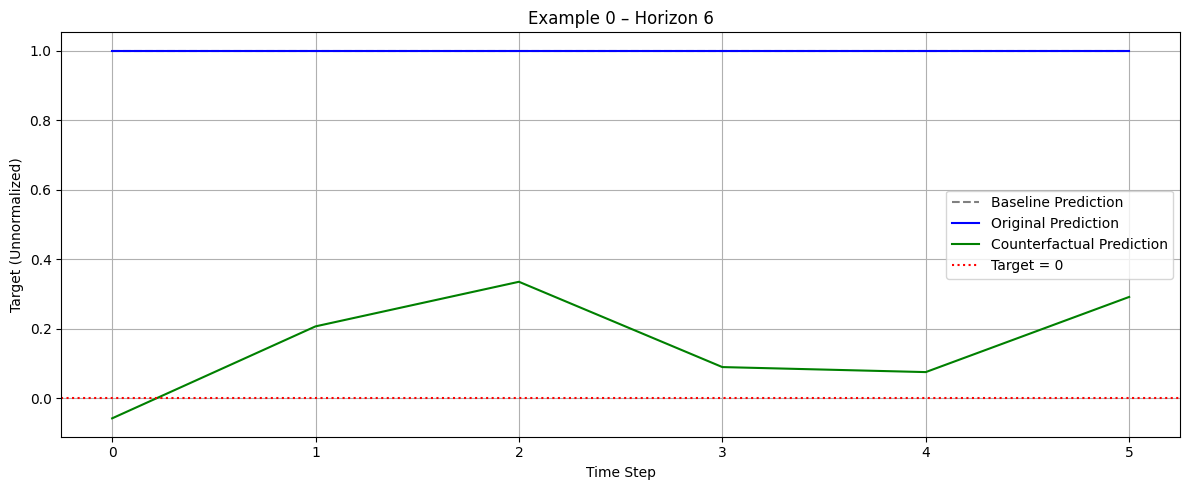

In [653]:
# Suppose dataset.test_idxs contains global test indices (shape: [510])
global_to_local = {global_idx: local_idx for local_idx, global_idx in enumerate(dataset.test_idxs)}

# Map rand_test_idx (global) to local indices
mapped_rand_test_idx = [global_to_local[idx] for idx in rand_test_idx if idx in global_to_local]
#assert max(mapped_rand_test_idx) < pred_tf.shape[0], "Mapped index out of bounds!"
#assert min(mapped_rand_test_idx) >= 0, "Mapped index is negative!"

# Initialize and run baseline
baseline = TimeSeriesBaseline(dataset, pred_exog_nbeats, binary_preds_nbeats, rand_test_idx, horizon, TARGET_COL, CHANGE_COLS)
baseline.run()

# Run your counterfactual model
cf_model = run_optimization(
    method='gru',
    dataset=dataset,
    pred_exog=pred_exog_nbeats,
    pred_tf=binary_preds_nbeats,
    rand_test_idx=rand_test_idx,
    back_horizon=back_horizon,
    horizon=horizon,
    target_col=0,
    change_cols=CHANGE_COLS,
    clip_ranges=None,  # GRU optimization may not use clip_ranges
    hist_inputs=None
)

# Compare
baseline.compare_to_counterfactual(cf_model)

# Plot specific example
r = random.randint(0, 1)
baseline.plot_example(i=r, cf_model=cf_model)


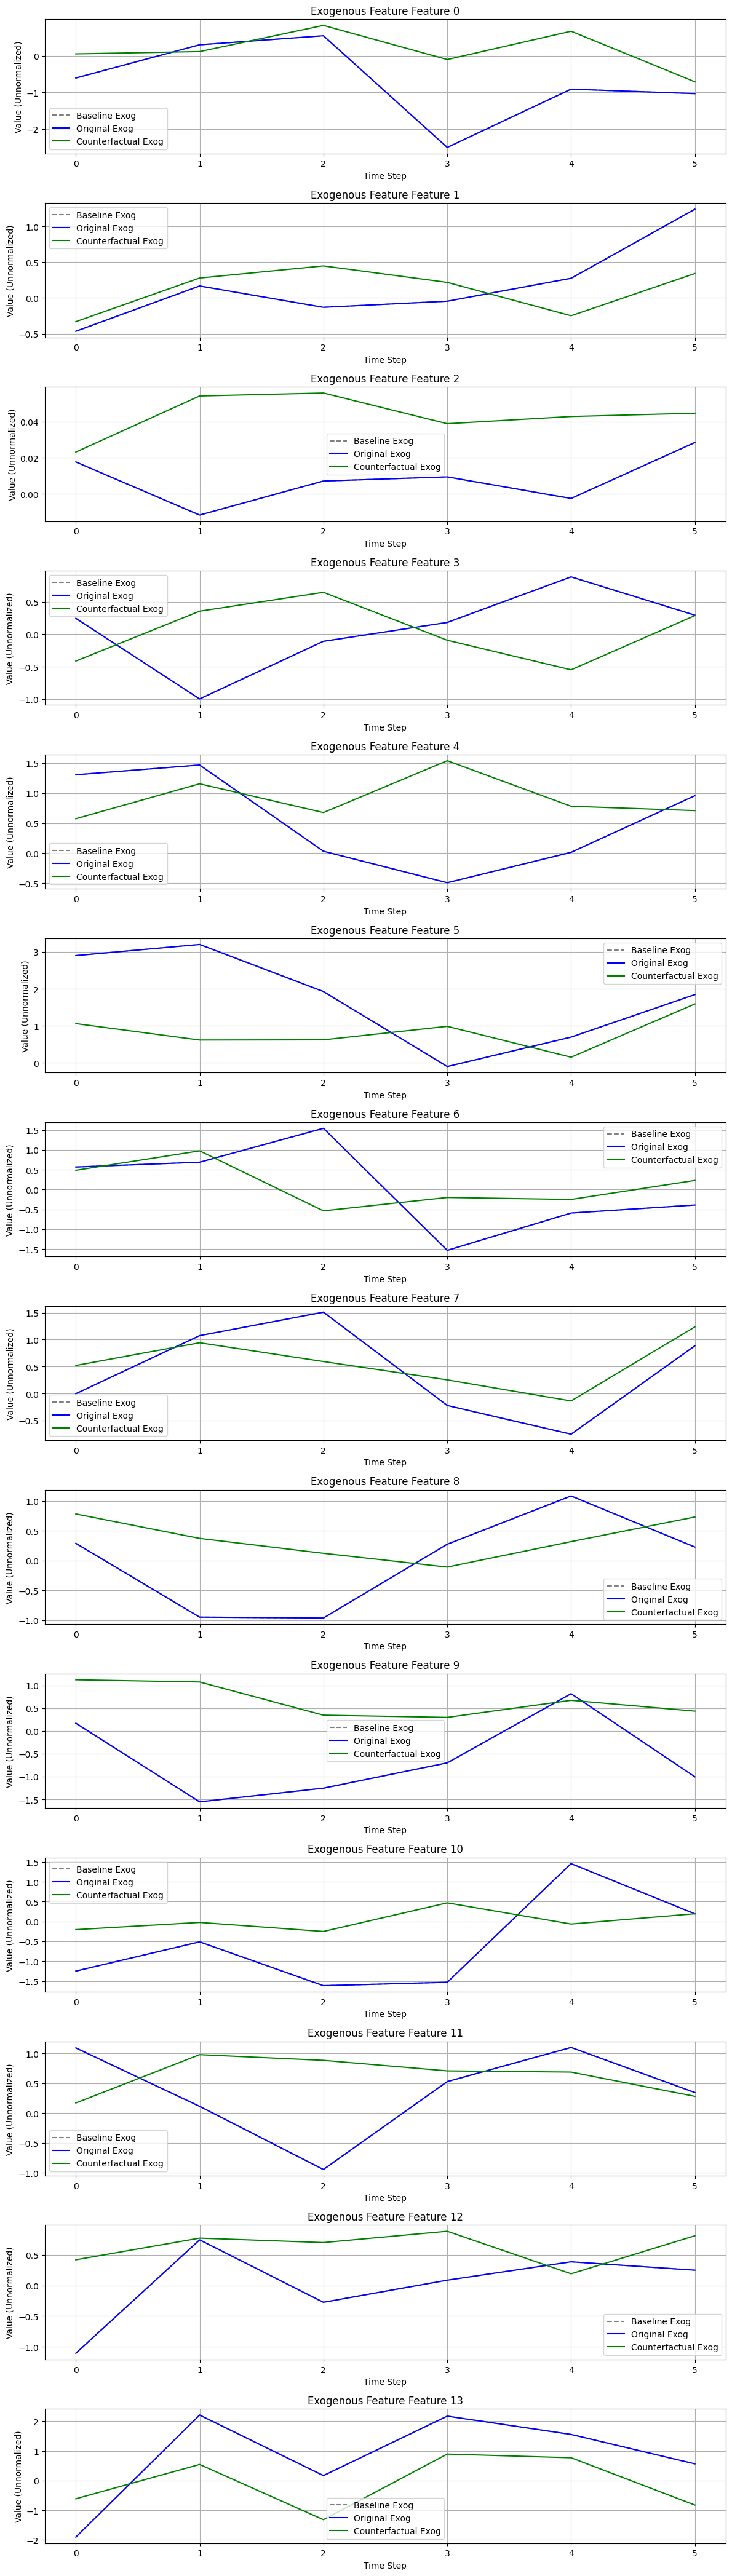

In [654]:

r = random.randint(0, 1)
baseline.plot_exogenous_example(i=r, cf_model=cf_model)

In [671]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

def plot_optimization_results(
    method_name,
    dataset_name,
    results,
    feature_labels,
    num_samples=5,
    seed=42
):
    """
    Plots predicted vs original targets and exogenous variables.

    Args:
        method_name (str): Name of the optimization method (e.g., 'sarimax').
        dataset_name (str): Name of the dataset (used in file names).
        results (dict): Dictionary returned by `run_optimization(...)`.
        feature_labels (list): Names of the exogenous features.
        num_samples (int): Number of event samples to visualize.
        seed (int): Random seed for reproducibility.
    """
    print("ASLNVKJNLK:AN:VKN")
    random.seed(seed)
    
    orig_targets = results['orig_targets']
    pred_targets = results['targets']
    orig_exogs = results['transformed_orig_exogs']
    pred_exogs = results['transformed_exogs']

    # Mean of original predictions to classify event (>=0.5 means event occurred)
    pred_mean = orig_targets.mean(axis=1)
    event_labels = np.where(pred_mean >= 0.5, 1, 0)
    event_indices = np.where(event_labels == 1)[0]
    print(pred_mean, event_labels, event_indices)
    # Randomly sample from event cases
    sample_idx = random.sample(list(event_indices), min(num_samples, len(event_indices)))

    for sam in sample_idx:
        time_steps = np.arange(orig_targets.shape[1])

        orig_target = orig_targets[sam]
        pred_target = pred_targets[sam]
        orig_exog = orig_exogs[sam]
        pred_exog = pred_exogs[sam]

        # Reshape if 1D
        if orig_target.ndim == 1:
            orig_target = orig_target[:, np.newaxis]
        if pred_target.ndim == 1:
            pred_target = pred_target[:, np.newaxis]

        num_exog_vars = orig_exog.shape[-1]
        num_cols = 3
        num_rows = math.ceil((num_exog_vars + 1) / num_cols)

        plt.figure(figsize=(6 * num_cols, 4 * num_rows))

        # Plot target
        plt.subplot(num_rows, num_cols, 1)
        plt.plot(time_steps, orig_target[:, 0], label='Original Target (0=Survived, 1=Died)', color='blue', marker='o')
        plt.plot(time_steps, pred_target[:, 0], label='Predicted Target', color='orange', linestyle='--', marker='x')
        plt.title("Binary Outcome: Survived (0) vs Died (1)")
        plt.xlabel("Time Step")
        plt.ylabel("Outcome")
        plt.ylim(-0.1, 1.1)
        plt.legend()

        # Plot each exogenous variable
        for i in range(num_exog_vars):
            plt.subplot(num_rows, num_cols, i + 2)
            plt.plot(time_steps, orig_exog[:, i], label='Original Exogenous', color='blue')
            plt.plot(time_steps, pred_exog[:, i], label='Predicted Exogenous', color='orange')
            label = feature_labels[i] if i < len(feature_labels) else f"Feature {i}"
            plt.title(f"Exogenous Variable: {label}")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.legend()

        plt.tight_layout()
        plt.savefig(f"{method_name}_plot_{dataset_name}_{sam}.png")
        plt.show()


In [672]:
plot_optimization_results(
    method_name='sarimax',
    dataset_name='mimic',
    results=results_sarimax,  # result dict from run_optimization(...)
    feature_labels=mimic_feature_labels,
    num_samples=2
)

ASLNVKJNLK:AN:VKN
[1. 1.] [1 1] [0 1]


KeyboardInterrupt: 

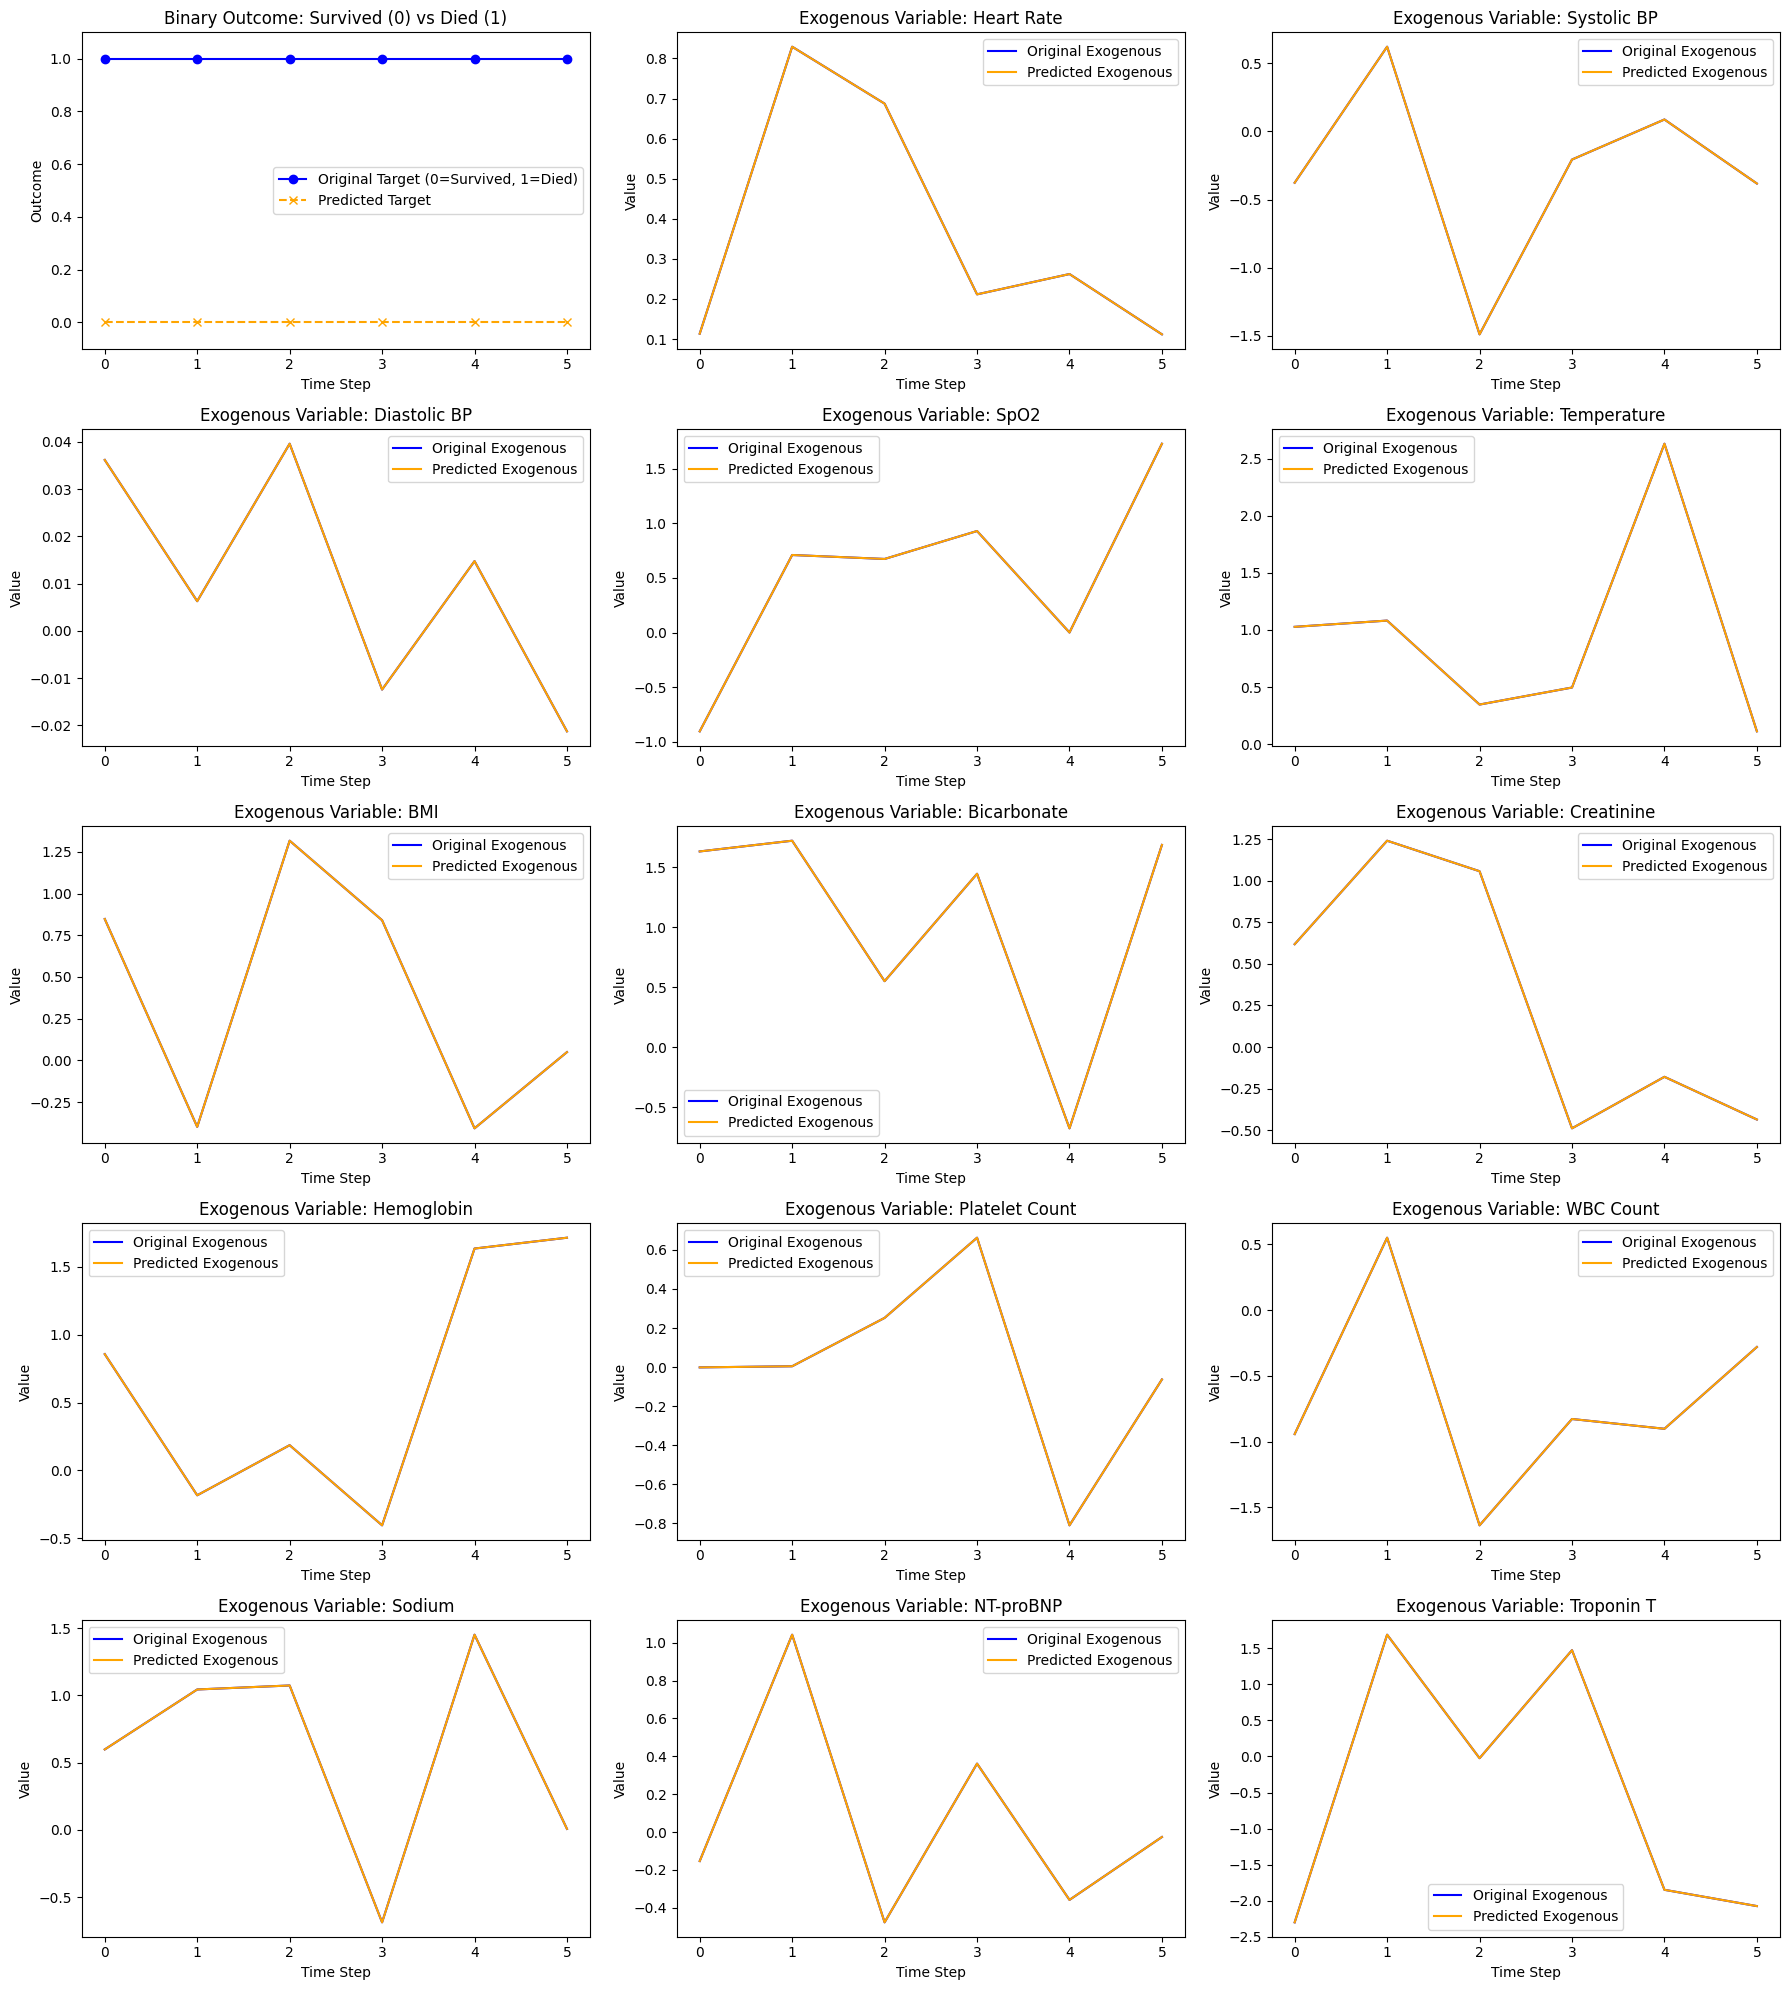

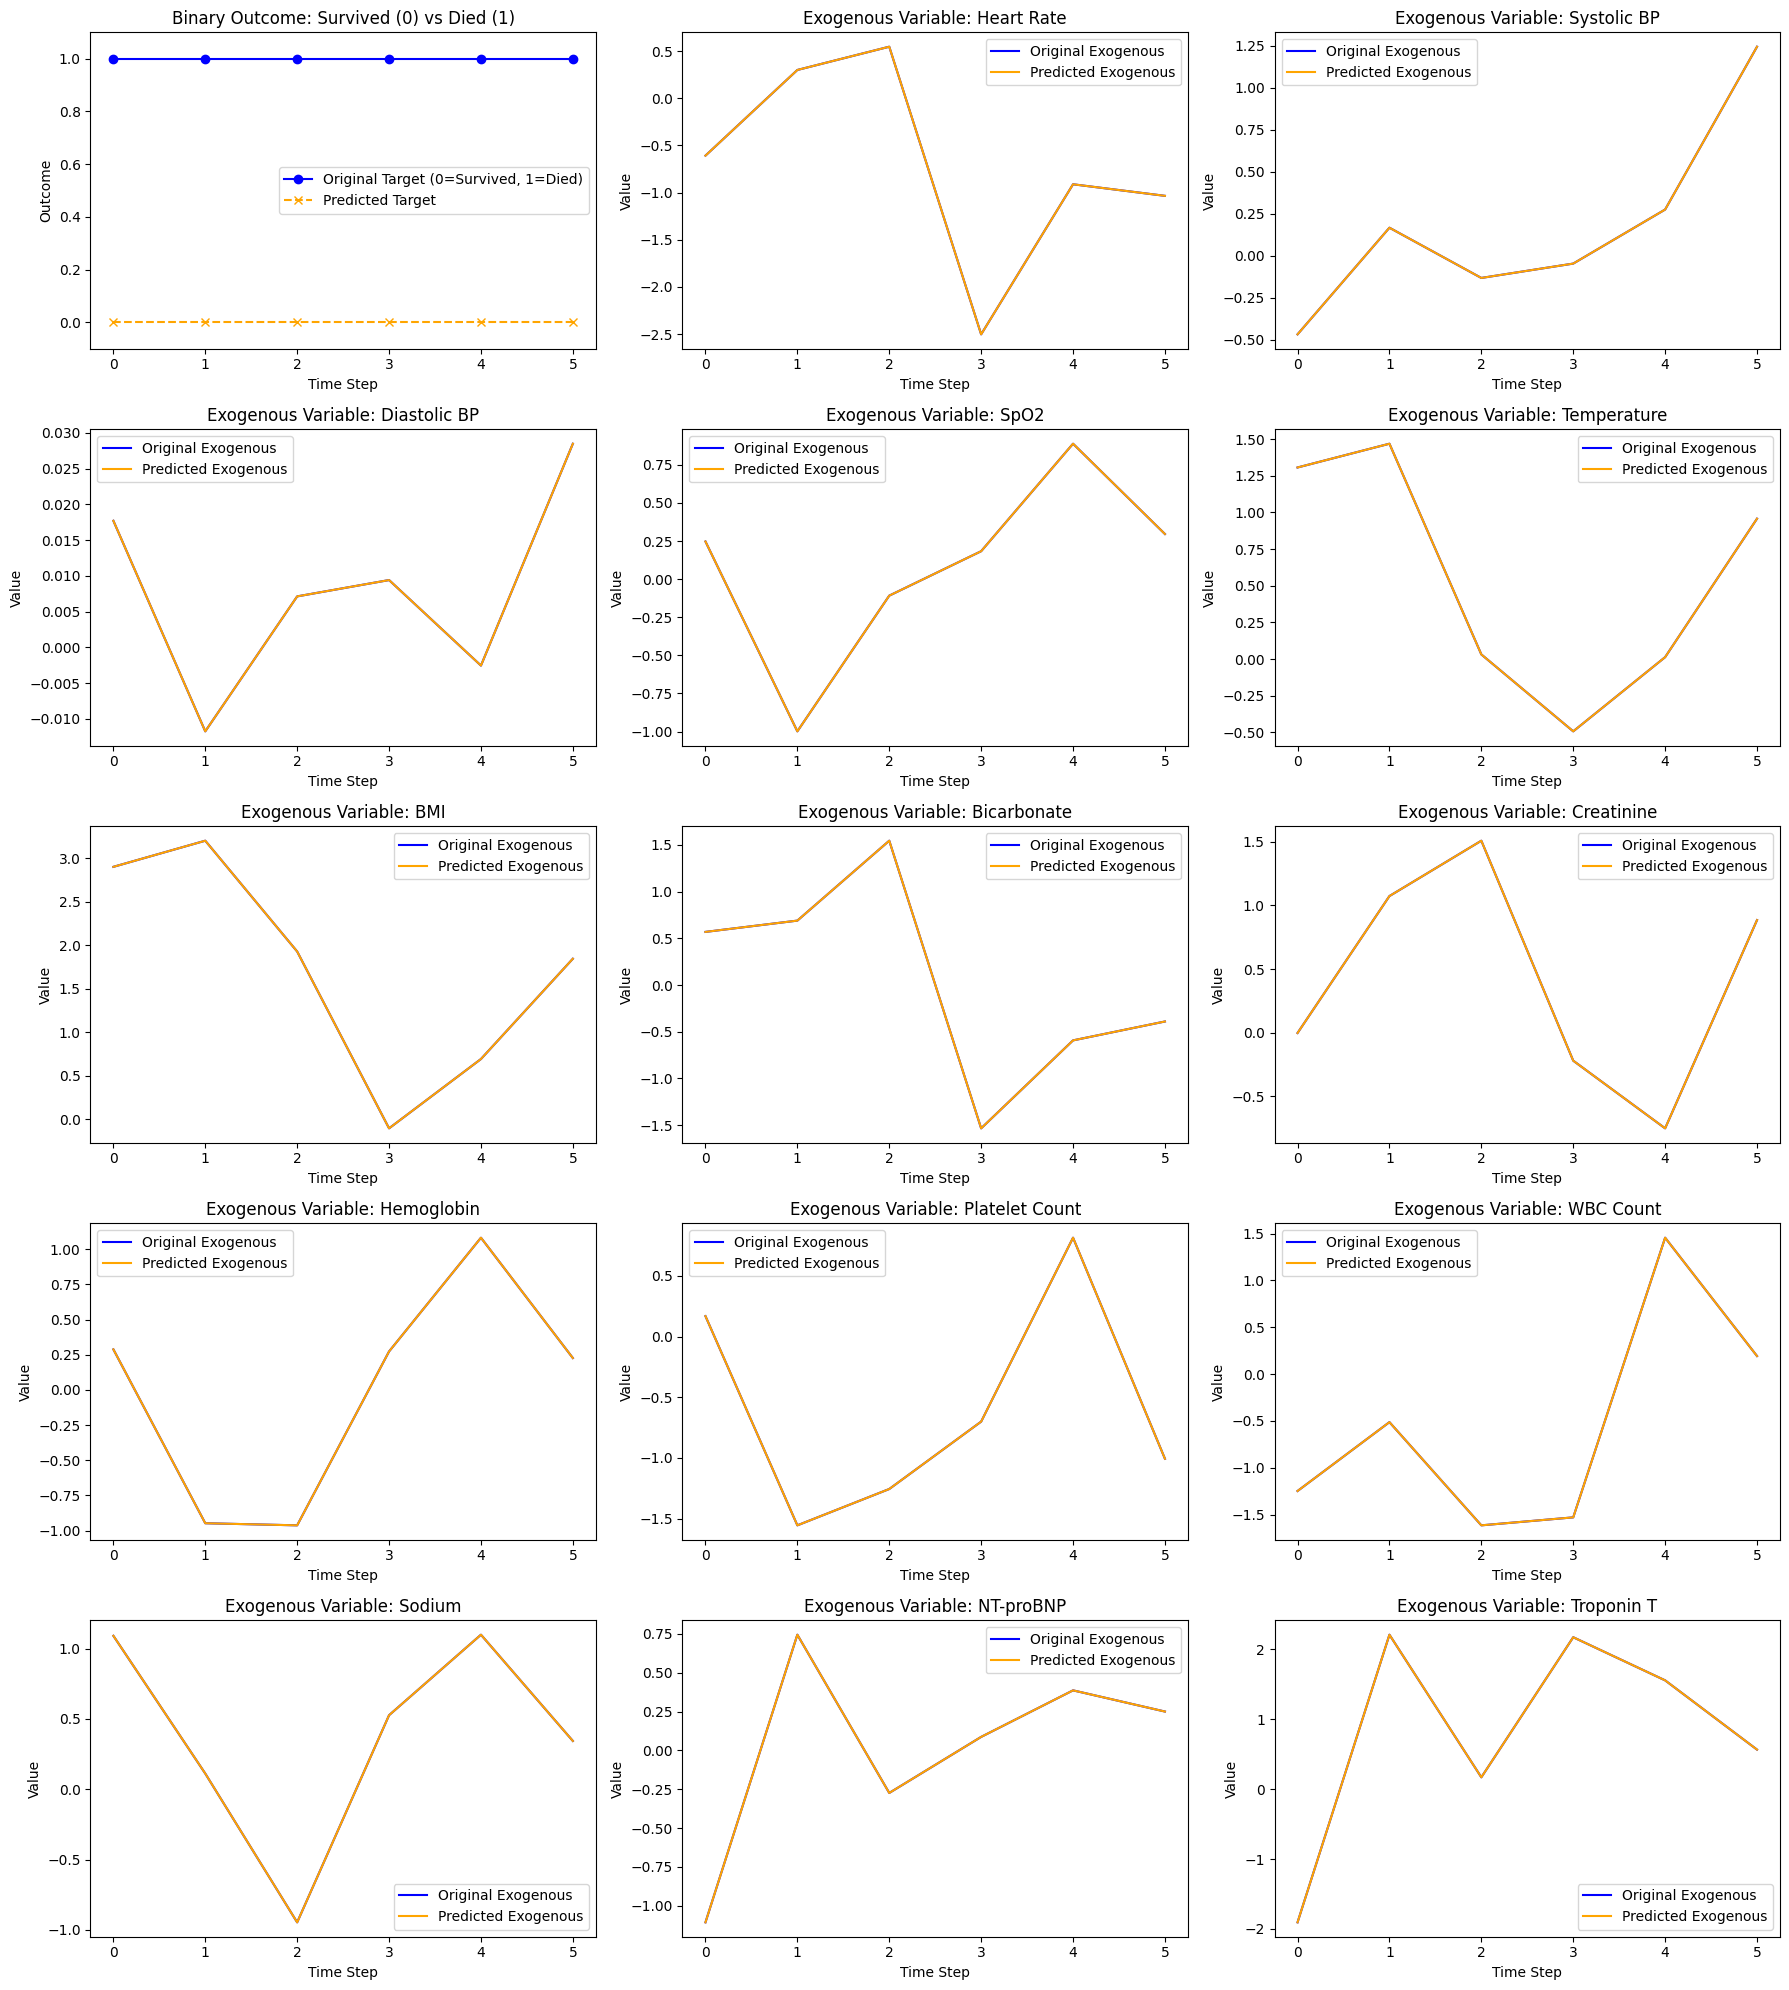

In [660]:
plot_optimization_results(
    method_name='ols',
    dataset_name='mimic',
    results=results_ols,  # result dict from run_optimization(...)
    feature_labels=mimic_feature_labels,
    num_samples=2
)

In [673]:
plot_optimization_results(
    method_name='gru',
    dataset_name='mimic',
    results=results_gru,  # result dict from run_optimization(...)
    feature_labels=mimic_feature_labels,
    num_samples=2
)

ASLNVKJNLK:AN:VKN
[0. 0.] [0 0] []


In [662]:
plot_optimization_results(
    method_name='nbeats',
    dataset_name='mimic',
    results=results_nbeats,  # result dict from run_optimization(...)
    feature_labels=mimic_feature_labels,
    num_samples=2
)

[0.33333333 1.         0.66666667 1.         1.         1.
 1.         0.33333333 0.33333333 1.         0.33333333 0.33333333
 1.         0.33333333 0.33333333 0.5        0.33333333 1.
 0.33333333 1.         0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 1.         1.         0.83333333 0.33333333 1.
 1.         1.         1.         1.         0.33333333 0.33333333
 0.5        1.         0.33333333 0.33333333 1.         0.66666667
 1.         1.         1.         1.         1.         1.
 0.5        1.         1.         0.33333333 0.33333333 0.33333333
 0.33333333 0.5        1.         0.33333333 0.33333333 0.33333333
 0.33333333 1.         1.         1.         0.83333333 1.
 1.         0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 1.         0.66666667 1.         0.33333333
 0.5        0.33333333 1.         1.         0.33333333 1.
 1.         0.33333333 0.33333333 0.33333333 0.33333333 1.
 0.33333333 1.         0.33333333 0.33333333 0.3333

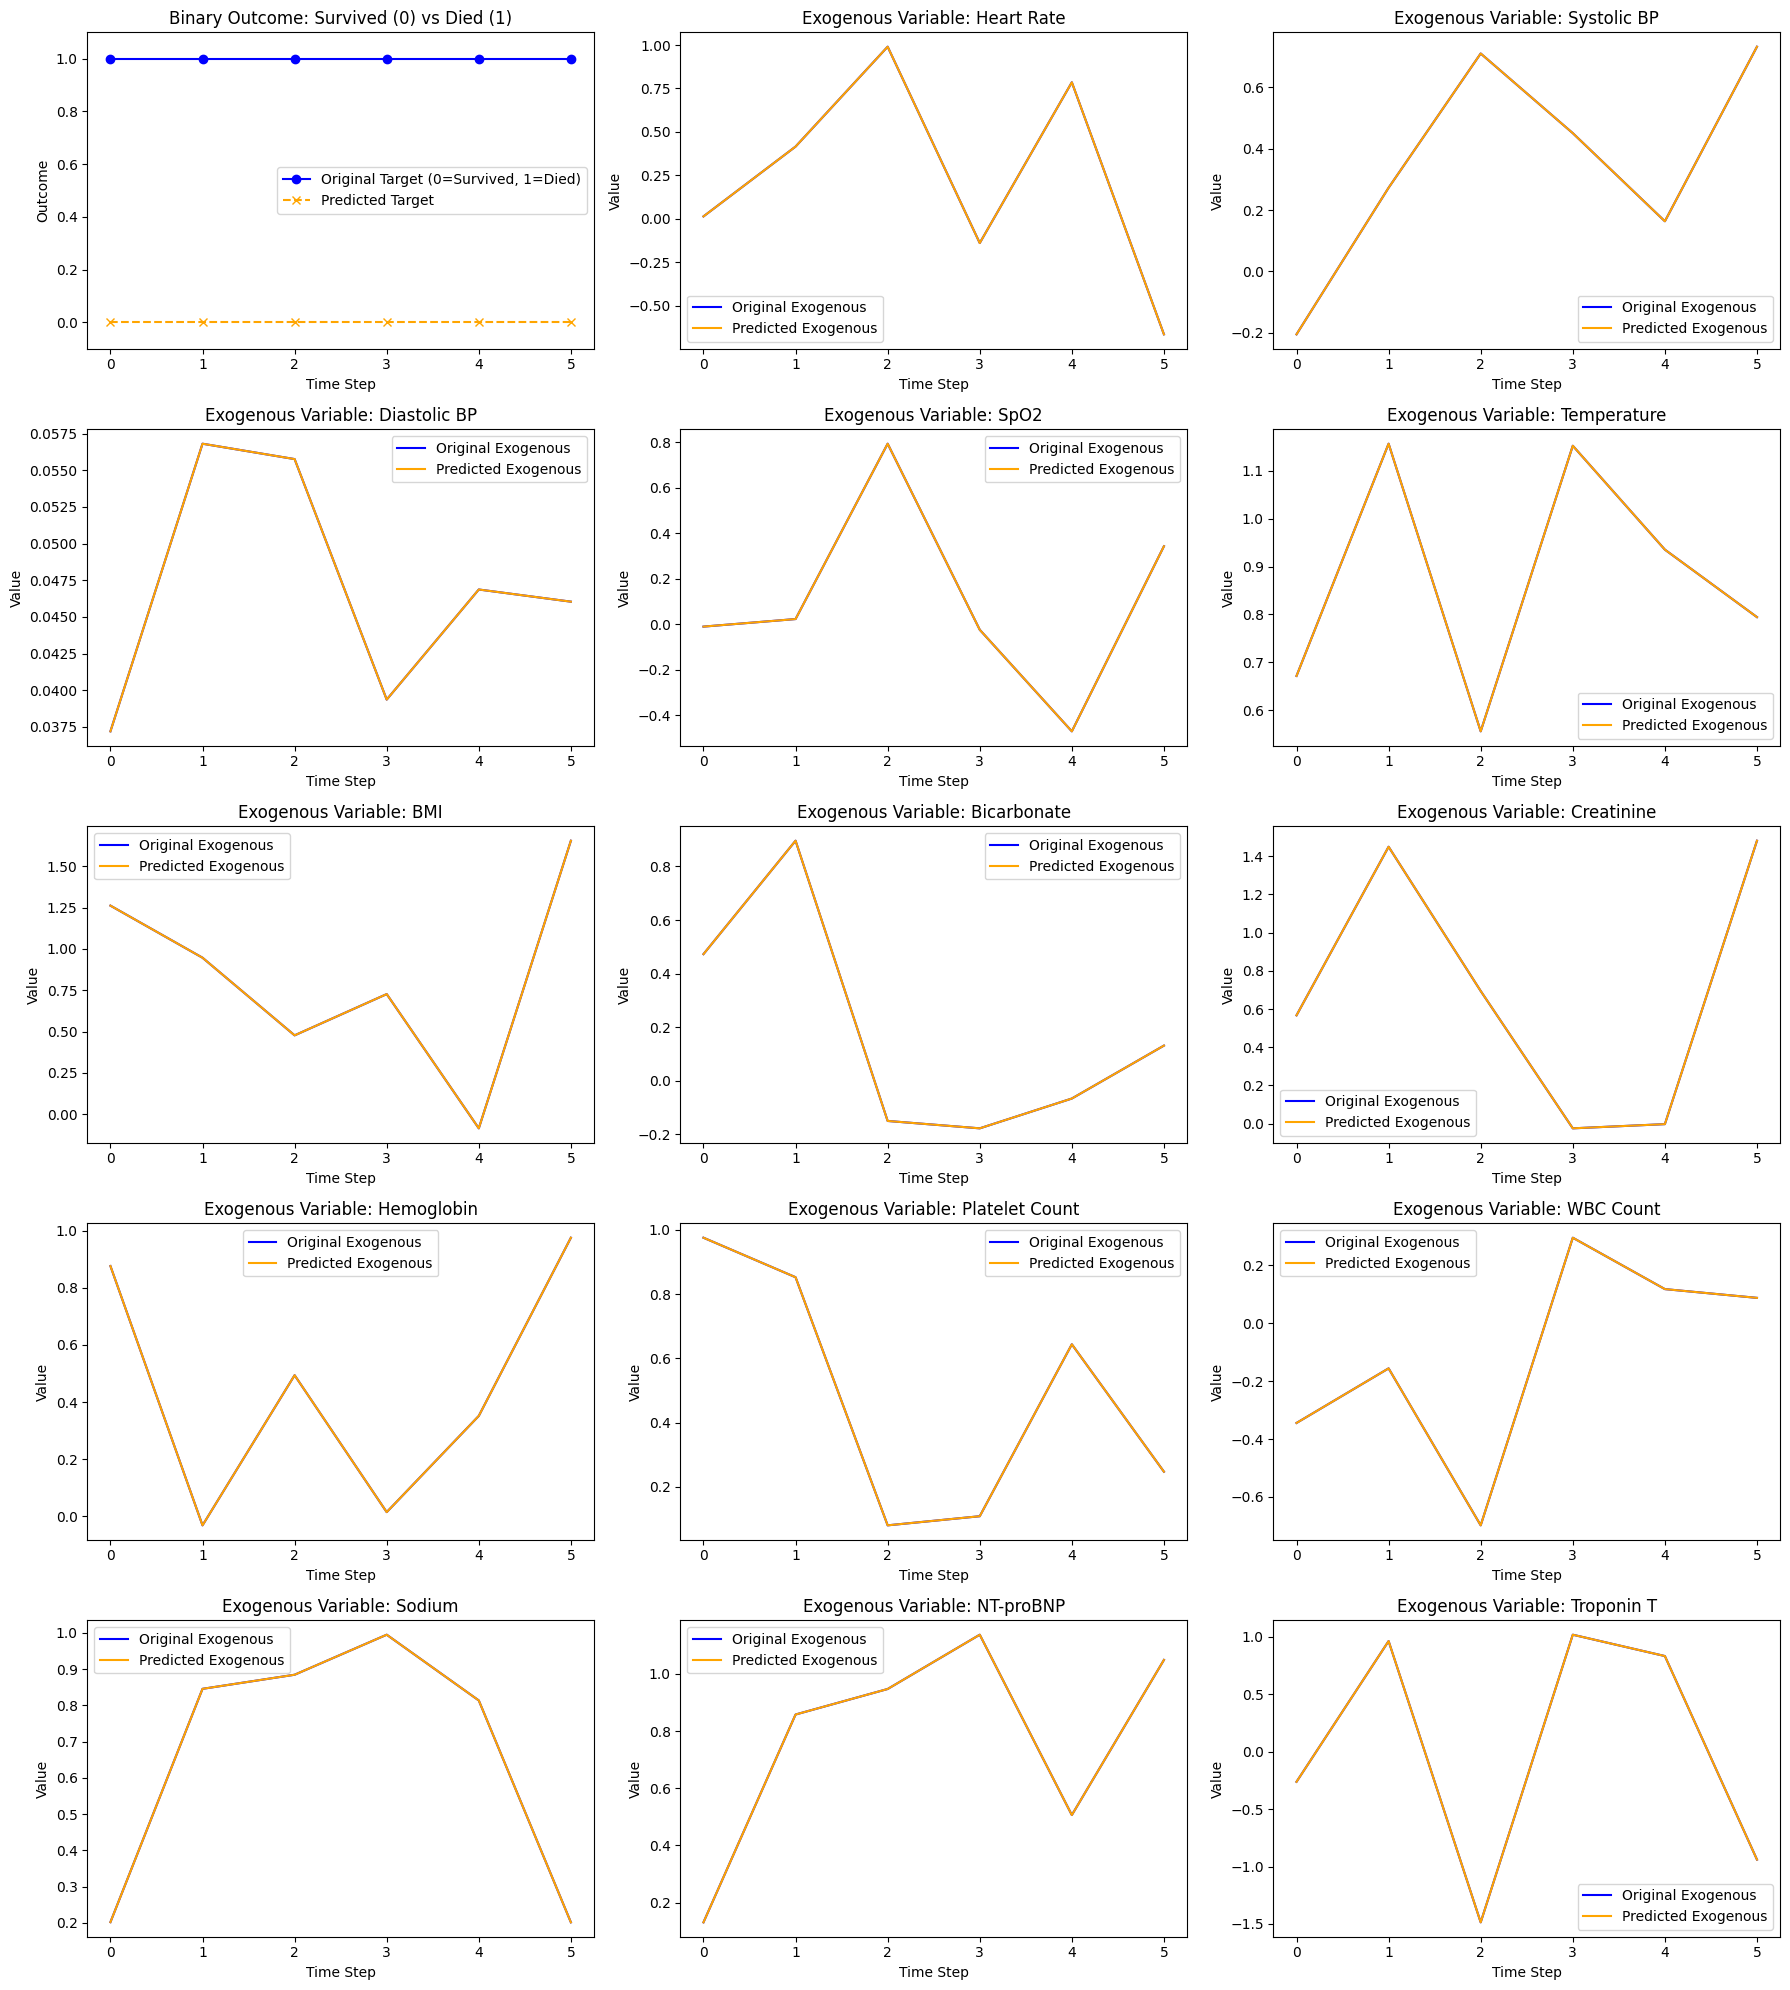

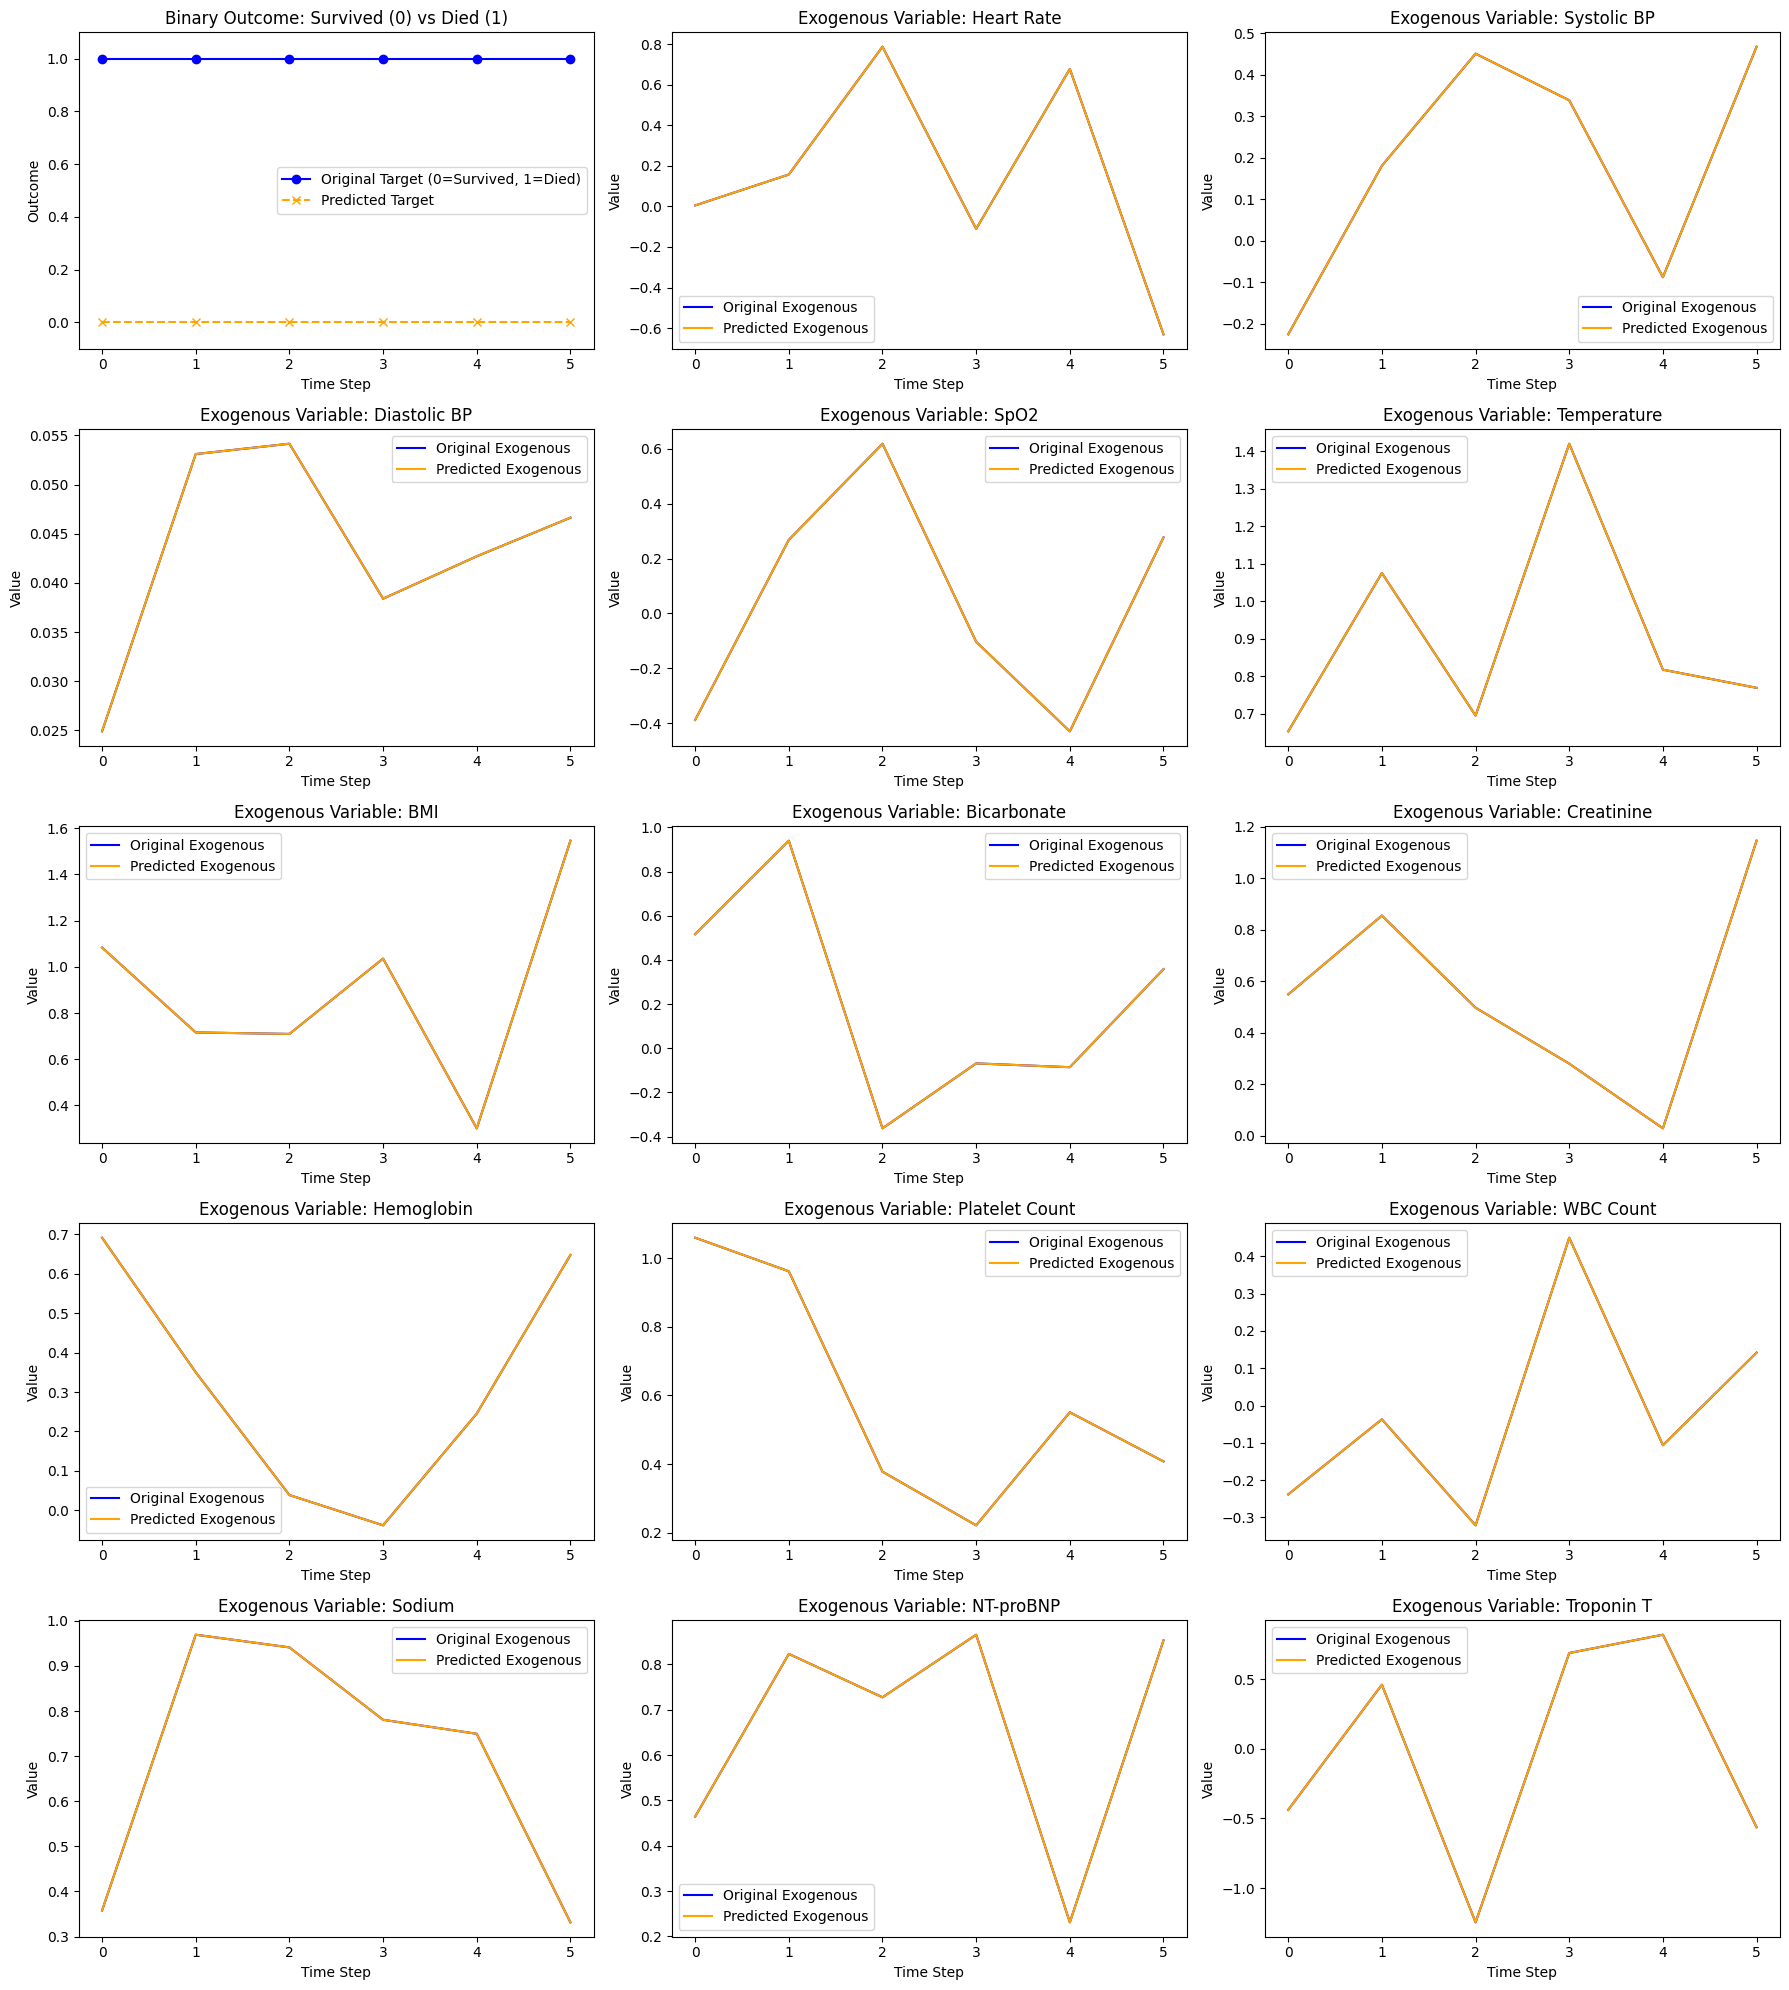

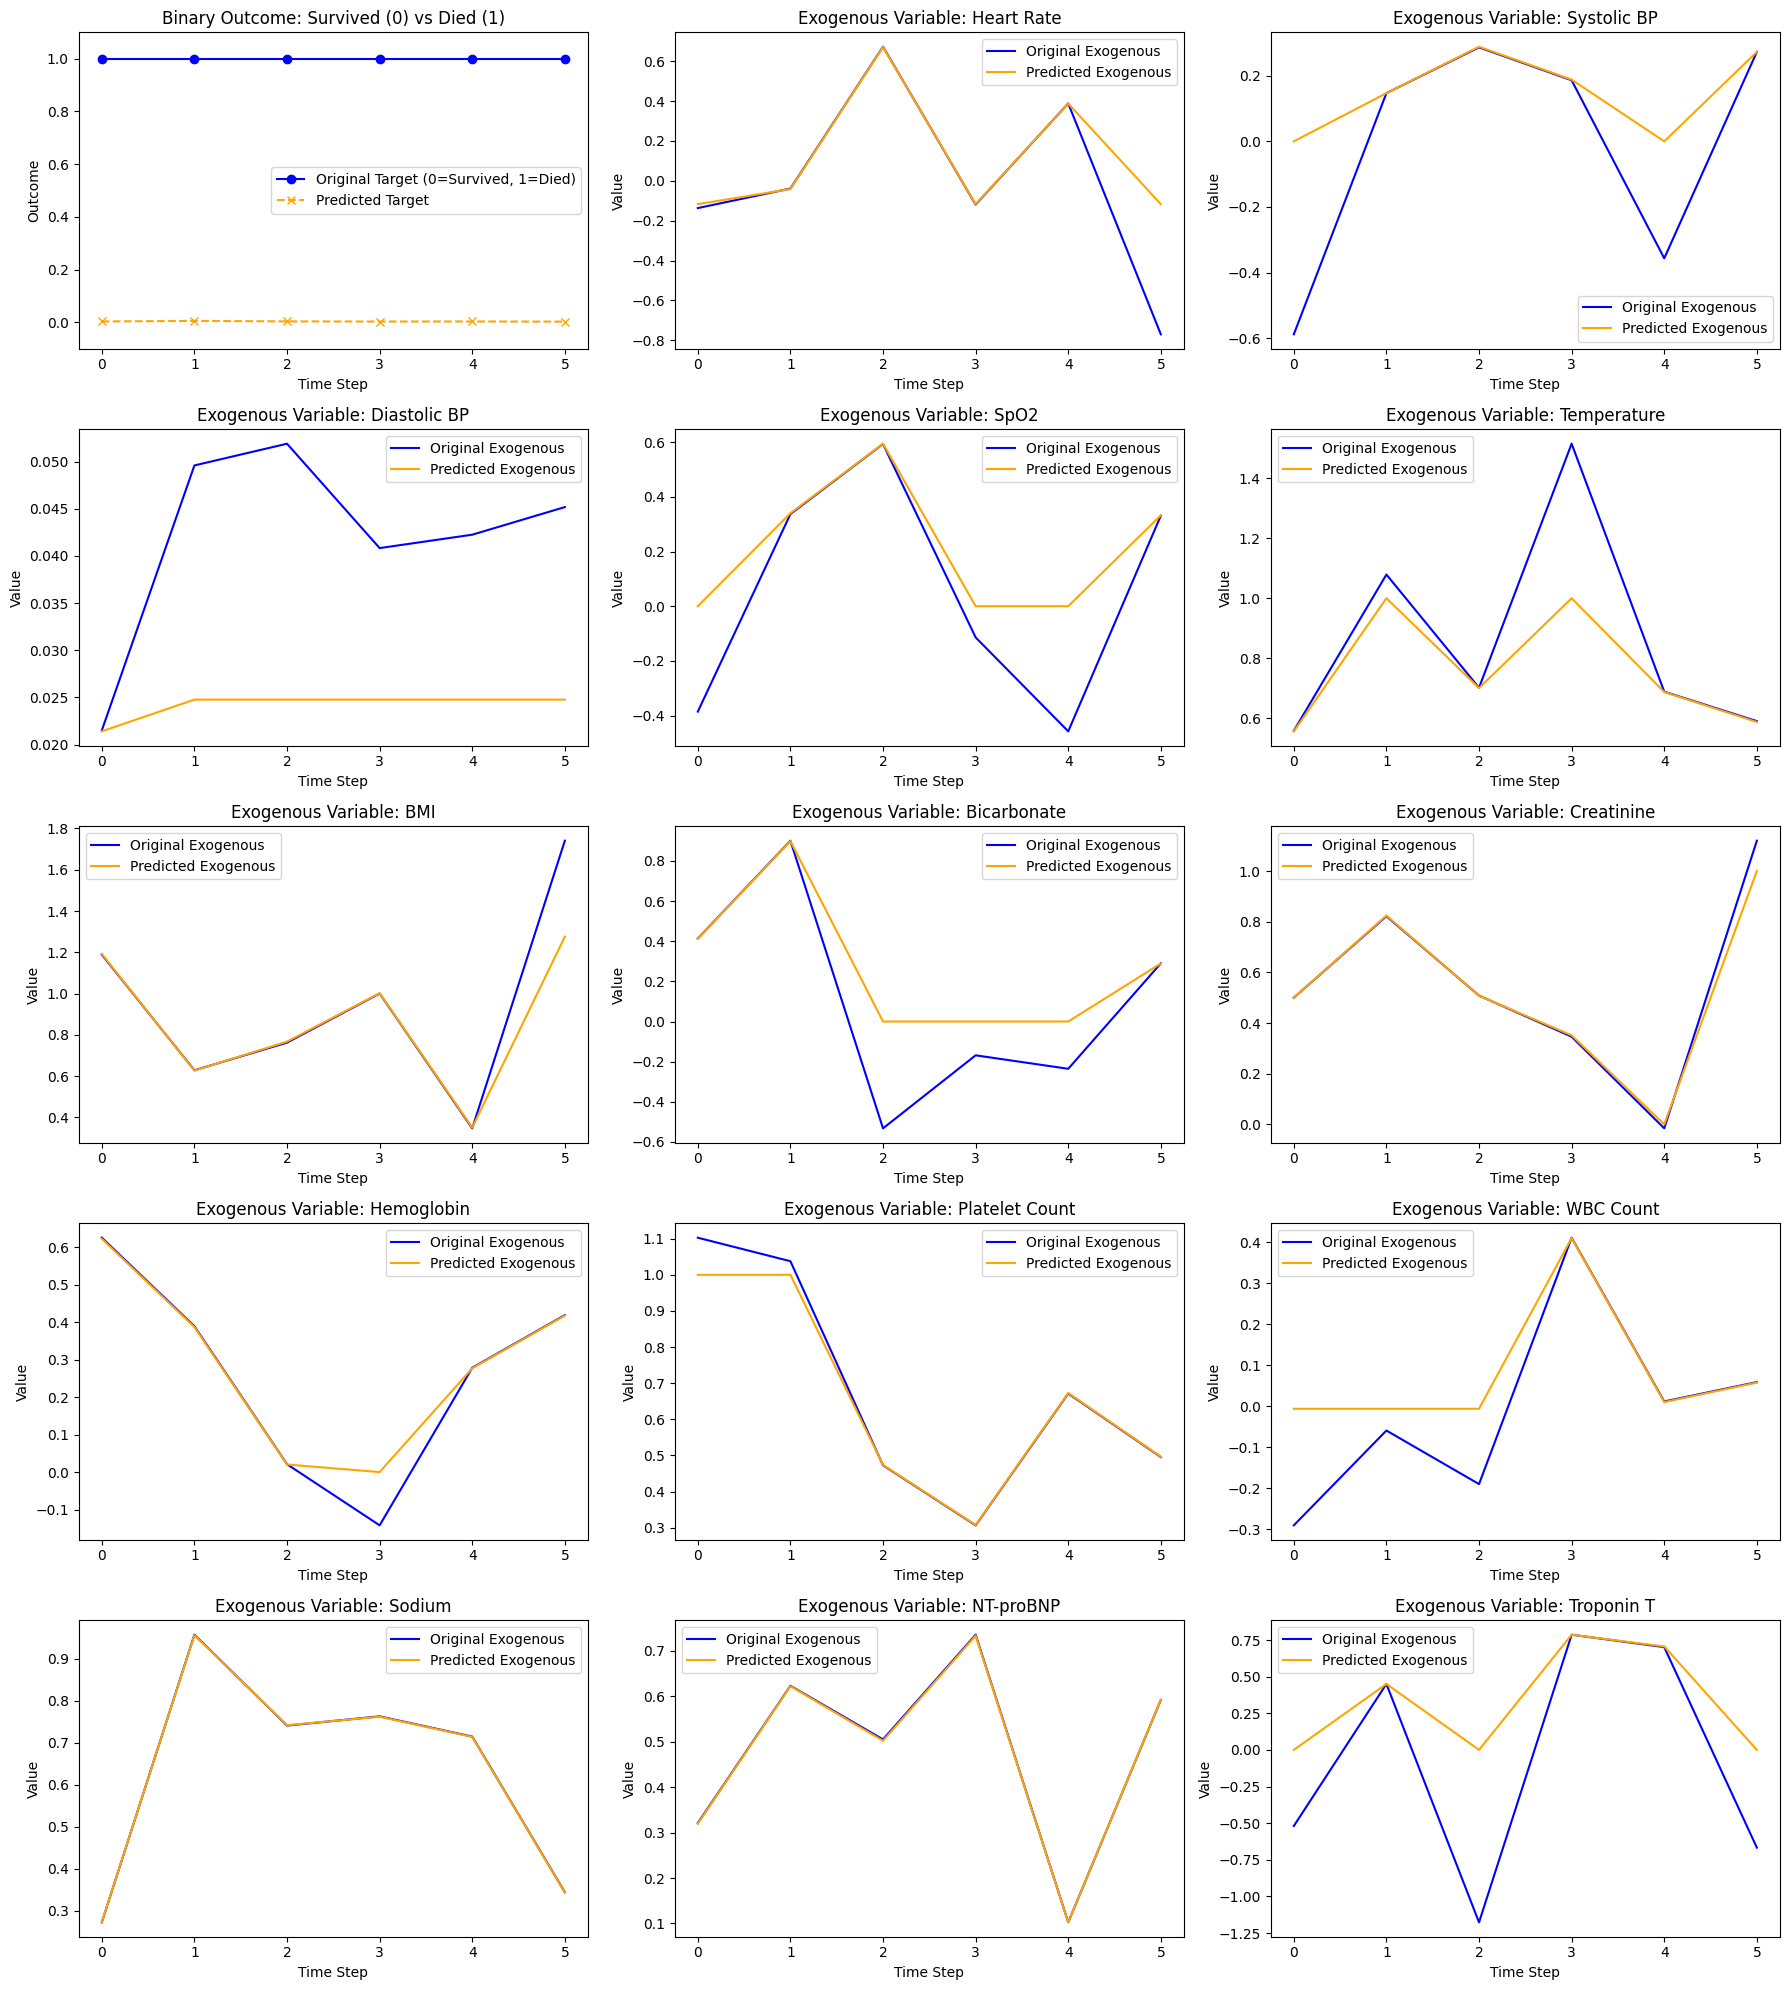

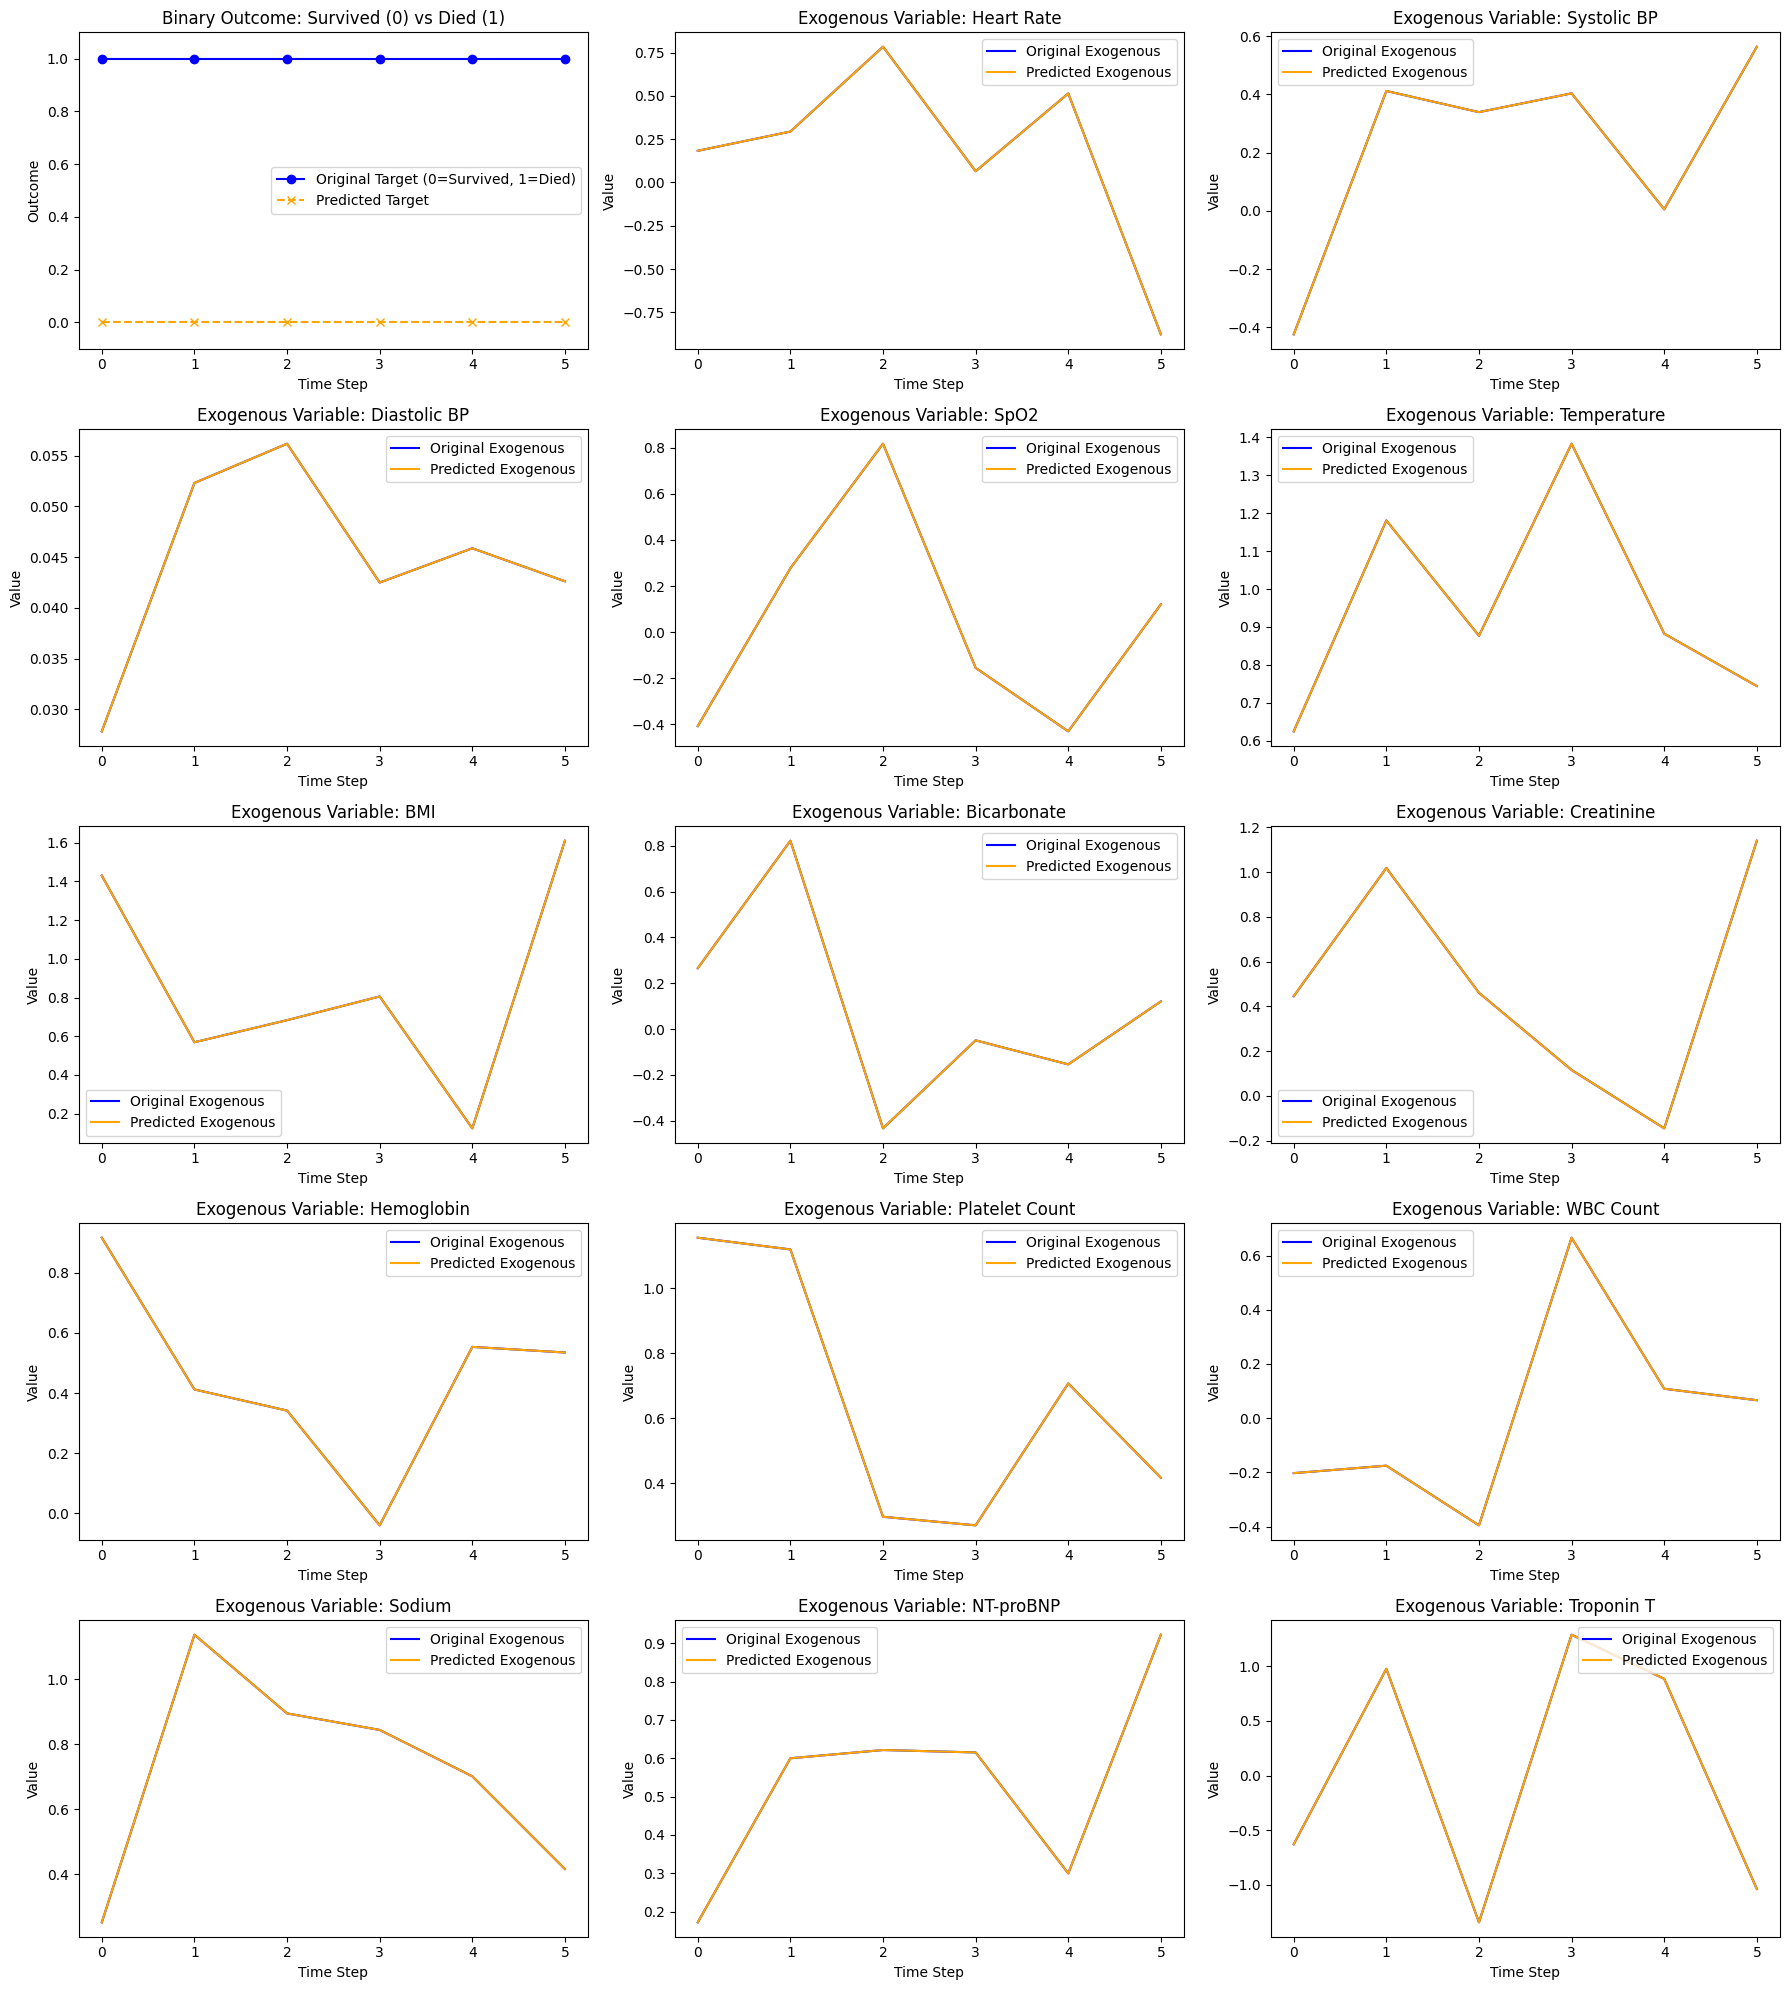

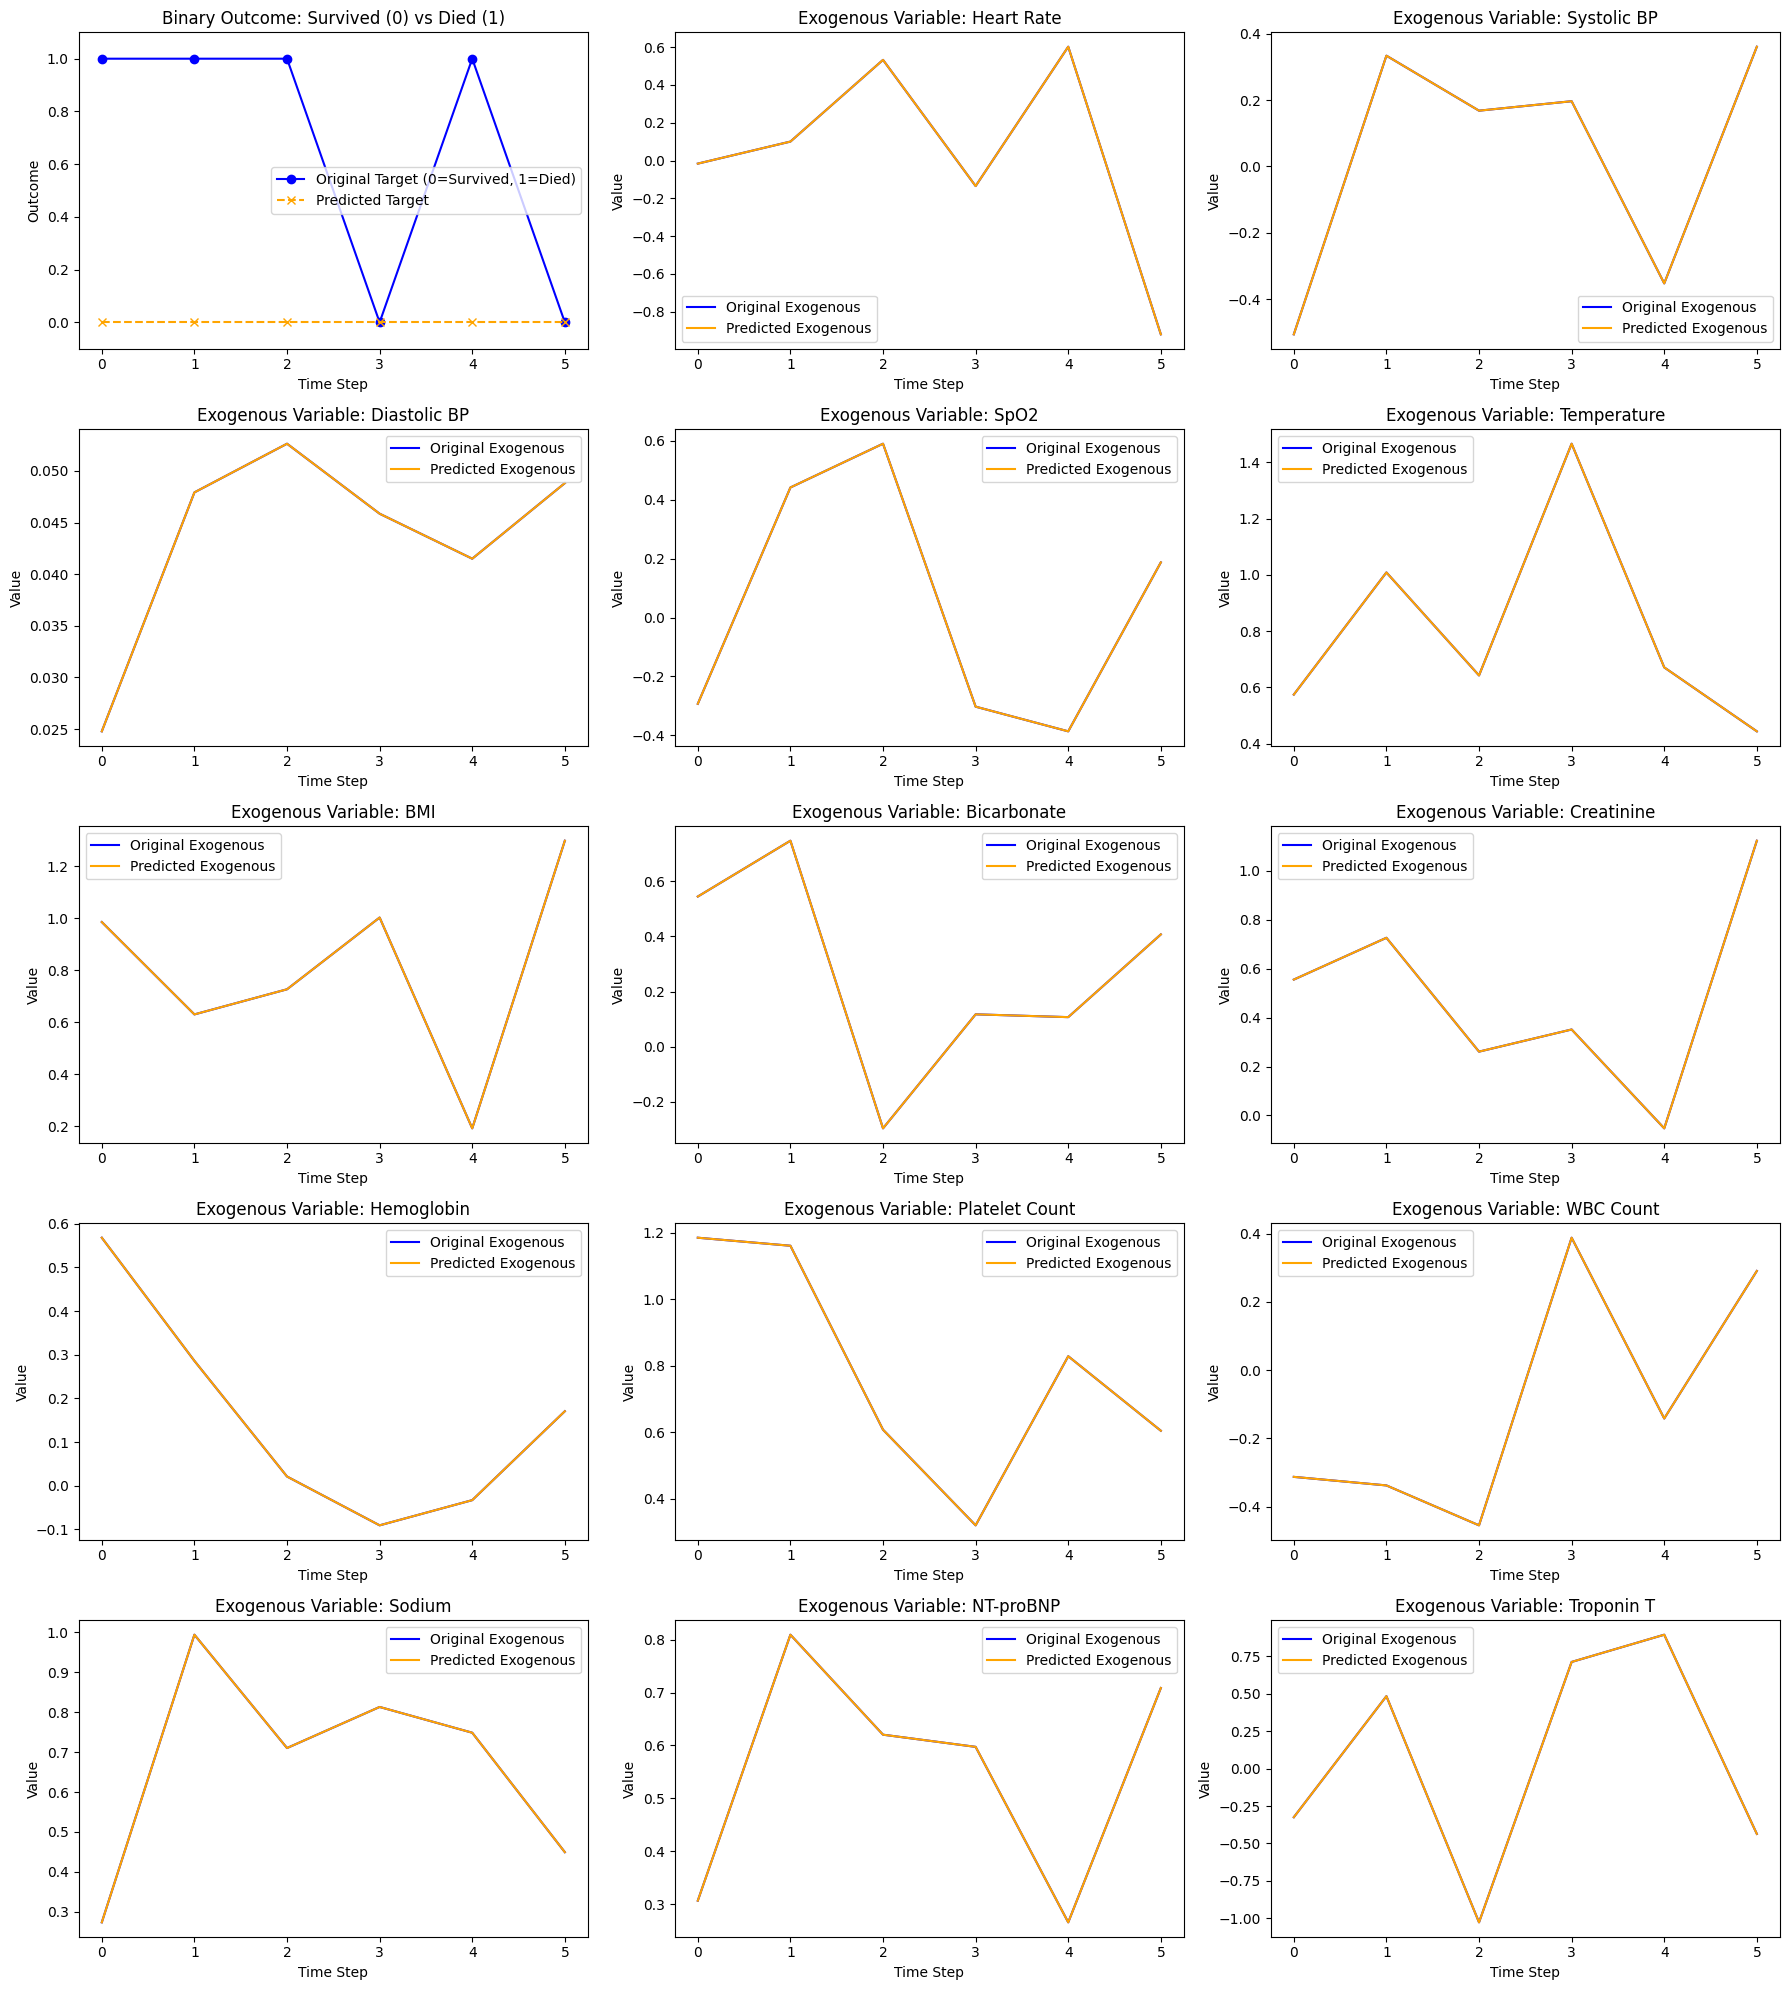

In [565]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

# Feature labels for MIMIC
mimic_feature_labels = [
    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
]
#print(mimic_orig_targets_sarimax)
pred_mean = mimic_orig_targets_sarimax.mean(axis=1)#pred_all_NBEATS[:, :, TARGET_COL].mean(axis=1)
print(pred_mean)
event_labels = np.where(pred_mean >= 0.5, 1, 0)
print(event_labels)
# Get indices where the original target has at least one '1'
positive_indices = [
    i for i in range(mimic_orig_targets_sarimax.shape[0])
    if np.any(mimic_orig_targets_sarimax[i] == 1)
]
event_indices = np.where(event_labels == 1)[0]  # Get indices where event_label == 1

# Randomly choose 5 of them
#sample_idx = random.sample(event_labels, min(5, len(positive_indices)))
sample_idx = random.sample(list(event_indices), min(5, len(event_indices)))
for sam in sample_idx:
    time_steps = np.arange(mimic_transformed_orig_targets_sarimax.shape[1])
    
    orig_targets = mimic_orig_targets_sarimax[sam]
    pred_targets = mimic_targets_sarimax[sam]
    orig_exogs = mimic_transformed_orig_exogs_sarimax[sam]
    pred_exogs = mimic_transformed_exogs_sarimax[sam]

    if orig_targets.ndim == 1:
        orig_targets = orig_targets[:, np.newaxis]
    if pred_targets.ndim == 1:
        pred_targets = pred_targets[:, np.newaxis]

    # Plot binary target (0 or 1)
    num_exog_vars = orig_exogs.shape[-1]
    num_cols = 3
    num_rows = math.ceil(num_exog_vars / num_cols)
    plt.figure(figsize=(6 * num_cols, 4 * num_rows))
    #plt.figure(figsize=(12, 4))
    plt.subplot(num_rows, num_cols, 1)
    plt.plot(time_steps, orig_targets[:, 0], label='Original Target (0=Survived, 1=Died)', color='blue', marker='o')
    plt.plot(time_steps, pred_targets[:, 0], label='Predicted Target', color='orange', linestyle='--', marker='x')
    plt.title("Binary Outcome: Survived (0) vs Died (1)")
    plt.xlabel("Time Step")
    plt.ylabel("Outcome")
    plt.ylim(-0.1, 1.1)
    plt.legend()
    #plt.tight_layout()
    #plt.savefig(f"binary_outcome_mimic_{sam}.png")
    #plt.show()

    # Plot exogenous variables
    for i in range(num_exog_vars):
        plt.subplot(num_rows, num_cols, i + 2)
        plt.plot(time_steps, orig_exogs[:, i], label='Original Exogenous', color='blue')
        plt.plot(time_steps, pred_exogs[:, i], label='Predicted Exogenous', color='orange')
        plt.title(f"Exogenous Variable: {mimic_feature_labels[i]}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
    
    plt.savefig(f"sarimax_grid_{args.dataet}_female_1y_{sam}.png")
    plt.show()


Pair 1 (Orig idx: 0, Pred idx: 0) Target Euclidean distance: 1.4142


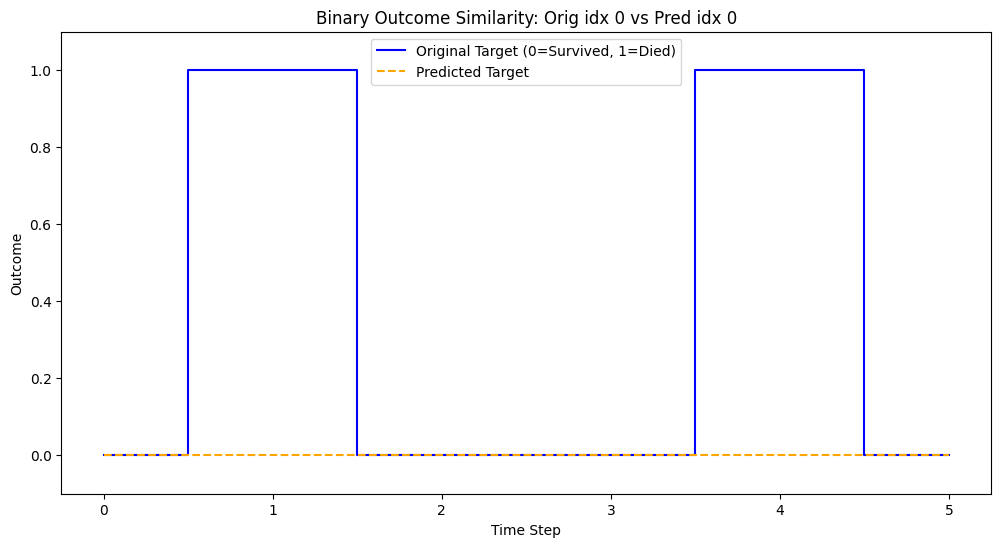

Pair 2 (Orig idx: 60, Pred idx: 38) Target Euclidean distance: 1.4142


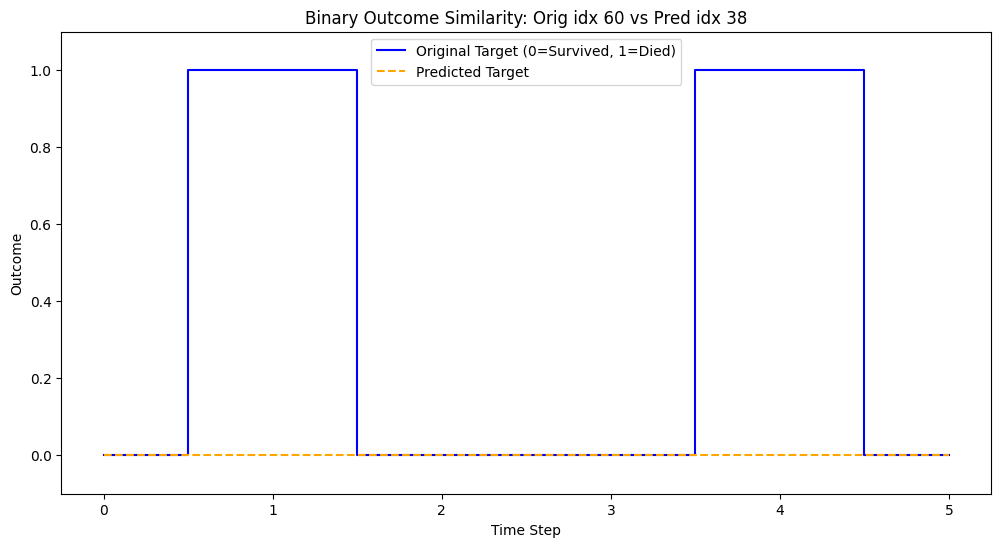

Pair 3 (Orig idx: 60, Pred idx: 37) Target Euclidean distance: 1.4142


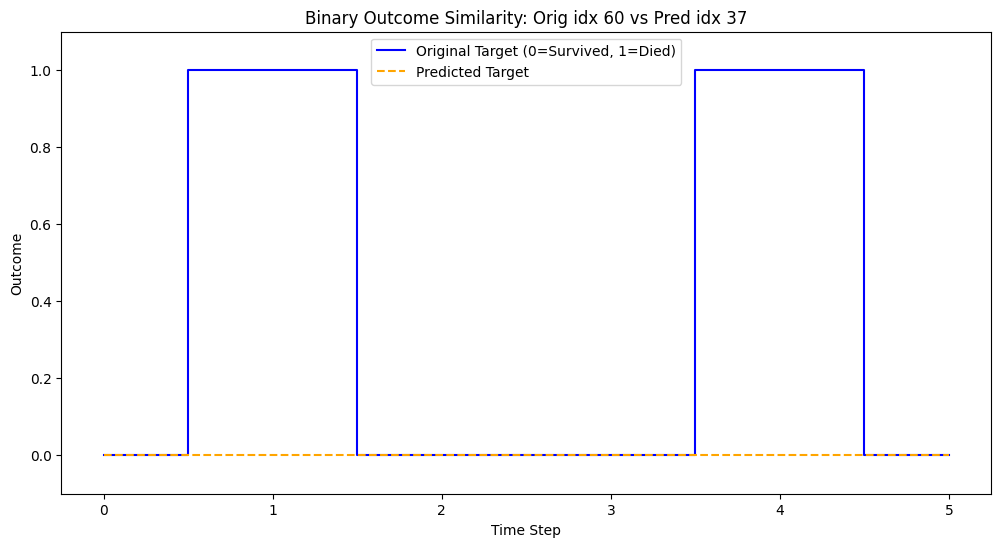

Pair 4 (Orig idx: 60, Pred idx: 36) Target Euclidean distance: 1.4142


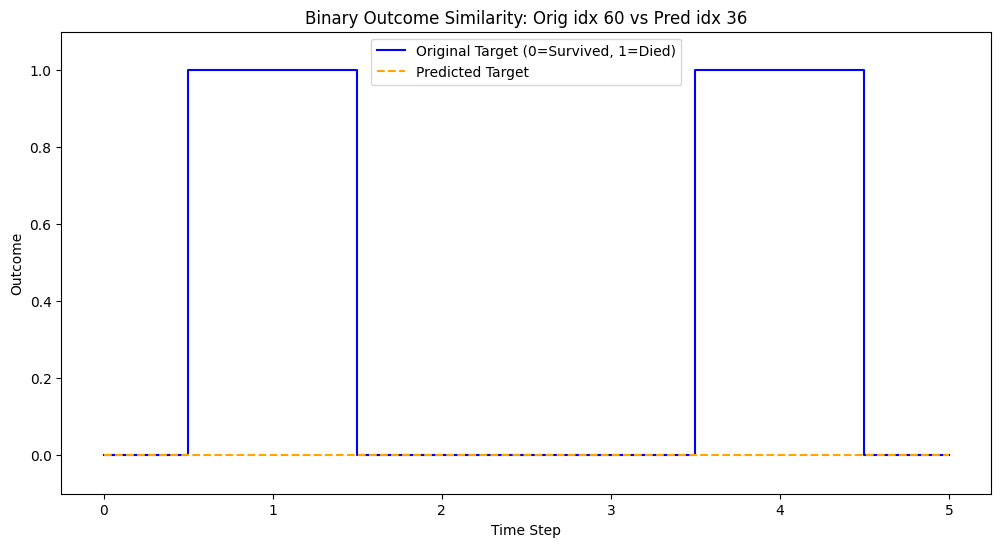

Pair 5 (Orig idx: 60, Pred idx: 35) Target Euclidean distance: 1.4142


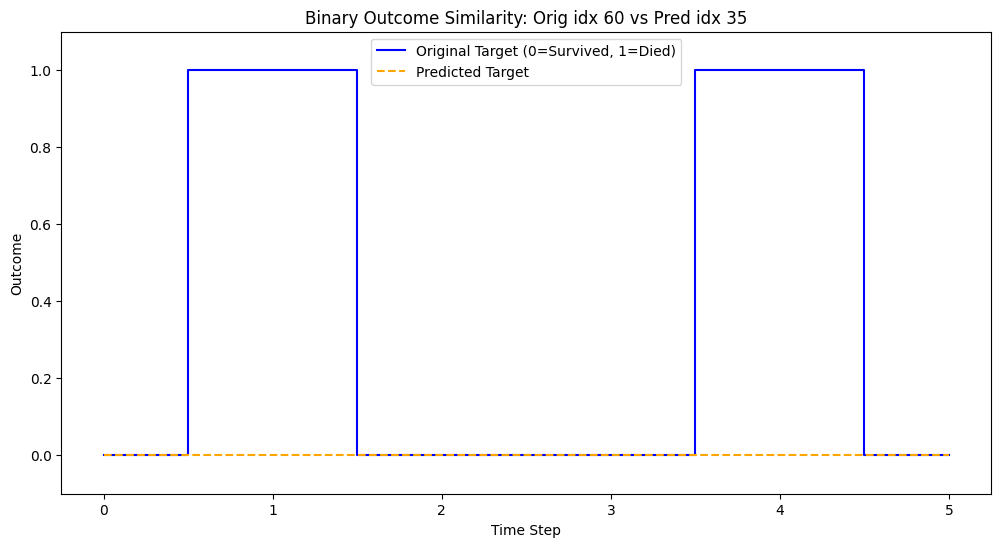

/tmp/ipykernel_420919/322402736.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


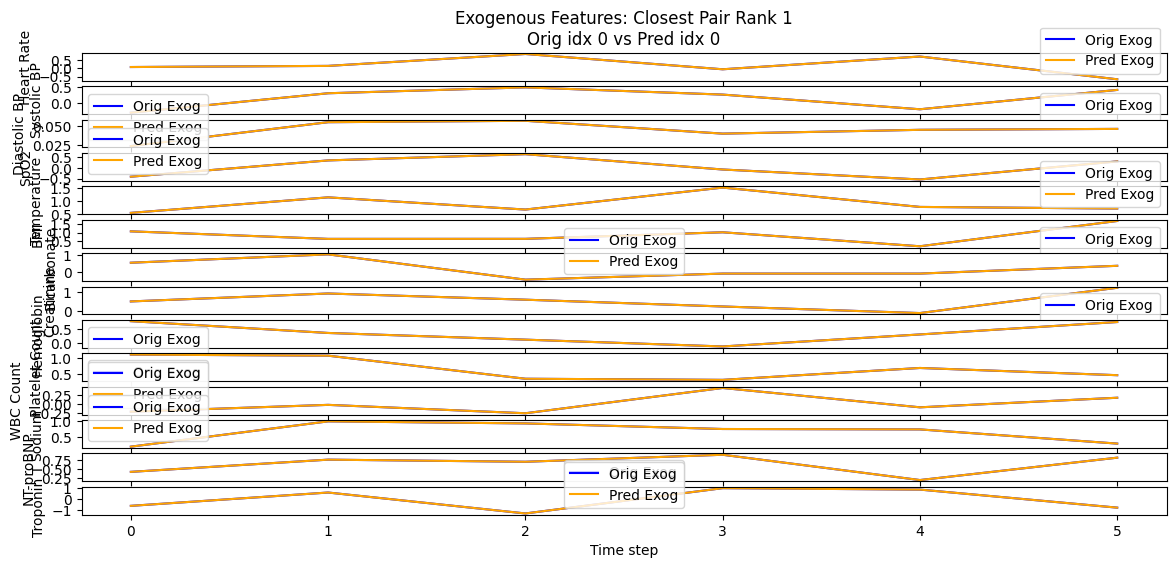

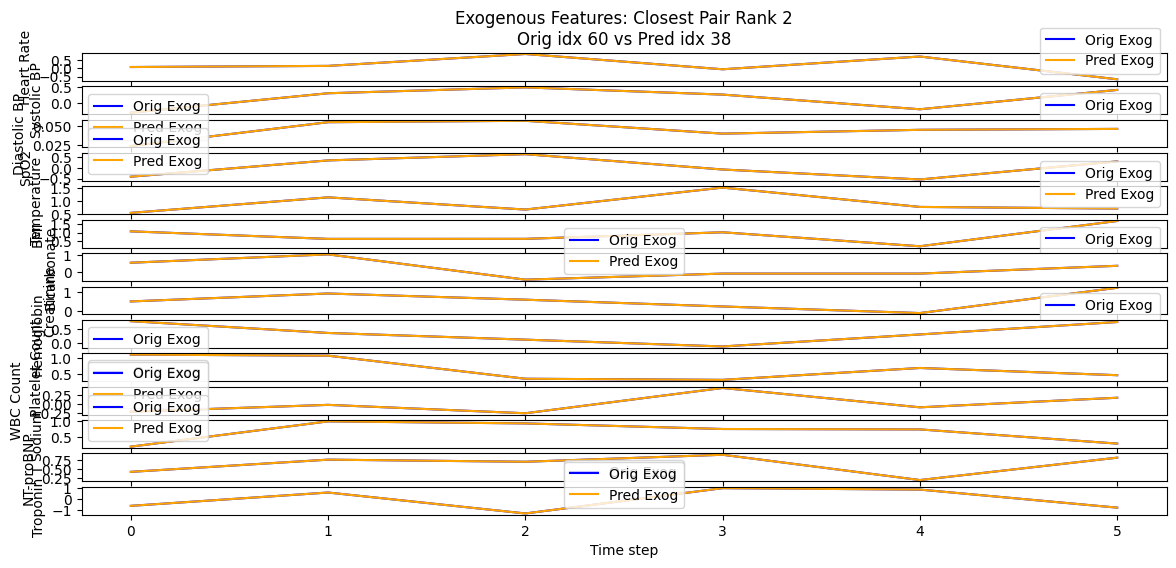

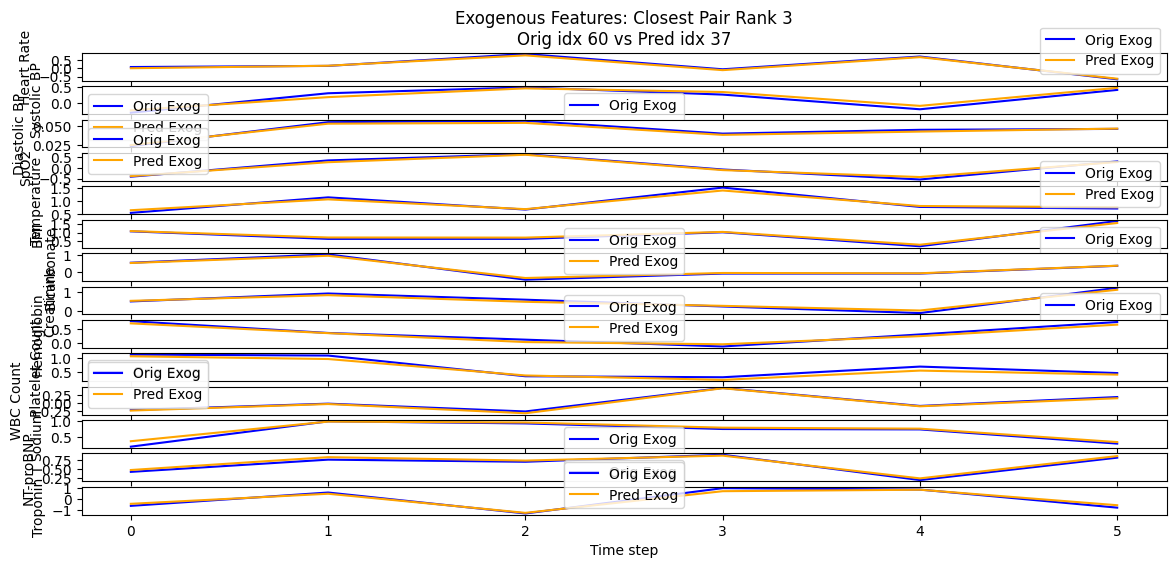

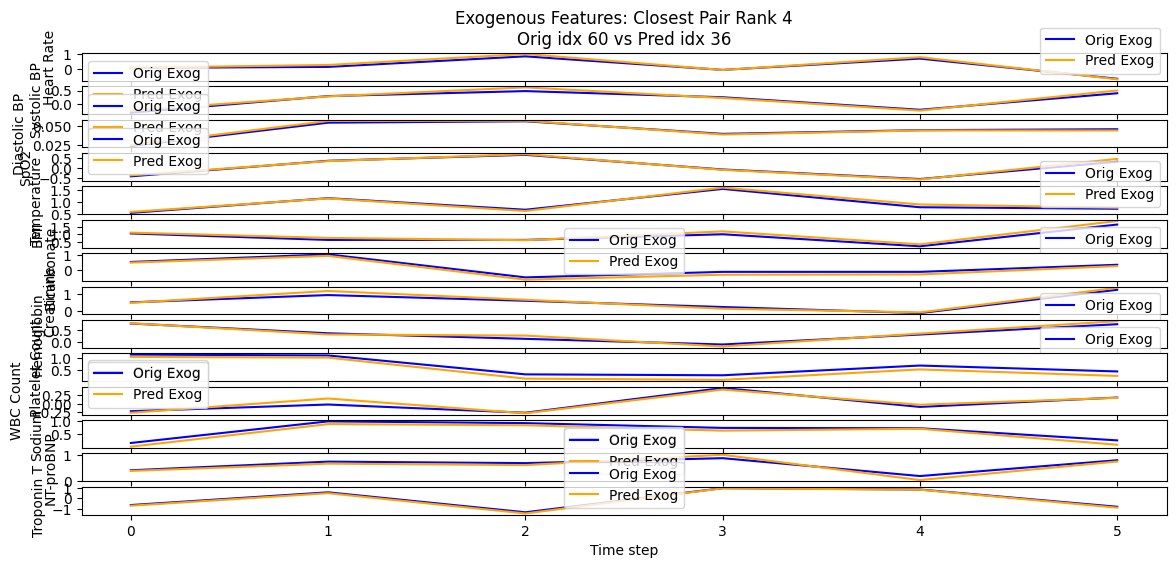

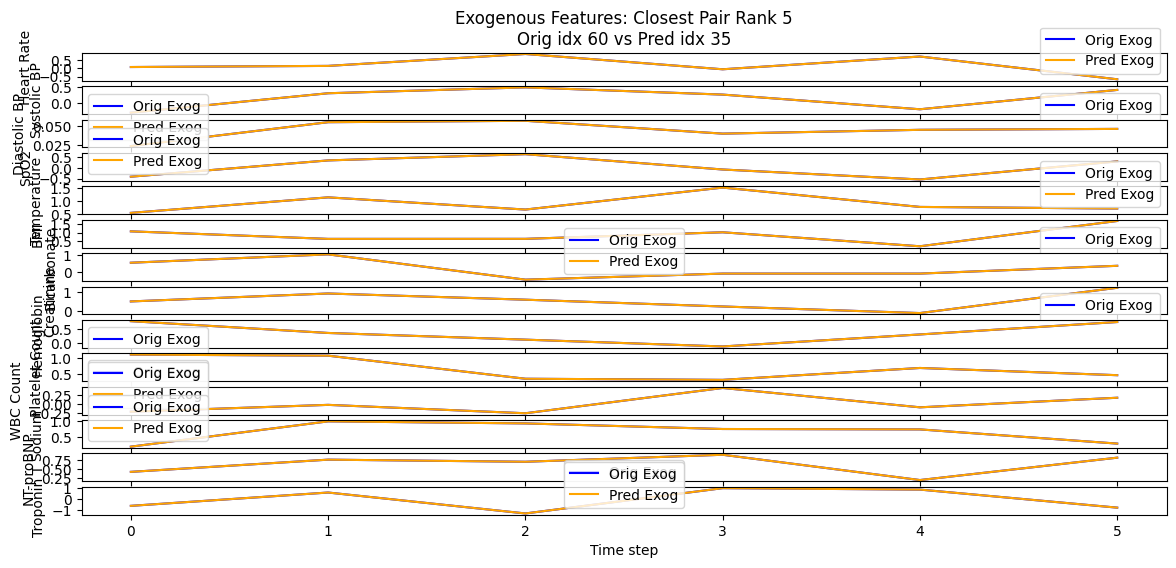

Pair 1 (Orig idx: 0, Pred idx: 0):
  Feature 1 (Heart Rate) Euclidean distance: 0.0000
  Feature 2 (Systolic BP) Euclidean distance: 0.0000
  Feature 3 (Diastolic BP) Euclidean distance: 0.0000
  Feature 4 (SpO2) Euclidean distance: 0.0000
  Feature 5 (Temperature) Euclidean distance: 0.0000
  Feature 6 (BMI) Euclidean distance: 0.0000
  Feature 7 (Bicarbonate) Euclidean distance: 0.0000
  Feature 8 (Creatinine) Euclidean distance: 0.0000
  Feature 9 (Hemoglobin) Euclidean distance: 0.0000
  Feature 10 (Platelet Count) Euclidean distance: 0.0000
  Feature 11 (WBC Count) Euclidean distance: 0.0000
  Feature 12 (Sodium) Euclidean distance: 0.0000
  Feature 13 (NT-proBNP) Euclidean distance: 0.0000
  Feature 14 (Troponin T) Euclidean distance: 0.0000
Pair 2 (Orig idx: 60, Pred idx: 38):
  Feature 1 (Heart Rate) Euclidean distance: 0.0000
  Feature 2 (Systolic BP) Euclidean distance: 0.0000
  Feature 3 (Diastolic BP) Euclidean distance: 0.0000
  Feature 4 (SpO2) Euclidean distance: 0.0000


In [571]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Define MIMIC feature labels
labels = [
    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
]
# Flatten target arrays appropriately (make sure samples x time)
orig_targets = mimic_orig_targets_sarimax.squeeze()
pred_targets = mimic_targets_sarimax.squeeze()

if orig_targets.ndim == 1:
    orig_targets = orig_targets.reshape(1, -1)

if pred_targets.ndim == 1:
    pred_targets = pred_targets.reshape(1, -1)

# Binarize the predictions (e.g., threshold at 0.5)
binary_orig_targets = np.where(orig_targets >= 0.5, 1, 0)
binary_pred_targets = np.where(pred_targets >= 0.5, 1, 0)

dist_matrix = pairwise_distances(binary_orig_targets, binary_pred_targets, metric='euclidean')

if np.array_equal(binary_orig_targets, binary_pred_targets):
    np.fill_diagonal(dist_matrix, np.inf)

k = 5
flat_indices = np.argsort(dist_matrix, axis=None)[:k]
closest_pairs = list(zip(*np.unravel_index(flat_indices, dist_matrix.shape)))

def is_nonempty_series(series, threshold=1e-5):
    return np.any(np.abs(series) > threshold)

# Plot targets for closest pairs (binary targets)
for rank, (orig_idx, pred_idx) in enumerate(closest_pairs[:5], 1):
    orig_series = binary_orig_targets[orig_idx].squeeze()
    pred_series = binary_pred_targets[pred_idx].squeeze()

    #if not (is_nonempty_series(orig_series) and is_nonempty_series(pred_series)):
    #    print(f"Skipping rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}): empty or near-zero series.")
    #    continue

    target_distance = np.linalg.norm(orig_series - pred_series)
    print(f"Pair {rank} (Orig idx: {orig_idx}, Pred idx: {pred_idx}) Target Euclidean distance: {target_distance:.4f}")

    plt.figure(figsize=(12, 6))
    time_axis = range(orig_targets.shape[1])
    plt.step(time_axis, orig_series, where='mid', label='Original Target (0=Survived, 1=Died)', color='blue')
    plt.step(time_axis, pred_series, where='mid', label='Predicted Target', color='orange', linestyle='--')
    plt.title(f"Binary Outcome Similarity: Orig idx {orig_idx} vs Pred idx {pred_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Outcome")
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.savefig(f"similar_binary_target_{args.dataset}_sarimax_female_1y_{orig_idx}_{pred_idx}.png")
    plt.show()

# Plot exogenous features for closest pairs
orig_exogs = mimic_transformed_orig_exogs_sarimax
pred_exogs = mimic_transformed_exogs_sarimax
num_exog_vars = orig_exogs.shape[2]

for rank, (orig_idx, pred_idx) in enumerate(closest_pairs[:5], 1):
    orig_exog = orig_exogs[orig_idx]
    pred_exog = pred_exogs[pred_idx]

    #if not (is_nonempty_series(orig_exog) and is_nonempty_series(pred_exog)):
    #    print(f"Skipping exog plot rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}) due to empty or near-zero values.")
    #    continue

    plt.figure(figsize=(14, 6))
    timesteps = orig_exogs.shape[1]
    time_axis = range(timesteps)

    for feature_idx in range(num_exog_vars):
        plt.subplot(num_exog_vars, 1, feature_idx + 1)
        plt.plot(time_axis, orig_exog[:, feature_idx], label='Orig Exog', color='blue')
        plt.plot(time_axis, pred_exog[:, feature_idx], label='Pred Exog', color='orange')
        plt.ylabel(f'{labels[feature_idx]}')
        if feature_idx == 0:
            plt.title(f'Exogenous Features: Closest Pair Rank {rank}\nOrig idx {orig_idx} vs Pred idx {pred_idx}')
        if feature_idx == num_exog_vars - 1:
            plt.xlabel('Time step')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"similar_exogs_{args.dataset}_sarimax_female_1y_{orig_idx}_{pred_idx}.png")
    plt.show()

# Calculate and print Euclidean distances for exogenous features per pair
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs[:5]:
    distances = []
    for feature_idx in range(num_exog_vars):
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)

    exog_distances_per_feature.append(distances)

# Print distances
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    orig_idx, pred_idx = closest_pairs[pair_idx - 1]
    print(f"Pair {pair_idx} (Orig idx: {orig_idx}, Pred idx: {pred_idx}):")
    for feature_idx, dist in enumerate(distances):
        print(f"  Feature {feature_idx + 1} ({labels[feature_idx]}) Euclidean distance: {dist:.4f}")


Pair 1 (Orig idx: 0, Pred idx: 0) Target Euclidean distance: 1.5135


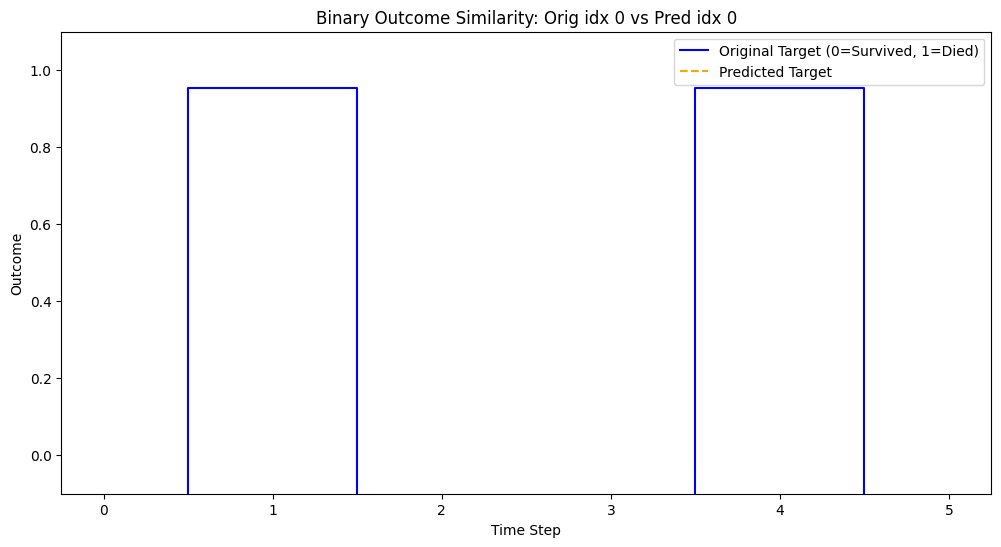

Pair 2 (Orig idx: 60, Pred idx: 38) Target Euclidean distance: 1.5135


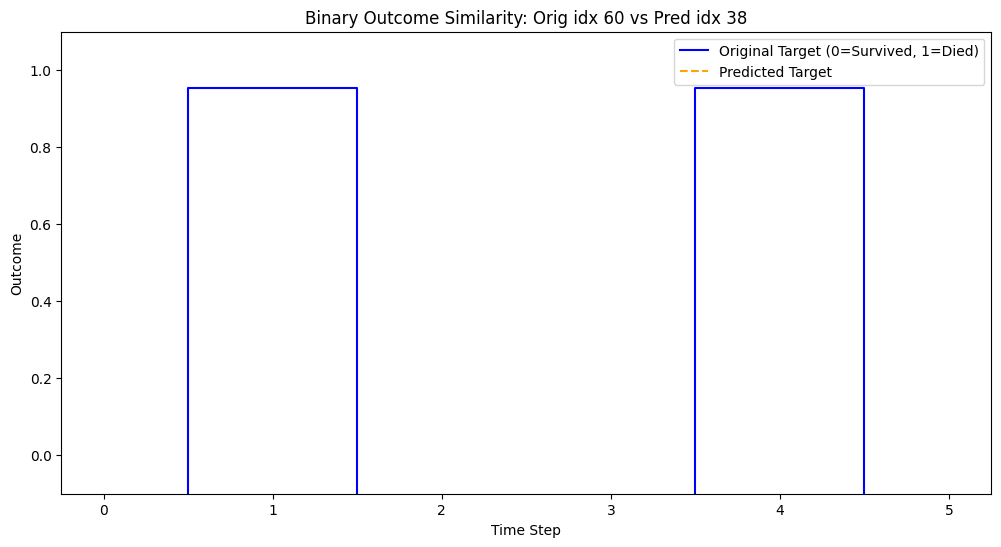

Pair 3 (Orig idx: 60, Pred idx: 37) Target Euclidean distance: 1.5135


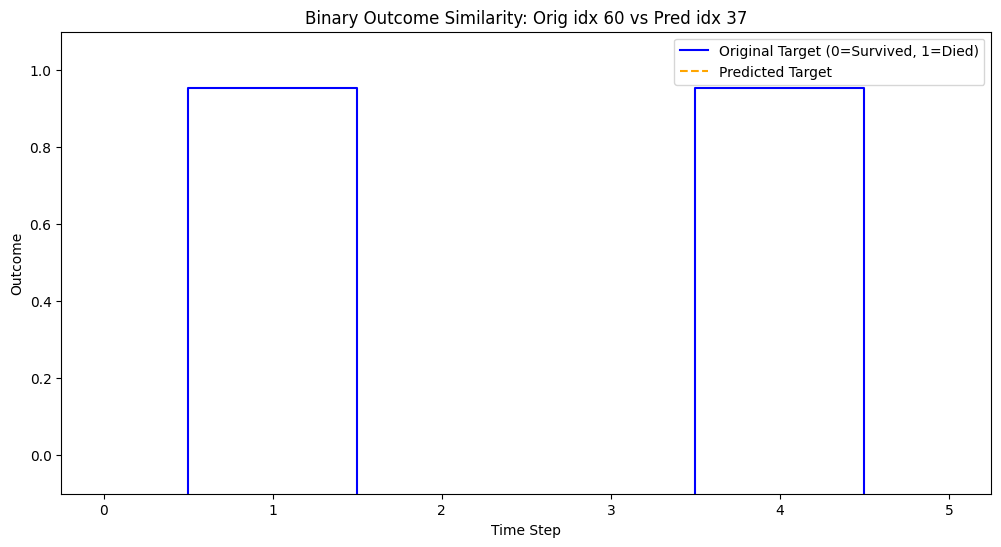

Pair 4 (Orig idx: 60, Pred idx: 36) Target Euclidean distance: 1.5135


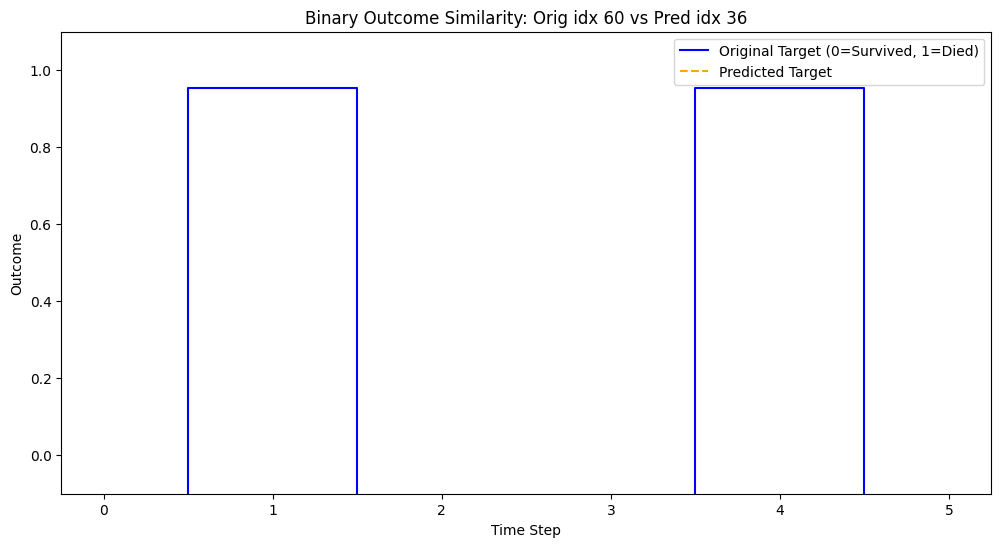

Pair 5 (Orig idx: 60, Pred idx: 35) Target Euclidean distance: 1.5135


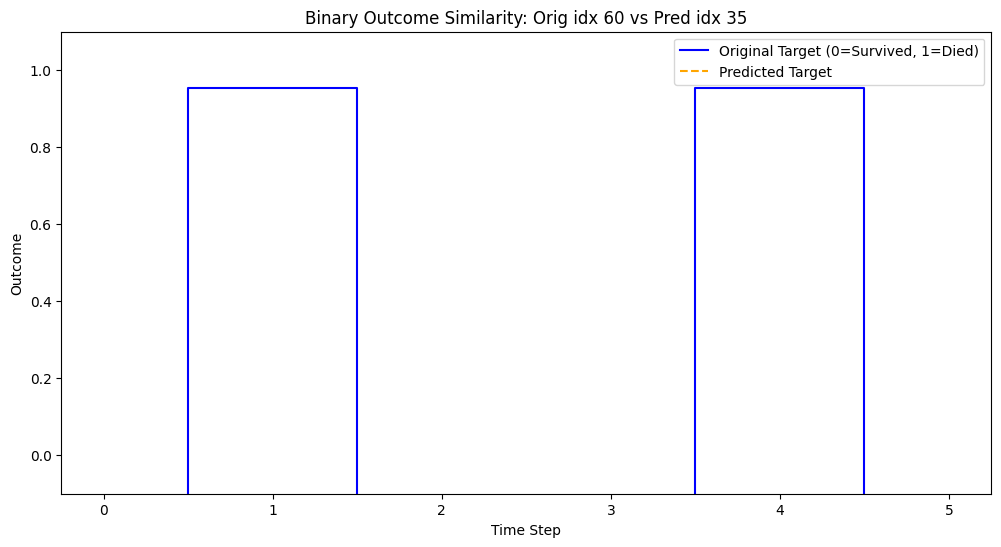

/tmp/ipykernel_420919/3872916769.py:93: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


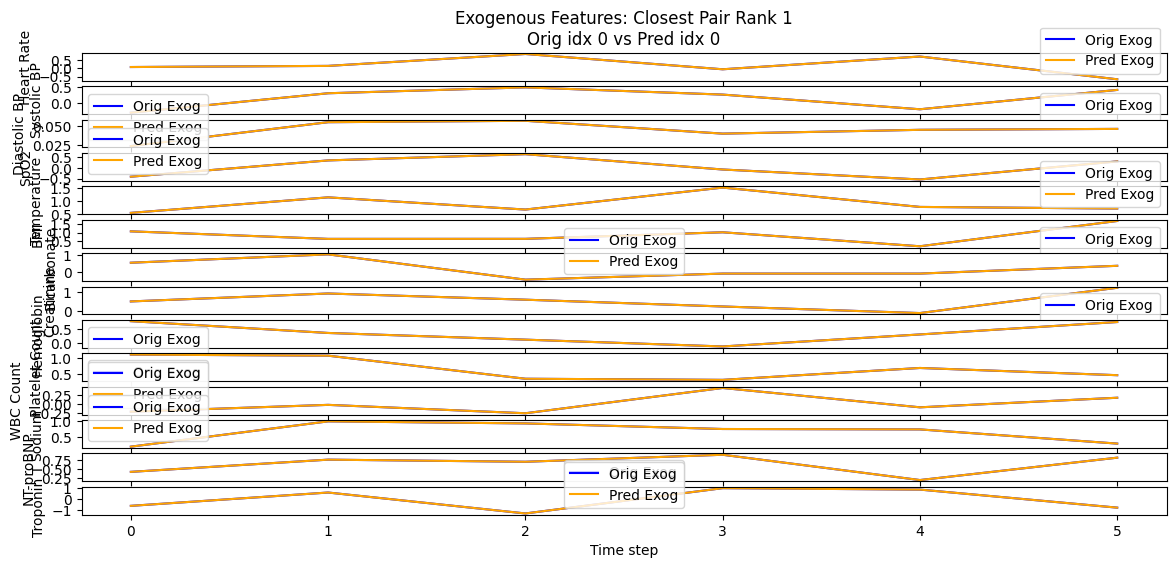

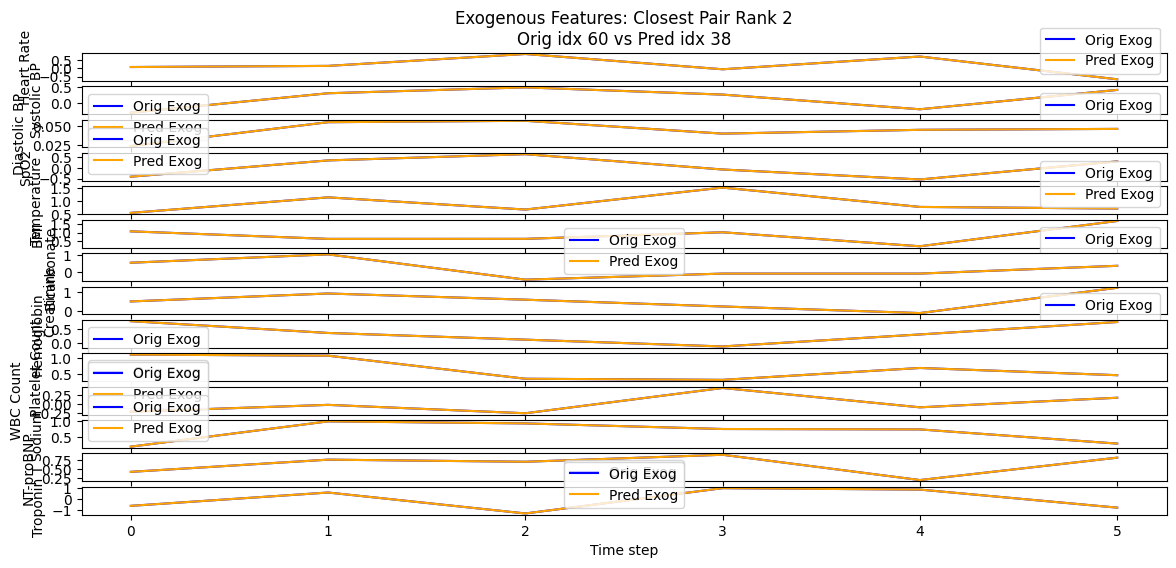

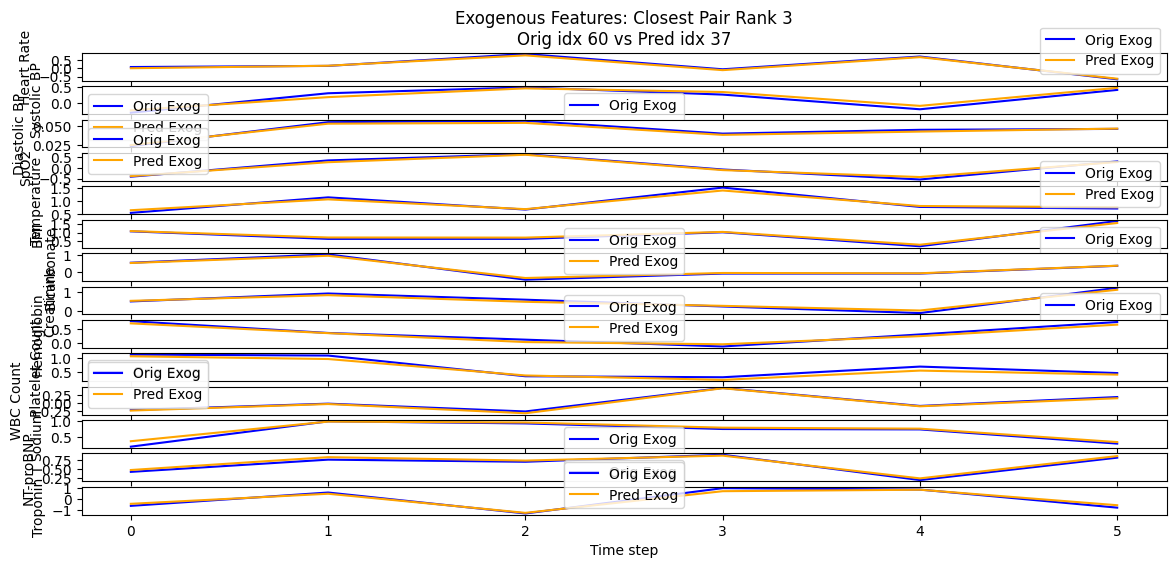

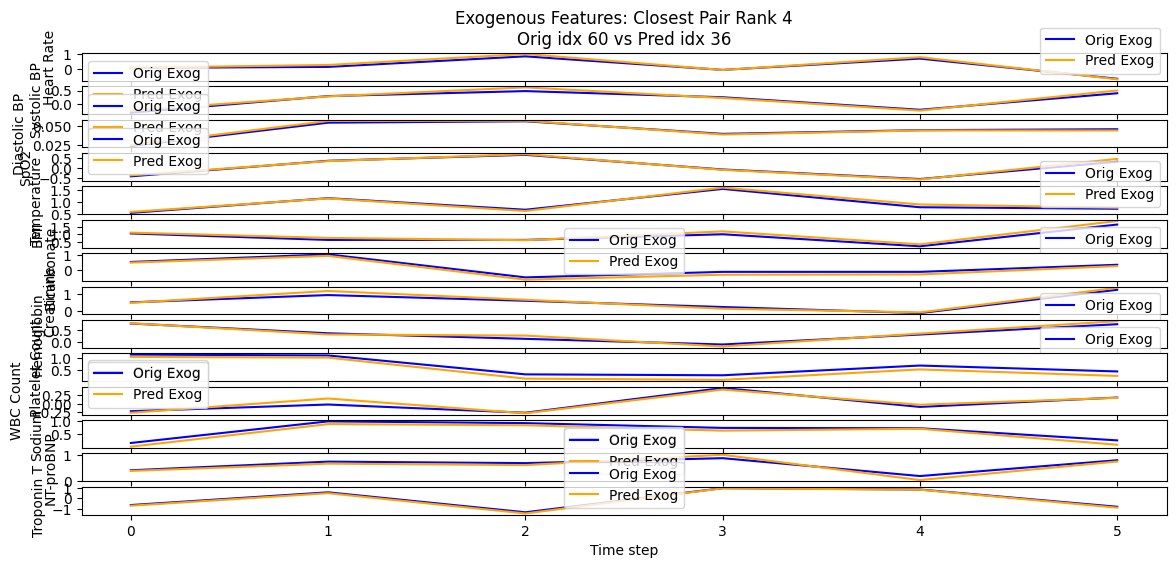

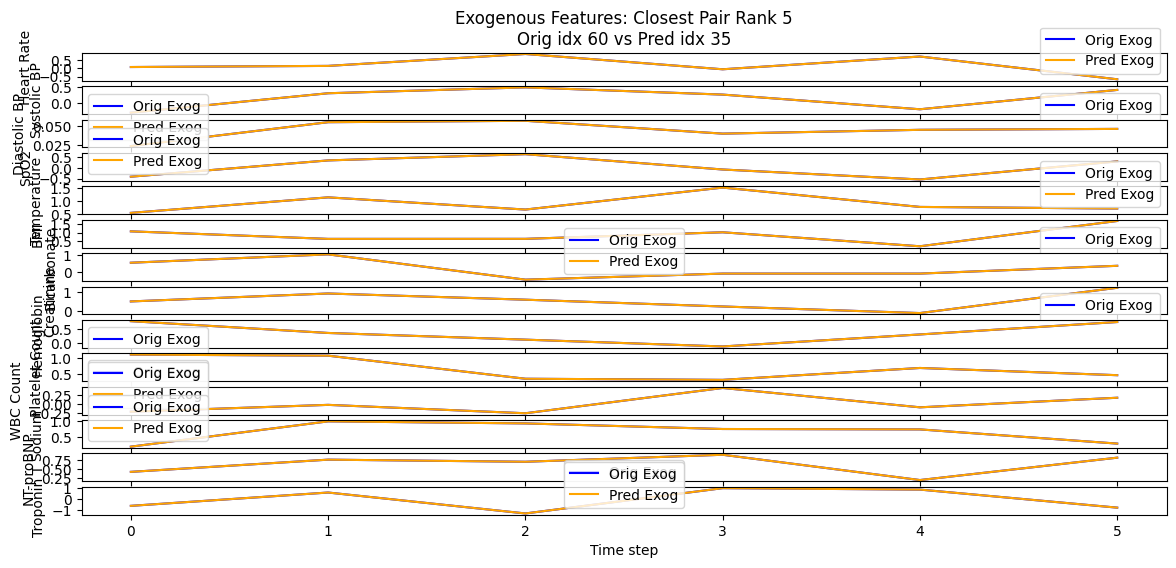

Pair 1 (Orig idx: 0, Pred idx: 0):
  Feature 1 (Heart Rate) Euclidean distance: 0.0000
  Feature 2 (Systolic BP) Euclidean distance: 0.0000
  Feature 3 (Diastolic BP) Euclidean distance: 0.0000
  Feature 4 (SpO2) Euclidean distance: 0.0000
  Feature 5 (Temperature) Euclidean distance: 0.0000
  Feature 6 (BMI) Euclidean distance: 0.0000
  Feature 7 (Bicarbonate) Euclidean distance: 0.0000
  Feature 8 (Creatinine) Euclidean distance: 0.0000
  Feature 9 (Hemoglobin) Euclidean distance: 0.0000
  Feature 10 (Platelet Count) Euclidean distance: 0.0000
  Feature 11 (WBC Count) Euclidean distance: 0.0000
  Feature 12 (Sodium) Euclidean distance: 0.0000
  Feature 13 (NT-proBNP) Euclidean distance: 0.0000
  Feature 14 (Troponin T) Euclidean distance: 0.0000
Pair 2 (Orig idx: 60, Pred idx: 38):
  Feature 1 (Heart Rate) Euclidean distance: 0.0000
  Feature 2 (Systolic BP) Euclidean distance: 0.0000
  Feature 3 (Diastolic BP) Euclidean distance: 0.0000
  Feature 4 (SpO2) Euclidean distance: 0.0000


In [572]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Define MIMIC feature labels
labels = [
    "Heart Rate", "Systolic BP", "Diastolic BP", "SpO2", "Temperature", "BMI",
    "Bicarbonate", "Creatinine", "Hemoglobin", "Platelet Count",
    "WBC Count", "Sodium", "NT-proBNP", "Troponin T"
]
# Flatten target arrays appropriately (make sure samples x time)
orig_targets = mimic_transformed_orig_targets_sarimax.squeeze()
pred_targets = mimic_transformed_targets_sarimax.squeeze()

if orig_targets.ndim == 1:
    orig_targets = orig_targets.reshape(1, -1)

if pred_targets.ndim == 1:
    pred_targets = pred_targets.reshape(1, -1)

binary_orig_targets = np.where(orig_targets >= 0.5, 1, 0)
binary_pred_targets = np.where(pred_targets >= 0.5, 1, 0)

# Compute pairwise distances between original and predicted targets
dist_matrix = pairwise_distances(binary_orig_targets, binary_pred_targets, metric='euclidean')

#num_orig = orig_targets.shape[0]
#num_pred = pred_targets.shape[0]

# Avoid self-comparison if comparing within the same array
if np.array_equal(binary_orig_targets, binary_pred_targets):
    np.fill_diagonal(dist_matrix, np.inf)

k = 5
flat_indices = np.argsort(dist_matrix, axis=None)[:k]
closest_pairs = list(zip(*np.unravel_index(flat_indices, dist_matrix.shape)))

def is_nonempty_series(series, threshold=1e-5):
    return np.any(np.abs(series) > threshold)

# Plot targets for closest pairs (binary targets)
for rank, (orig_idx, pred_idx) in enumerate(closest_pairs[:5], 1):
    orig_series = orig_targets[orig_idx].squeeze()
    pred_series = pred_targets[pred_idx].squeeze()

    #if not (is_nonempty_series(orig_series) and is_nonempty_series(pred_series)):
    #    print(f"Skipping rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}): empty or near-zero series.")
    #    continue

    target_distance = np.linalg.norm(orig_series - pred_series)
    print(f"Pair {rank} (Orig idx: {orig_idx}, Pred idx: {pred_idx}) Target Euclidean distance: {target_distance:.4f}")

    plt.figure(figsize=(12, 6))
    time_axis = range(orig_targets.shape[1])
    plt.step(time_axis, orig_series, where='mid', label='Original Target (0=Survived, 1=Died)', color='blue')
    plt.step(time_axis, pred_series, where='mid', label='Predicted Target', color='orange', linestyle='--')
    plt.title(f"Binary Outcome Similarity: Orig idx {orig_idx} vs Pred idx {pred_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Outcome")
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.savefig(f"similar_binary_target_{args.dataset}_{orig_idx}_{pred_idx}.png")
    plt.show()

# Plot exogenous features for closest pairs
orig_exogs = mimic_transformed_orig_exogs_sarimax
pred_exogs = mimic_transformed_exogs_sarimax
num_exog_vars = orig_exogs.shape[2]

for rank, (orig_idx, pred_idx) in enumerate(closest_pairs[:5], 1):
    orig_exog = orig_exogs[orig_idx]
    pred_exog = pred_exogs[pred_idx]

    if not (is_nonempty_series(orig_exog) and is_nonempty_series(pred_exog)):
        print(f"Skipping exog plot rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}) due to empty or near-zero values.")
        continue

    plt.figure(figsize=(14, 6))
    timesteps = orig_exogs.shape[1]
    time_axis = range(timesteps)

    for feature_idx in range(num_exog_vars):
        plt.subplot(num_exog_vars, 1, feature_idx + 1)
        plt.plot(time_axis, orig_exog[:, feature_idx], label='Orig Exog', color='blue')
        plt.plot(time_axis, pred_exog[:, feature_idx], label='Pred Exog', color='orange')
        plt.ylabel(f'{labels[feature_idx]}')
        if feature_idx == 0:
            plt.title(f'Exogenous Features: Closest Pair Rank {rank}\nOrig idx {orig_idx} vs Pred idx {pred_idx}')
        if feature_idx == num_exog_vars - 1:
            plt.xlabel('Time step')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"similar_exogs_{args.dataset}_{orig_idx}_{pred_idx}.png")
    plt.show()

# Calculate and print Euclidean distances for exogenous features per pair
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs[:5]:
    distances = []
    for feature_idx in range(num_exog_vars):
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)

    exog_distances_per_feature.append(distances)

# Print distances
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    orig_idx, pred_idx = closest_pairs[pair_idx - 1]
    print(f"Pair {pair_idx} (Orig idx: {orig_idx}, Pred idx: {pred_idx}):")
    for feature_idx, dist in enumerate(distances):
        print(f"  Feature {feature_idx + 1} ({labels[feature_idx]}) Euclidean distance: {dist:.4f}")


In [ ]:
#Glucose

TESTTESTESTESTESTEST: (510, 6, 15) (510, 6, 15)
gru model trained, with test sMAPE score 197.8603; test RMSE score: 0.3655.
nbeats model trained, with test sMAPE score 194.9100; test RMSE score: 2.3495.
TEST (510, 6) (510, 6)


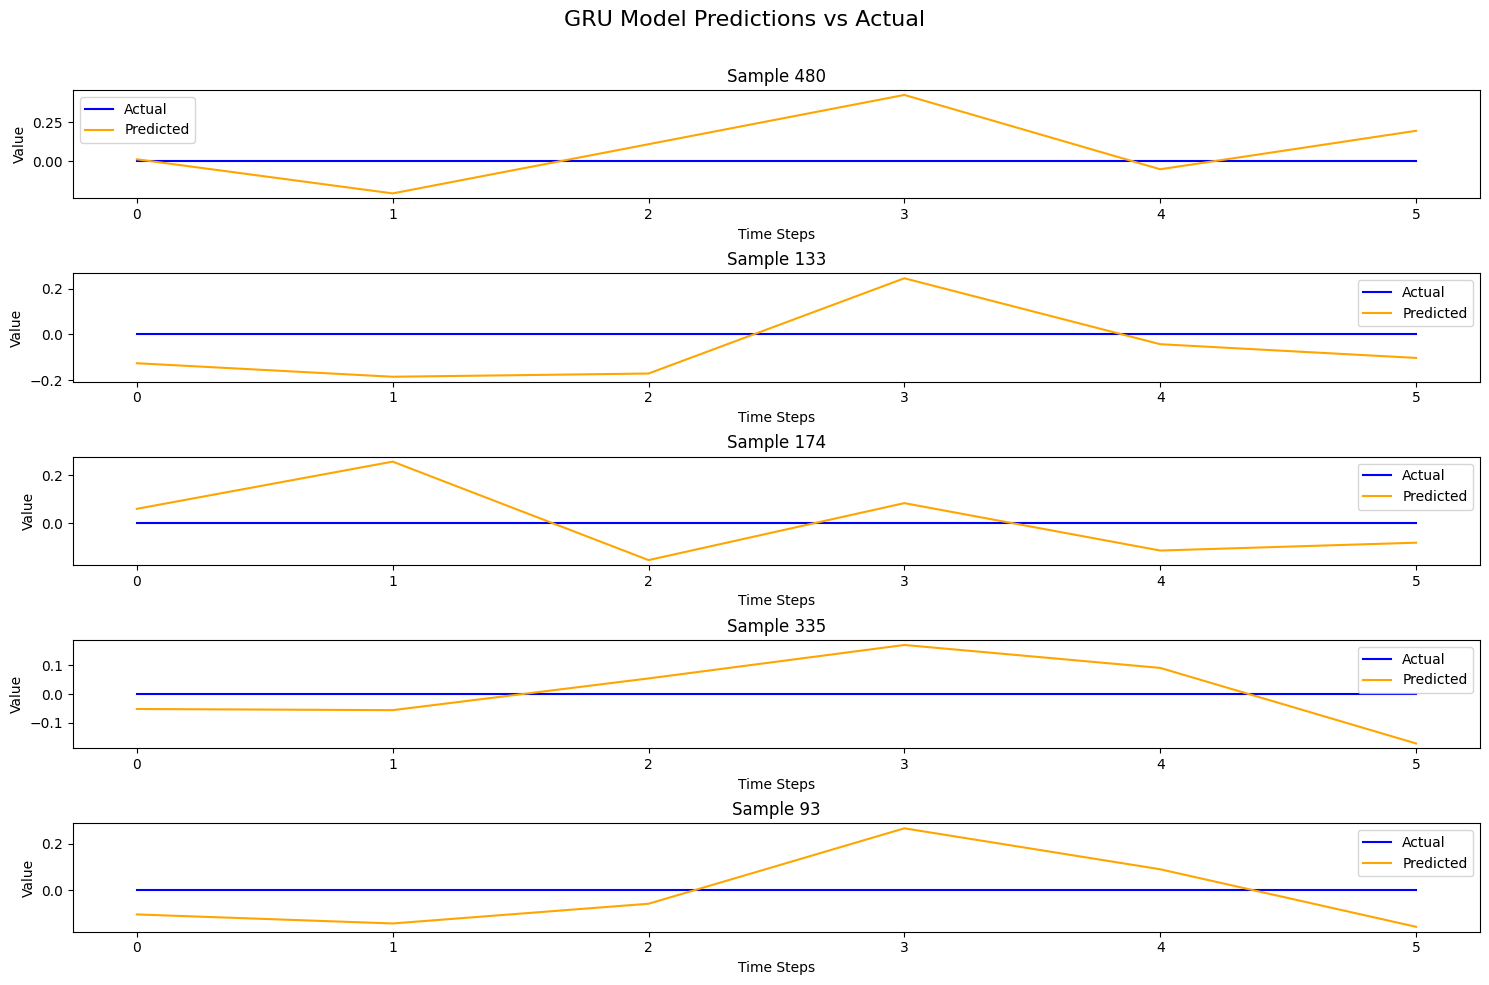

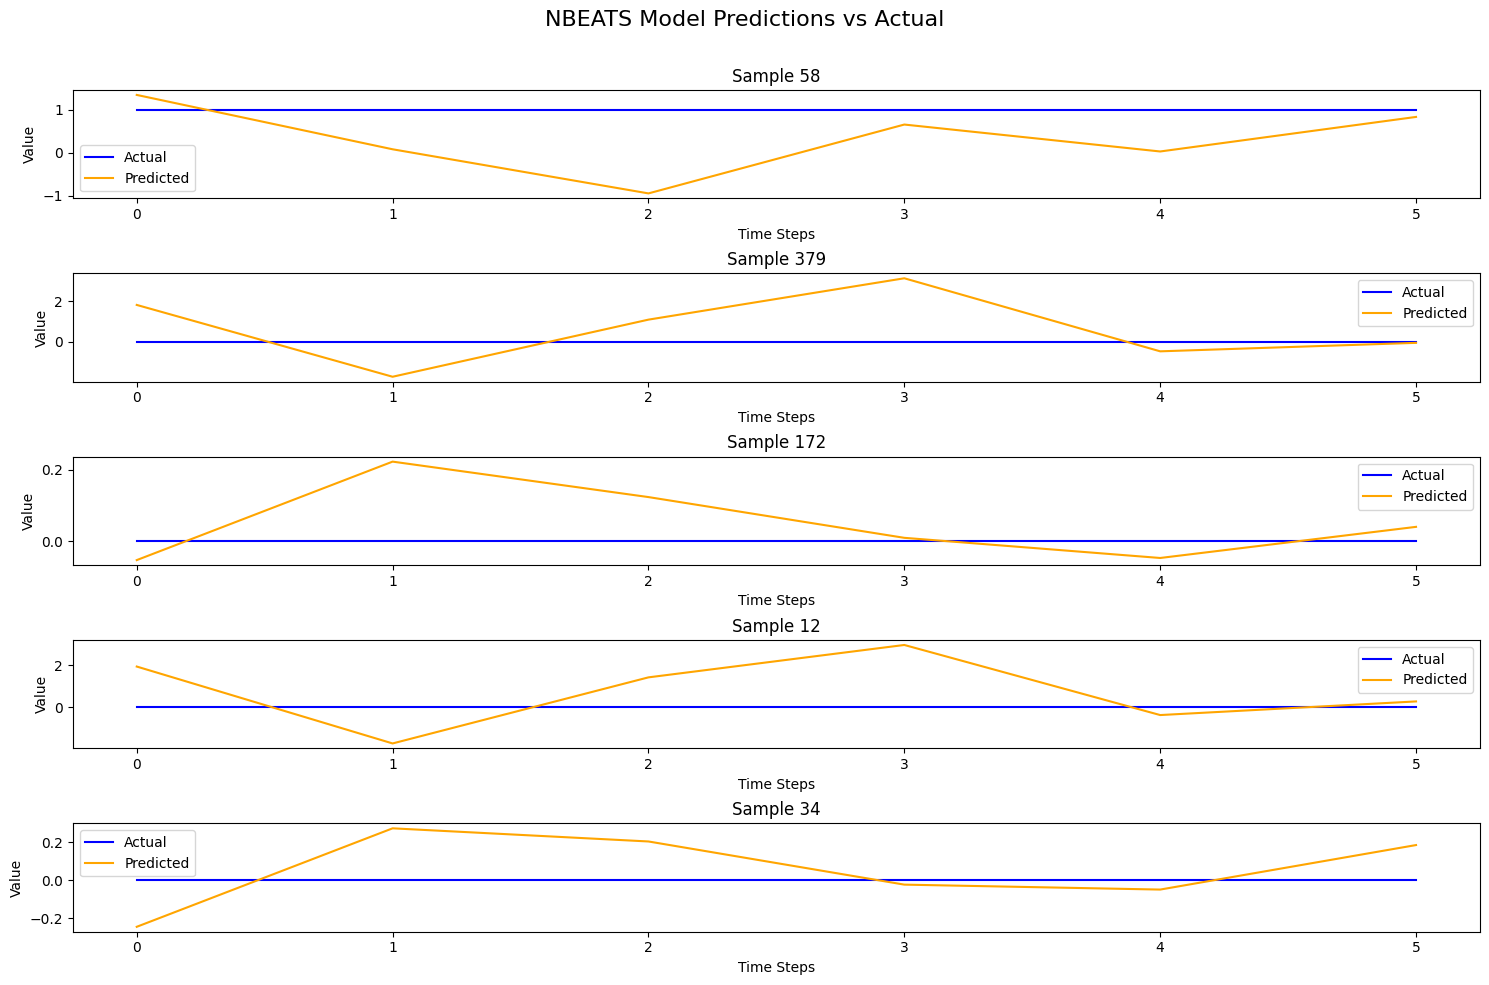

In [193]:

print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]

mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[419], line 21
      6 clip_ranges = [[[0.0, 1.0]] * len(CHANGE_COLS)] * len(X_test)
      7 opt = TimeSeriesOptimizer(
      8     method='sarimax',
      9     dataset=dataset,
   (...)
     18     hist_inputs=hist_inputs   # can be None
     19 )
---> 21 opt.optimize()
     24 mimic_targets_sarimax = opt.targets
     25 mimic_orig_targets_sarimax = opt.orig_targets

Cell In[418], line 160, in TimeSeriesOptimizer.optimize(self)
    157 hist_values = self.hist_value_inputs[idx_i] if self.hist_value_inputs else None
    159 if self.method == 'sarimax':
--> 160     self._optimize_sarimax(idx, idx_i, clip_ranges, hist_values)
    161 elif self.method == 'ols':
    162     self._optimize_ols(idx, idx_i, clip_ranges, hist_values)

Cell In[418], line 211, in TimeSeriesOptimizer._optimize_sarimax(self, sample_idx, loop_idx, clip_ranges, hist_values)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)

def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()


pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
